In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, os, django

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from django.db.models import Q, F, Sum, Count, FloatField, Case, When, Value, Max
from sklearn.manifold import TSNE
from scoping.models import *
import scipy.stats as st
import itertools

django.db.connection.close()

Multicore TSNE not installed, tsne maps will not be able to be calculated
Gensim not installed, you will need this for running Doc2Vec models


In [2]:
q = Query.objects.get(pk=8843)
p = q.project
tags = q.tag_set.values('title')
print(tags)
dodf = (pd.DataFrame.from_dict(DocOwnership.objects.filter(query=q,relevant__gt=0)
                               .exclude(tag__title__icontains="representative")
                              .values('doc_id','id','relevant','user__username'))
       )
dodf.head()

<QuerySet [{'title': 'Probably relevant random sample 7'}, {'title': 'Representative random sample 1'}, {'title': 'Probably relevant random sample 3'}, {'title': 'Probably relevant random sample 6'}, {'title': 'Large representative random sample 2'}, {'title': 'Probably relevant random sample 8'}, {'title': 'Probably relevant random sample 4'}, {'title': 'Random sample 1'}, {'title': 'Probably relevant random sample 2'}, {'title': 'Representative random sample 2'}, {'title': 'Probably relevant random sample 1'}, {'title': 'Probably relevant random sample 9'}, {'title': 'Representative random sample 3'}, {'title': 'Probably relevant random sample 12'}, {'title': 'Representative random sample 5'}, {'title': 'Probably relevant random sample 13'}, {'title': 'Probably relevant random sample 16'}, {'title': 'Probably relevant random sample 15'}, {'title': 'Probably relevant random sample 10'}, {'title': 'Probably relevant random sample 14'}, '...(remaining elements truncated)...']>


doc_id       id  relevant             user__username
0   797278  1907283         1  doebbeling@mcc-berlin.net
1   495908  1630985         3   vasudevan@mcc-berlin.net
2     3556  1892857         1   vasudevan@mcc-berlin.net
3  1115272  1892763         1   vasudevan@mcc-berlin.net
4  2316384  1892853         1   vasudevan@mcc-berlin.net

In [3]:
order_df = (dodf[['doc_id','id']]
            .groupby('doc_id')
            .first()
            .sort_values('id')
            .reset_index()
            .reset_index()
            .rename(columns={"index":"order"})
            .drop(columns="id")
           )
order_df

order   doc_id
0         0  2647339
1         1   643753
2         2   273713
3         3   444393
4         4  1727089
...     ...      ...
1865   1865  1866931
1866   1866  1832851
1867   1867   236181
1868   1868   527547
1869   1869  1281887

[1870 rows x 2 columns]

In [4]:

django.db.connection.close()

q = Query.objects.get(pk=8843)
p = q.project

dos = DocOwnership.objects.filter(tag__query__project=p, relevant__gt=0)

doc_ids = set(dos.values_list('doc__id',flat=True))

# Get relevant / not relevant decisions
do_df = pd.DataFrame.from_dict(
    dos.values('doc__id','doc__title','doc__content','user__username','relevant')
)
do_df.loc[do_df['relevant']==0,'val'] = np.NaN
do_df.loc[do_df['relevant']==1,'val'] = 1
do_df.loc[do_df['relevant']==2,'val'] = 0
do_df.loc[do_df['relevant']==3,'val'] = np.NaN
do_df.head()

# Get category assignment
cats = Category.objects.filter(project=p).exclude(name__icontains="hidden>")
df = pd.DataFrame.from_dict(
    DocUserCat.objects.filter(
        category__in=cats,
        doc__in=doc_ids
    ).values(
        'doc__id',
        'doc__title',
        'doc__content',
        'category__name',
        'category__level',
        'user__username',
        #'countries__name',
        'texts__name',
        'selection_tier'
    )
)
# Filter so that it matches the relevant set
df = df[
    (df[['doc__id','user__username']].apply(tuple, axis=1).isin(do_df[['doc__id','user__username']].apply(tuple, axis=1))) | 
    (df['user__username']=="Auto")
]

# Rename category to capture level
df['category__level'] = df['category__level'].astype(str)
df['Category Name'] = df[['category__level','category__name']].apply(lambda x: ' - '.join(x), axis=1)
#df['cat'] = df[['category__level','category__name','user__username']].apply(lambda x: ' - '.join(x), axis=1)

# Capture the primary/secondary value (1 for primary, 2 for secondary)
df['val'] = df['selection_tier']

# Set the value to the country / text where appropriate and j
#df.loc[~pd.isna(df['countries__name']),'val'] = df.loc[~pd.isna(df['countries__name']),'countries__name']
df.loc[~pd.isna(df['texts__name']),'val'] = df.loc[~pd.isna(df['texts__name']),'texts__name']

cats = df['Category Name'].unique()

df.head()

# Merge relevant/not relevant with categories
do_df['Category Name'] = "0 - relevant"

df = pd.concat([
    df[['doc__id','doc__title','doc__content','user__username','Category Name','val']],
    do_df[['doc__id','doc__title','doc__content','user__username','Category Name','val']]
])
df.tail()

doc__id                                         doc__title  \
5630    51374  THE CHOICE BETWEEN AUCTIONING AND GRANDFATHERI...   
5631   285449             How to support growth with less energy   
5632  1860974  Global semiconductor industry initiative to re...   
5633  1299474  Action on climate change requires deliberative...   
5634   535895  An Empirical Investigation on the Risk-Return ...   

                                           doc__content user__username  \
5630  Based on Hillman's (1982) political support fu...           levs   
5631  Economic growth with less use of primary energ...           levs   
5632  Semiconductor manufacture is a small but poten...           levs   
5633  Despite successful examples of multilevel gove...           levs   
5634  This paper examines the risk-return relationsh...           levs   

     Category Name  val  
5630  0 - relevant  1.0  
5631  0 - relevant  1.0  
5632  0 - relevant  1.0  
5633  0 - relevant  1.0  
5634  0 - relevant  1.0

In [5]:
# fill tag values with 0s where they have been rated
dudf_wide = (df[['doc__id','doc__title','doc__content','user__username','Category Name','val']]
             .pivot_table(index=['doc__id','doc__title','doc__content','user__username'],columns="Category Name", values="val", aggfunc=np.sum)
             #.fillna(0)
            ).reset_index()

cats = [x for x in cats if x in dudf_wide.columns]

dudf_wide[cats] = dudf_wide[cats].fillna(0)

policy_columns=[x for x in dudf_wide.columns if re.match("^3",x)]
include_policy_columns = [x for x in policy_columns if "not policy related" not in x.lower() and "broader" not in x.lower()]
print(policy_columns)
post_policy_columns=[x for x in dudf_wide.columns if re.match("^[4-9]",x) or re.match("^[0-9]{2}",x)]
dudf_wide.loc[dudf_wide['3 - 0. Not policy related']==1,post_policy_columns] = np.NaN
dudf_wide.loc[dudf_wide[policy_columns].sum(axis=1,min_count=1)==0,post_policy_columns] = np.NaN
dudf_wide.loc[dudf_wide[include_policy_columns].sum(axis=1,min_count=1)>0,"INCLUDE"] = 1
dudf_wide.loc[dudf_wide[include_policy_columns].sum(axis=1,min_count=1)==0,"INCLUDE"] = 0
dudf_wide

df = dudf_wide.melt(id_vars=['doc__id','doc__title','doc__content','user__username'])

df['value'] = df['value'].replace(2,1)

df



['3 - 0. Not policy related', '3 - 1. Analysis of an existing policy / concrete proposal', '3 - 2. Analysis of a generic policy', '3 - 3. Broader governance and policy']


doc__id                                         doc__title  \
0           156  THE EXPECTED GREENHOUSE BENEFITS FROM DEVELOPI...   
1           156  THE EXPECTED GREENHOUSE BENEFITS FROM DEVELOPI...   
2           337  Energy forecast till 2020 for the German Gover...   
3           337  Energy forecast till 2020 for the German Gover...   
4           921  Ontology engineering in provenance enablement ...   
...         ...                                                ...   
564565  3878364  Occupants' Awareness of and Satisfaction with ...   
564566  3878440  Urban consumers' willingness to pay for higher...   
564567  3878440  Urban consumers' willingness to pay for higher...   
564568  3878516  Life cycle greenhouse gas impacts of a connect...   
564569  3878516  Life cycle greenhouse gas impacts of a connect...   

                                             doc__content  \
0       Magma power is the production of electricity f...   
1       Magma power is the production of electricity f...   
2       A study conducted by the Prognos economic rese...   
3       A study conducted by the Prognos economic rese...   
4       The National Climate Assessment of the U.S. Gl...   
...                                                   ...   
564565  With growing awareness of the need to reduce g...   
564566  Rapid urbanization poses accelerating pressure...   
564567  Rapid urbanization poses accelerating pressure...   
564568  As technological advancements progress, the au...   
564569  As technological advancements progress, the au...   

                     user__username Category Name value  
0               ceposadap@gmail.com  0 - relevant   1.0  
1       edmondson@hertie-school.org  0 - relevant   1.0  
2               ceposadap@gmail.com  0 - relevant   1.0  
3           lucy.banisch@icloud.com  0 - relevant   1.0  
4         doebbeling@mcc-berlin.net  0 - relevant   1.0  
...                             ...           ...   ...  
564565     vasudevan@mcc-berlin.net       INCLUDE   1.0  
564566          ceposadap@gmail.com       INCLUDE   1.0  
564567  edmondson@hertie-school.org       INCLUDE   0.0  
564568          ceposadap@gmail.com       INCLUDE   0.0  
564569     vasudevan@mcc-berlin.net       INCLUDE   0.0  

[564570 rows x 6 columns]

In [6]:
sector_cats = [x for x in df["Category Name"].unique() if re.match("^9 -",x)]
sector_cats

['9 - 0. Ex-post', '9 - 1. Ex-ante', '9 - 2. Ex-ante (IAM)']

In [7]:

recodings = [
    (["7 - 0. Supranational and international"],"17 - 0. Supranational and international"),
    (["7 - 1. National"], "17 - 1. National"),
    (["7 - 2. Sub-national / regional","7 - 3. Local"], "17 - 2. Sub-national"),
    (['9 - 1. Ex-ante', '9 - 2. Ex-ante (IAM)'], "19 - 1. Ex-ante"),
    (['9 - 0. Ex-post'], "19 - 0. Ex-post"),
]
add_rows = []
for x, y in recodings:
    sub_df = df[df["Category Name"].isin(x)].groupby(["doc__id","user__username"])["value"].max().reset_index()
    sub_df["Category Name"] = y
    df = pd.concat([df,sub_df])

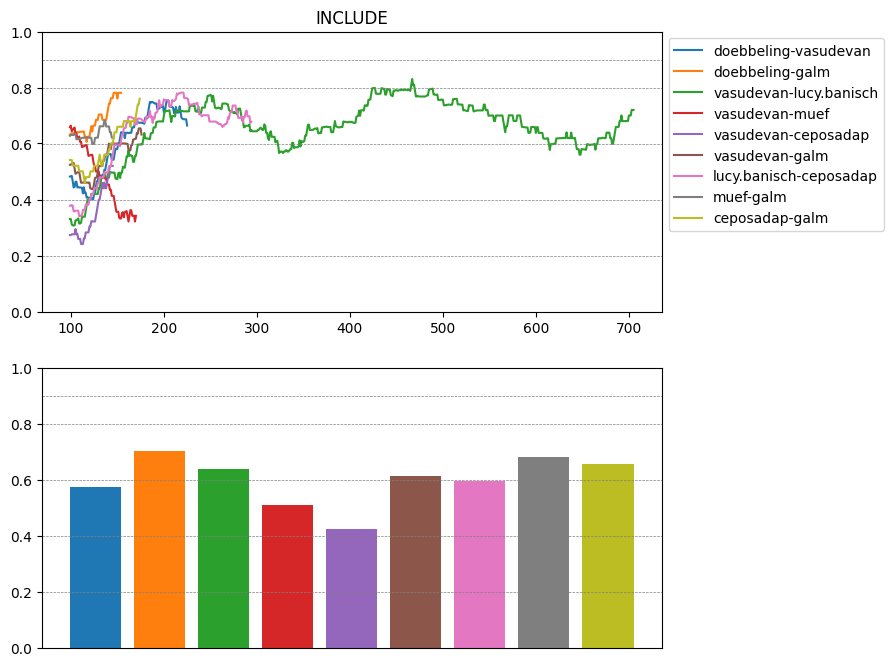

In [8]:
import itertools
pairs = list(itertools.combinations(dodf['user__username'].unique(),2))
pairs

c = "INCLUDE"

from sklearn.metrics import cohen_kappa_score
from numpy_ext import rolling_apply as rolling_apply_ext
def quiet_cohen_kappa_score(y1, y2, labels=[0,1]):
    sample_labels = set(y1) | set(y2)
    if len(set(labels)-sample_labels) > 0:
        return np.NaN
    return cohen_kappa_score(y1, y2, labels=labels)
ckfunc = lambda a1, a2: quiet_cohen_kappa_score(a1,a2)

fig, axs = plt.subplots(2,figsize=(8,8))

def pairwise_agreement(df, pairs, c, axs, window):
    axs[0].set_title(c)
    df[df['Category Name']==c].dropna()
    i = 0
    cks = []
    pair_labels = []
    for p in pairs:
        d1 = df[(df['user__username']==p[0]) & (df['Category Name']==c)].rename(columns={"value":p[0]}).drop(columns="user__username")
        d2 = df[(df['user__username']==p[1]) & (df['Category Name']==c)].rename(columns={"value":p[1]}).drop(columns="user__username")

        pdf = (d1.merge(d2,how="inner")
               .merge(order_df,left_on="doc__id",right_on="doc_id")
               .sort_values('order')
               .reset_index(drop=True)
              )
        if pdf.shape[0]<window:
            continue
        else:
            pair_label = f"{p[0].split('@')[0]}-{p[1].split('@')[0]}"
            ckr = rolling_apply_ext(ckfunc, window, pdf[p[0]].astype(int).values, pdf[p[1]].astype(int).values)
            axs[0].plot(ckr,label=pair_label)
            ck = cohen_kappa_score(pdf[p[0]].astype(int).values,pdf[p[1]].astype(int).values)
            axs[1].bar(i,ck,label=pair_label)
            cks.append(ck)
            pair_labels.append(pair_label)
            i+=1
            
    axs[1].set_xticks([])
    for ax in axs:
        ax.set_ylim(0,1)
        for t,ag in [(0,"None"),(0.2,"Minimal"),(0.4,"Weak"),(0.6,"Moderate"),(0.8,"Strong"),(0.9,"Almost Perfect")]:
            ax.axhline(t,color="grey",ls="--",lw=0.5)

    axs[0].legend(bbox_to_anchor=(1,1))
    return cks, pair_labels
    
cks, pair_labels = pairwise_agreement(df, pairs, c, axs, 100)
plt.show()

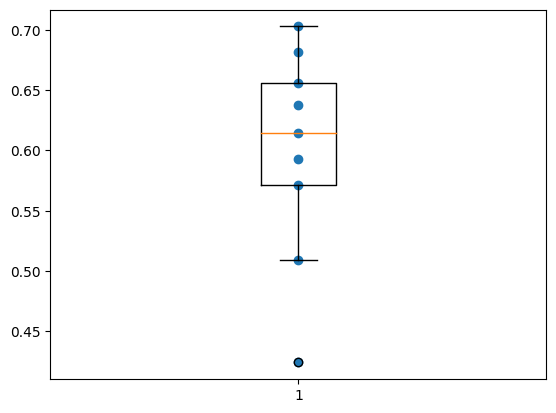

In [9]:
fig, ax = plt.subplots()
ax.boxplot(cks)
ax.scatter([1]*len(cks),cks)

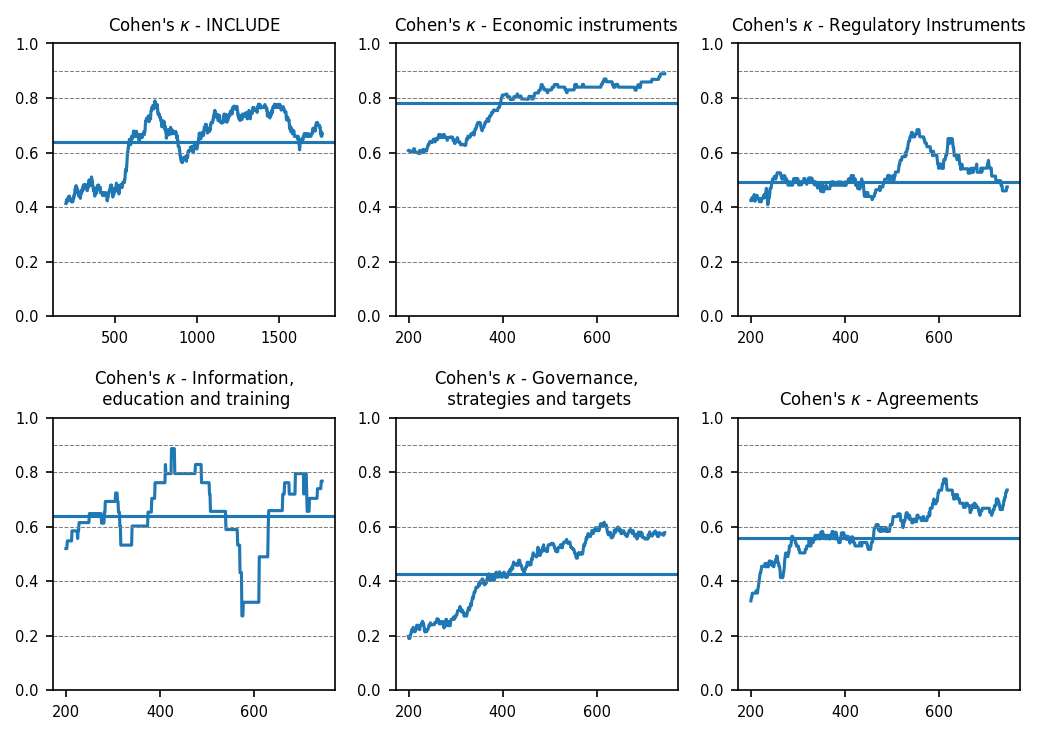

In [10]:
window = 200

fig = plt.figure(figsize=(7,5), dpi=150)

def total_ck(ax, df, c):
    df['coder'] = df.groupby(['doc__id','Category Name'])['value'].cumcount()
    pdf = df[df['Category Name']==c]
    pdf = (
        pdf[(pdf['coder']<2)]
        .pivot(index="doc__id",columns="coder",values="value").reset_index()
        .merge(order_df,left_on="doc__id",right_on="doc_id")
        .sort_values('order')
        .dropna()
    )
    ckr = rolling_apply_ext(ckfunc, window, pdf[0].astype(int).values, pdf[1].astype(int).values)
    ck = cohen_kappa_score(pdf[0].astype(int).values, pdf[1].astype(int).values)
    if ax is None:
        return ck
    ax.plot(ckr)
    ax.axhline(ck)
    ax.xaxis.set_tick_params(labelsize=7)
    ax.yaxis.set_tick_params(labelsize=7)
    
    ax.set_ylim(0,1)
    for t,ag in [(0,"None"),(0.2,"Minimal"),(0.4,"Weak"),(0.6,"Moderate"),(0.8,"Strong"),(0.9,"Almost Perfect")]:
        ax.axhline(t,color="grey",ls="--",lw=0.5)
        
    c = re.sub("[^a-zA-Z ,]","",c).strip().replace(',',',\n')
    
    ax.set_title(f"Cohen's $\kappa$ - {c}", fontsize=8)
    
    return ck
    
    
c1_cats = [x for x in df["Category Name"].unique() if re.match("^4",x)]

kappa_scores = []

for i,c in enumerate(["INCLUDE"] + c1_cats):
    ax = fig.add_subplot(2,3,i+1)
    ck = total_ck(ax, df, c)
    kappa_scores.append({"category": c, "kappa": ck})
    
fig.tight_layout()

plt.savefig('../figures/agreement_categories.pdf', bbox_inches="tight")

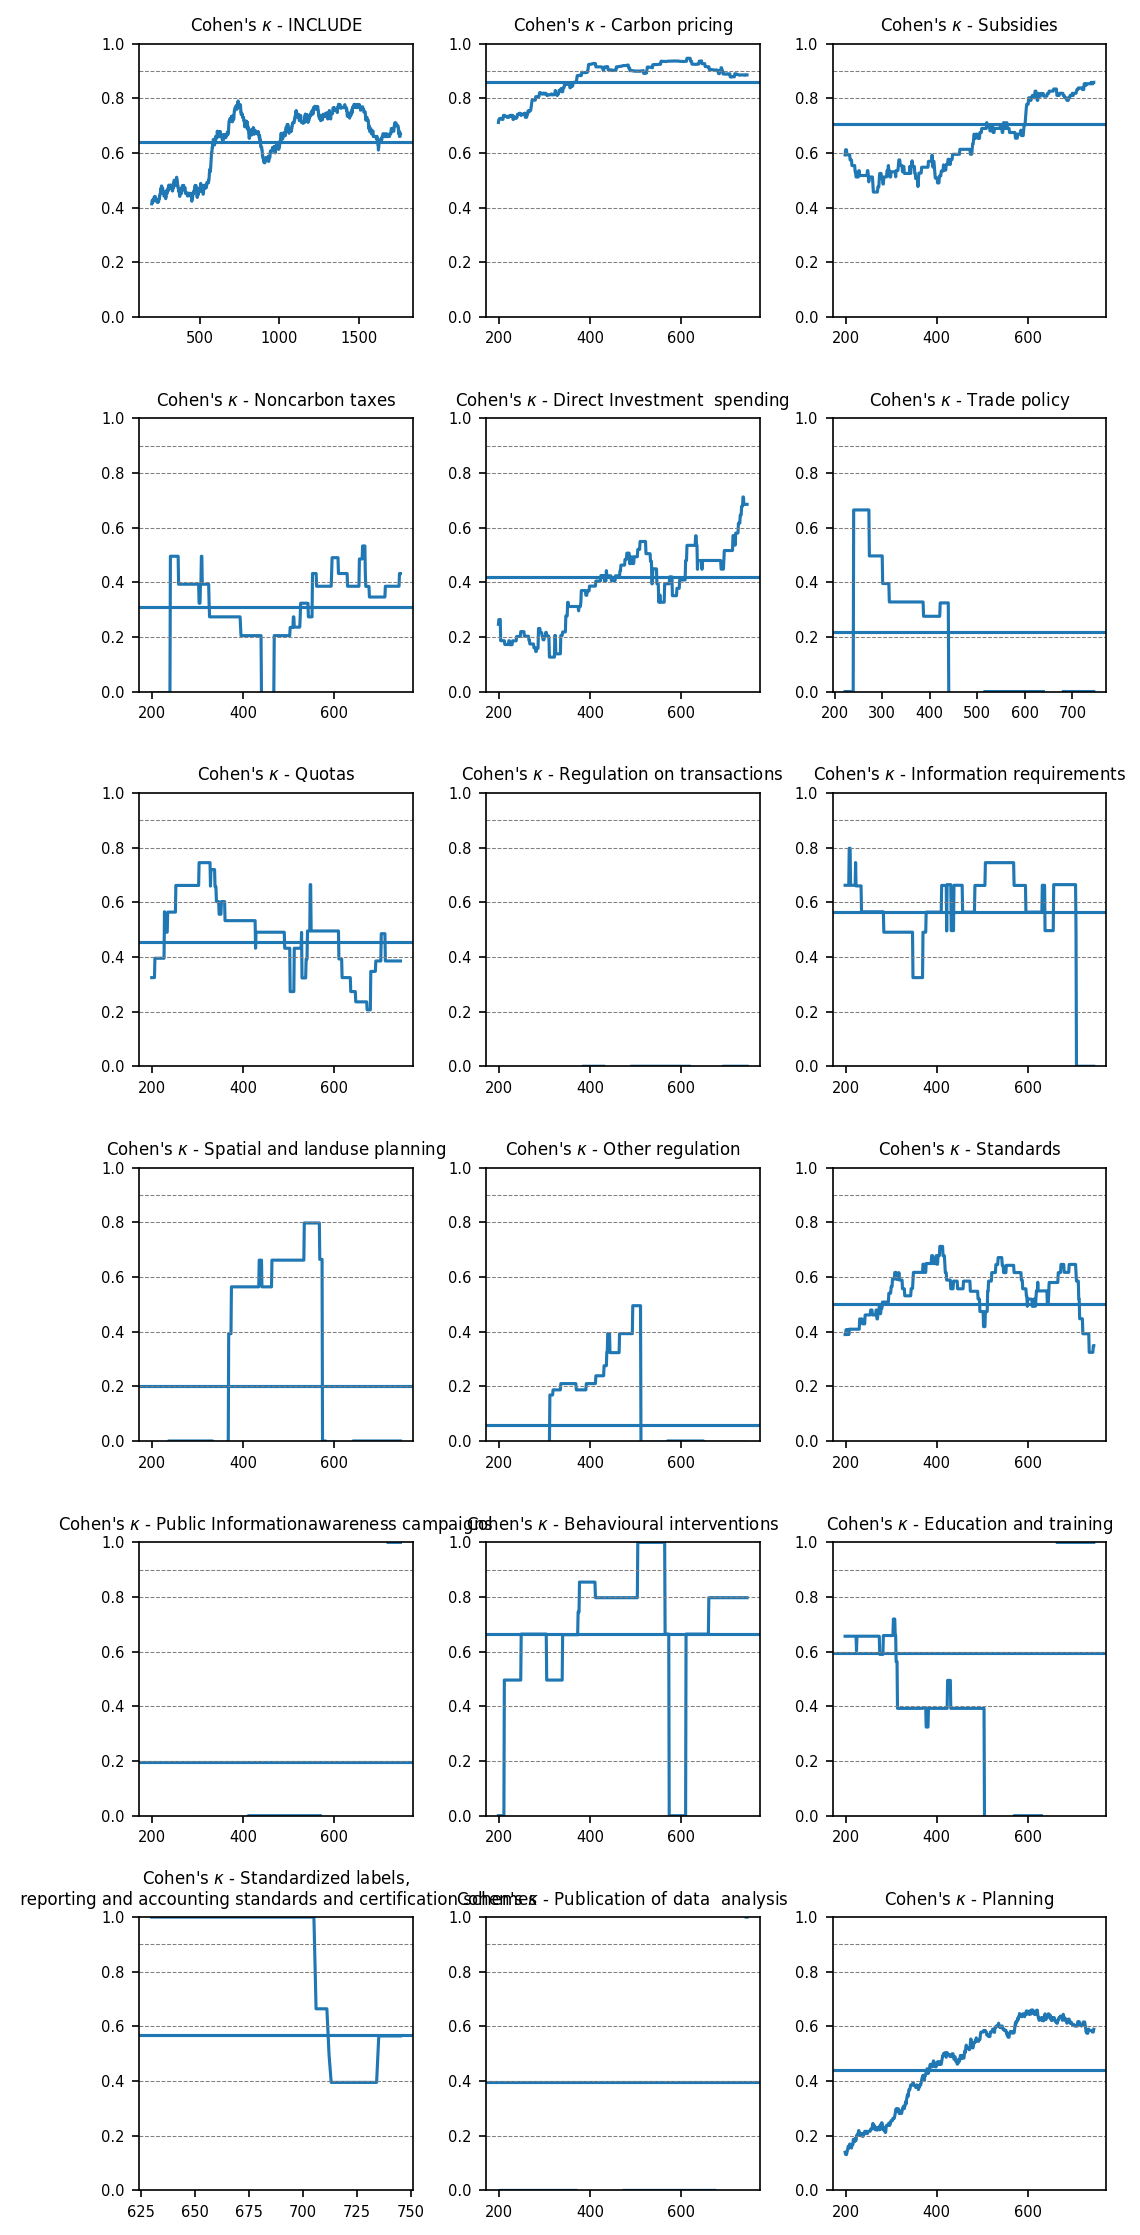

In [11]:
window = 200

fig = plt.figure(figsize=(7,15), dpi=150)    
    
c1_cats = [x for x in df["Category Name"].unique() if re.match("^5",x)]

for i,c in enumerate(["INCLUDE"] + c1_cats):
    try:
        ax = fig.add_subplot(6,3,i+1)
    except:
        ax = None
    ck = total_ck(ax, df, c)
    if c!="INCLUDE":
        kappa_scores.append({"category": c, "kappa": ck})
    
fig.tight_layout()

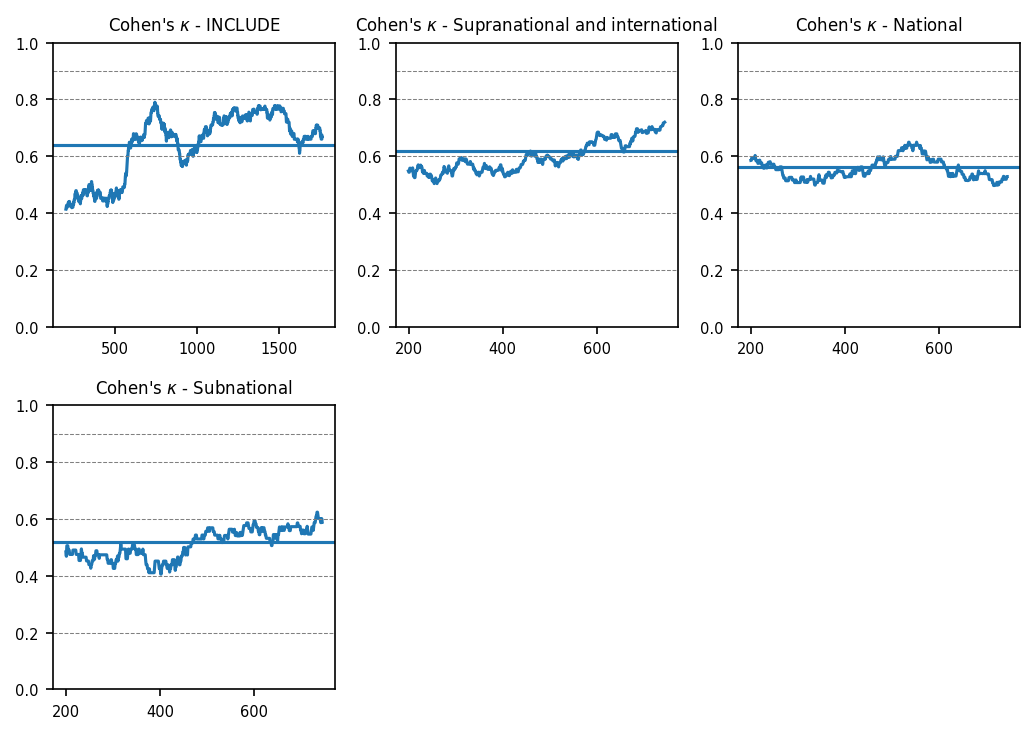

In [12]:
fig = plt.figure(figsize=(7,5), dpi=150)

sector_cats = [x for x in df["Category Name"].unique() if re.match("^17",x)]

for i,c in enumerate(["INCLUDE"] + sector_cats):
    ax = fig.add_subplot(2,3,i+1)
    ck = total_ck(ax, df, c)
    if c!="INCLUDE":
        kappa_scores.append({"category": c, "kappa": ck})
    
fig.tight_layout()

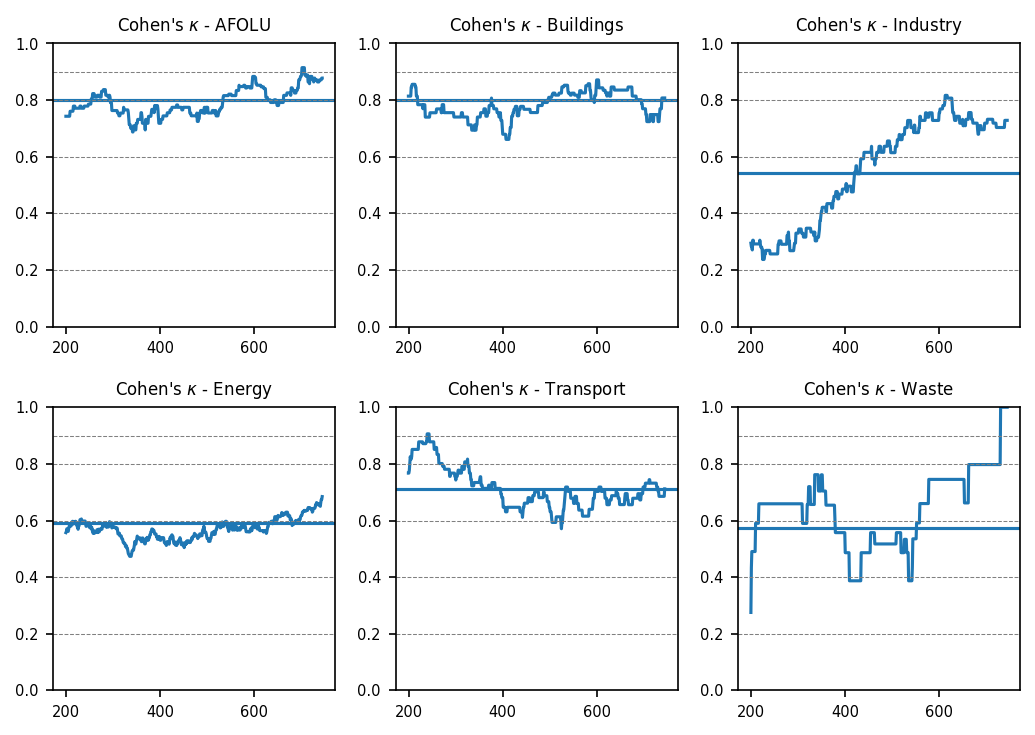

In [13]:
fig = plt.figure(figsize=(7,5), dpi=150)

sector_cats = [x for x in df["Category Name"].unique() if re.match("^8",x)][:6]

for i,c in enumerate(sector_cats):
    ax = fig.add_subplot(2,3,i+1)
    ck = total_ck(ax, df, c)
    if c!="INCLUDE":
        kappa_scores.append({"category": c, "kappa": ck})
    
fig.tight_layout()

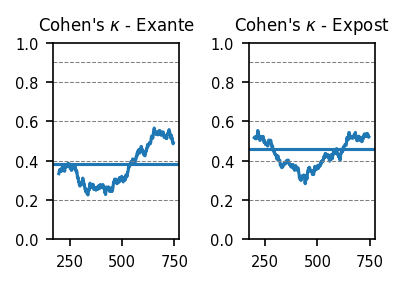

In [14]:
fig = plt.figure(figsize=(4,2), dpi=150)

cats = [x for x in df["Category Name"].unique() if re.match("^19",x)][:6]

for i,c in enumerate(cats):
    ax = fig.add_subplot(1,3,i+1)
    ck = total_ck(ax, df, c)
    if c!="INCLUDE":
        kappa_scores.append({"category": c, "kappa": ck})
    
fig.tight_layout()

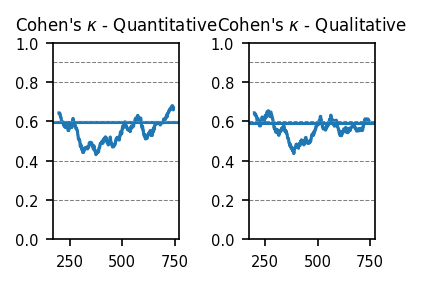

In [15]:
fig = plt.figure(figsize=(4,2), dpi=150)

cats = [x for x in df["Category Name"].unique() if re.match("^10",x)][:6]

for i,c in enumerate(cats):
    ax = fig.add_subplot(1,3,i+1)
    ck = total_ck(ax, df, c)
    if c!="INCLUDE":
        kappa_scores.append({"category": c, "kappa": ck})
    
fig.tight_layout()

In [22]:
master_df = pd.read_csv('../data/0_labelled_documents.csv')
master_df = pd.read_feather('../data/labels.feather')
print(master_df.shape)
master_df.head()

(2580, 109)


nacsos_id                                              title  \
0        156  THE EXPECTED GREENHOUSE BENEFITS FROM DEVELOPI...   
1        337  Energy forecast till 2020 for the German Gover...   
2        921  Ontology engineering in provenance enablement ...   
3       1448  Planning, governance and rural futures in Aust...   
4       3556  Will economic restructuring in China reduce tr...   

                                            abstract  0 - relevant  \
0  Magma power is the production of electricity f...           1.0   
1  A study conducted by the Prognos economic rese...           1.0   
2  The National Climate Assessment of the U.S. Gl...           1.0   
3  Rural regions in post-industrial countries con...           1.0   
4  We calculate carbon dioxide (CO2) emissions em...           1.0   

   10 - 3. Quantitative  10 - 4. Qualitative  2 - 0. Mitigation  \
0                   0.0                  0.0                1.0   
1                   0.0                  0.0                1.0   
2                   0.0                  0.0                0.0   
3                   NaN                  NaN                0.0   
4                   1.0                  1.0                1.0   

   2 - 1. Adaptation  3 - 0. Not policy related  \
0                0.0                        1.0   
1                0.0                        1.0   
2                NaN                        NaN   
3                1.0                        0.0   
4                0.0                        0.0   

   3 - 1. Analysis of an existing policy / concrete proposal  ...  \
0                                                0.0          ...   
1                                                0.0          ...   
2                                                0.0          ...   
3                                                0.0          ...   
4                                                2.0          ...   

   5 – 4.17. Government administration & management   \
0                                                  0   
1                                                  0   
2                                                  0   
3                                                  0   
4                                                  0   

   5 - 4.17. Government administration & management  representative_sample  \
0                                                 0                      0   
1                                                 0                      0   
2                                                 0                      0   
3                                                 0                      0   
4                                                 0                      0   

   representative_relevant  17 - 0. Supranational and international  \
0                        1                                      0.0   
1                        1                                      0.0   
2                        1                                      0.0   
3                        1                                      NaN   
4                        1                                      0.0   

   17 - 1. National  17 - 2. Sub-national  19 - 0. Ex-post  19 - 1. Ex-ante  \
0               0.0                   0.0              0.0              0.0   
1               0.0                   0.0              0.0              0.0   
2               0.0                   0.0              0.0              0.0   
3               NaN                   NaN              NaN              NaN   
4               1.0                   0.0              1.0              0.0   

            id  
0  W1988650910  
1          337  
2  W1992344337  
3         1448  
4  W2108062901  

[5 rows x 109 columns]

In [23]:
kdf = pd.DataFrame(kappa_scores)
kdf_n = []
kdf_ct = []
kdf_c = []
ct_dict = {
    "4": "Policy instrument I",
    "5": "Policy instrument II",
    "7": "Implementation level old",
    "17": "Implementation level",
    "8": "Sector",
    "19": "Evidence type",
    "10": "Evidence type"
}
categories = []
for i, row in kdf.iterrows():
    c = row["category"]
    cname = c.split('.')[c.count('.')]
    categories.append(cname)
    if c=="INCLUDE":
        kdf_ct.append("Inclusion")
    else:
        p = ct_dict[c.split(' -')[0]]
        if p not in kdf_ct:
            kdf_ct.append(p)
        else:
            kdf_ct.append("")
    kdf_n.append(master_df[c].sum())
kdf["Category"] = categories
kdf["n"] = kdf_n
kdf["n"] = kdf["n"].astype(int)
kdf["Category type"] = kdf_ct
kdf = kdf.set_index("Category type")
kdf["category"] = kdf["category"].str.replace("&","\\&")

kdf = kdf[["Category","kappa","n","category"]]
kdf = kdf.rename(columns={"kappa": "Cohen's k"})
kdf.to_csv('../data/agreement.csv', index=False)



ctypes = [
    "Inclusion",
    "Policy instrument I",
    "Implementation level",
    "Sector",
    "Evidence type"
]
kdf[
    (~kdf["category"].str.match("^5 -")) & 
    (~kdf["category"].str.match("^7 -"))
].drop(columns="category").reset_index().style.format(
    precision=2,
).highlight_max(
    subset=["Cohen's k"],
    props='bfseries: ;'
).hide().to_latex(
    '../tables/coding_report.tex',
    hrules=True,
    #column_format="p{0.7in}p{1.2in}rr"
)
kdf

Category  \
Category type                                                             
Inclusion                                                       INCLUDE   
Policy instrument I                                Economic instruments   
                                                 Regulatory Instruments   
                                    Information, education and training   
                                     Governance, strategies and targets   
                                                             Agreements   
Policy instrument II                                     Carbon pricing   
                                                              Subsidies   
                                                       Non-carbon taxes   
                                           Direct Investment / spending   
                                                           Trade policy   
                                                                 Quotas   
                                             Regulation on transactions   
                                               Information requirements   
                                          Spatial and land-use planning   
                                                       Other regulation   
                                                              Standards   
                                 Public Information/awareness campaigns   
                                              Behavioural interventions   
                                                 Education and training   
                       Standardized labels, reporting and accounting...   
                                         Publication of data / analysis   
                                                               Planning   
                                 Government administration & management   
                                                           Institutions   
                                                    Domestic agreements   
                                         Inter/transnational agreements   
Implementation level                    Supranational and international   
                                                               National   
                                                           Sub-national   
Sector                                                            AFOLU   
                                                              Buildings   
                                                               Industry   
                                                                 Energy   
                                                              Transport   
                                                                  Waste   
Evidence type                                                   Ex-ante   
                                                                Ex-post   
                                                           Quantitative   
                                                            Qualitative   

                      Cohen's k    n  \
Category type                          
Inclusion              0.640653  803   
Policy instrument I    0.781656  485   
                       0.491984  170   
                       0.641225   63   
                       0.425473  470   
                       0.559257  256   
Policy instrument II   0.859378  313   
                       0.703815  106   
                       0.308431   24   
                       0.418921   63   
                       0.218029    9   
                       0.455723   24   
                      -0.006871    8   
                       0.565662   14   
                       0.200600   16   
                       0.057605   13   
                       0.500245   58   
                       0.195470   15   
                       0.663661   10   
                       0.594620    8   
                       0.569781 

In [24]:
x = kdf[~kdf["category"].str.match("^5 -")].drop(columns="category").reset_index().style.format(
    precision=2,
).highlight_max(
    subset=["Category"],
    props='background-color:red; font-weight:bold;'
)

In [38]:
master_df = pd.read_feather('../data/labels.feather')


class args():
    pass
args.model_name = "allenai/scibert_scivocab_uncased"
args.model_name = "distilbert-base-uncased"
args.model_name = "climatebert"
args.y_prefix = "4 -"
args.n_splits = 3

cols = [x for x in master_df.columns if re.match(f"^{args.y_prefix}",x) and "prediction" not in x]

for c in cols:
    ct = c + " - prediction"
    master_df[ct] = np.NaN

for k in range(args.n_splits):
    yp = np.load(f"../cluster-experiments/cv_results/{args.model_name.replace('/','__')}__{args.y_prefix}__{k}__outer_predictions.npy")
    ids = np.load(f"../cluster-experiments/cv_results/{args.model_name.replace('/','__')}__{args.y_prefix}__{k}__outer_ids.npy", allow_pickle=True)
    mdf = pd.DataFrame(yp)
    mdf.columns=[x + " - prediction" for x in cols]
    
    mdf['id'] = ids
    mdf = mdf.set_index('id')
    
    master_df = master_df.set_index("id")
    master_df.update(mdf)
    master_df = master_df.reset_index()

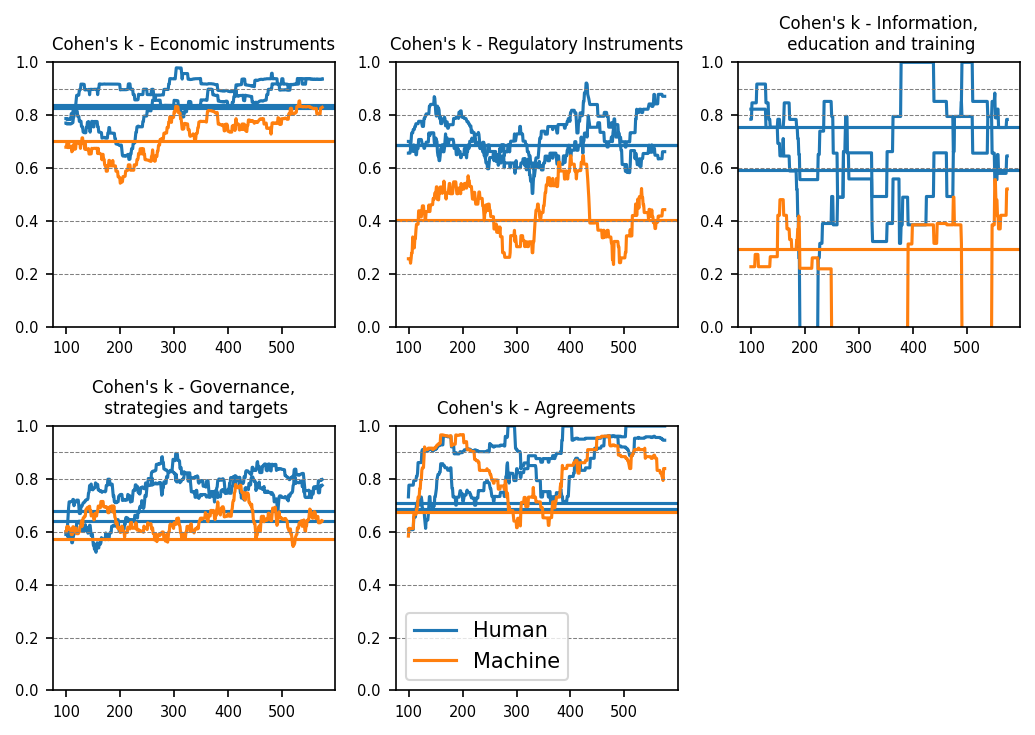

In [59]:
from sklearn.metrics import f1_score


window = 100

fig = plt.figure(figsize=(7,5), dpi=150)

def total_f1(ax, df, master_df, c):
    ct = c + " - prediction"
    f1func = lambda a1, a2: f1_score(a2,a1)
    df['coder'] = df.groupby(['doc__id','Category Name'])['value'].cumcount()
    pdf = df[df['Category Name']==c]
    pdf = (
        pdf[(pdf['coder']<2)]
        .pivot(index="doc__id",columns="coder",values="value").reset_index()
        .merge(order_df,left_on="doc__id",right_on="doc_id")
        .sort_values('order')
        .merge(master_df[['nacsos_id',c,ct]],left_on='doc__id',right_on="nacsos_id")
        .dropna()
    )
    for coder in [0,1]:
        if coder==0:
            label = "Human"
        else:
            label = None
        f1r = rolling_apply_ext(ckfunc, window, pdf[c].astype(int).values, pdf[coder].astype(int).values)
        f1 = cohen_kappa_score(pdf[c].astype(int).values, pdf[coder].astype(int).values)
        ax.plot(f1r, color="C0", label=label)
        ax.axhline(f1, color="C0")
    f1r = rolling_apply_ext(ckfunc, window, pdf[c].astype(int).values, round(pdf[ct]).astype(int).values)
    f1 = cohen_kappa_score(pdf[c].astype(int).values, round(pdf[ct]).astype(int).values)
    ax.plot(f1r, color="C1", label="Machine")
    ax.axhline(f1, color="C1")
    ax.xaxis.set_tick_params(labelsize=7)
    ax.yaxis.set_tick_params(labelsize=7)
    
    ax.set_ylim(0,1)
    for t,ag in [(0,"None"),(0.2,"Minimal"),(0.4,"Weak"),(0.6,"Moderate"),(0.8,"Strong"),(0.9,"Almost Perfect")]:
        ax.axhline(t,color="grey",ls="--",lw=0.5)
        
    c = re.sub("[^a-zA-Z ,]","",c).strip().replace(',',',\n')
    
    ax.set_title(f"Cohen's k - {c}", fontsize=8)


for i,c in enumerate(cols):
    ax = fig.add_subplot(2,3,i+1)
    total_f1(ax, df, master_df, c)
    
ax.legend()
    
fig.tight_layout()

[1 0]
[0 1]
[0 1]
[0 1]
[0 1]


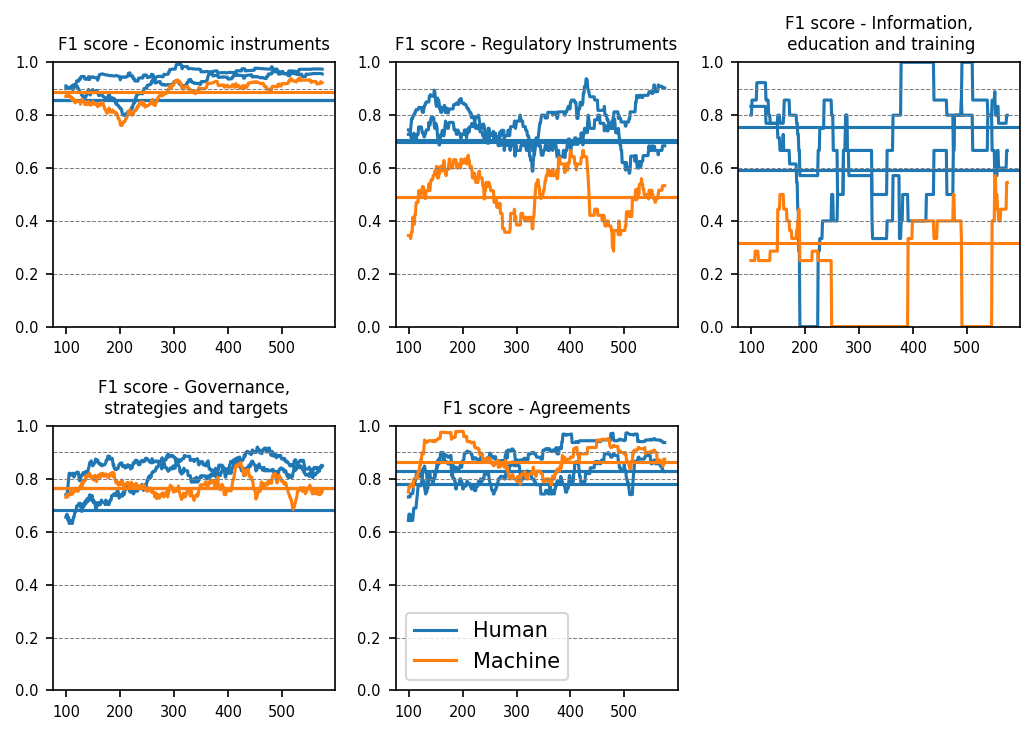

In [68]:
from sklearn.metrics import f1_score


window = 100

fig = plt.figure(figsize=(7,5), dpi=150)

f1func = lambda a1, a2: f1_score(a1,a2)


def total_f1(ax, df, master_df, c):
    master_df[c] = master_df[c].replace(2,1)
    ct = c + " - prediction"
    f1func = lambda a1, a2: f1_score(a2,a1)
    df['coder'] = df.groupby(['doc__id','Category Name'])['value'].cumcount()
    pdf = df[df['Category Name']==c]
    pdf = (
        pdf[(pdf['coder']<2)]
        .pivot(index="doc__id",columns="coder",values="value").reset_index()
        .merge(order_df,left_on="doc__id",right_on="doc_id")
        .sort_values('order')
        .merge(master_df[['nacsos_id',c,ct]],left_on='doc__id',right_on="nacsos_id")
        .dropna()
    )
    for coder in [0,1]:
        if coder==0:
            label = "Human"
        else:
            label = None
        f1r = rolling_apply_ext(f1func, window, pdf[c].astype(int).values, pdf[coder].astype(int).values)
        f1 = cohen_kappa_score(pdf[c].astype(int).values, pdf[coder].astype(int).values)
        ax.plot(f1r, color="C0", label=label)
        ax.axhline(f1, color="C0")
    f1r = rolling_apply_ext(f1func, window, pdf[c].astype(int).values, round(pdf[ct]).astype(int).values)
    print(pdf[c].astype(int).unique())
    f1 = f1_score(pdf[c].astype(int).values, round(pdf[ct]).astype(int).values)
    ax.plot(f1r, color="C1", label="Machine")
    ax.axhline(f1, color="C1")
    ax.xaxis.set_tick_params(labelsize=7)
    ax.yaxis.set_tick_params(labelsize=7)
    
    ax.set_ylim(0,1)
    for t,ag in [(0,"None"),(0.2,"Minimal"),(0.4,"Weak"),(0.6,"Moderate"),(0.8,"Strong"),(0.9,"Almost Perfect")]:
        ax.axhline(t,color="grey",ls="--",lw=0.5)
        
    c = re.sub("[^a-zA-Z ,]","",c).strip().replace(',',',\n')
    
    ax.set_title(f"F1 score - {c}", fontsize=8)


for i,c in enumerate(cols):
    ax = fig.add_subplot(2,3,i+1)
    total_f1(ax, df, master_df, c)
    
ax.legend()
    
fig.tight_layout()

In [28]:


class args():
    pass
args.model_name = "allenai/scibert_scivocab_uncased"
args.model_name = "distilbert-base-uncased"
args.model_name = "climatebert__distilroberta-base-climate-f"
args.y_prefix = "4 -"
args.n_splits = 3
nonrandom = "_nonrandom"
   
df_len = 588
cols = [x for x in master_df.columns if re.match(f"^{args.y_prefix}",x)]

for c in cols:
    ct = c + " - prediction"
    master_df[ct] = np.NaN

for k in range(args.n_splits):
    yp = np.load(f"../cluster-experiments/cv/df_{df_len}_y_preds{nonrandom}_{args.y_prefix}_{args.model_name.replace('/','__')}_{k}.npy")
    ids = np.load(f"../cluster-experiments/cv/df_{df_len}_y_pred{nonrandom}_ids_{args.y_prefix}_{args.model_name.replace('/','__')}_{k}.npy")
    
    mdf = pd.DataFrame(yp)
    mdf.columns=[x + " - prediction" for x in cols]
    
    mdf['id'] = ids
    mdf = mdf.set_index('id')

    master_df = master_df.set_index("id")
    master_df.update(mdf)
    master_df = master_df.reset_index()
    
args.y_prefix = "INCLUDE"
df_len = 2512
cols = [x for x in master_df.columns if re.match(f"^{args.y_prefix}",x)]

nonrandom = ""

for c in cols:
    ct = c + " - prediction"
    master_df[ct] = np.NaN

for k in range(args.n_splits):
    yp = np.load(f"cluster-experiments/cv/{args.model_name.replace('/','__')}__{args.y_prefix}__{k}__outer_predictions.npy")
    continue
    ids = np.load(f"cluster-experiments/cv/df_{df_len}_y_pred{nonrandom}_ids_{args.y_prefix}_{args.model_name.replace('/','__')}_{k}.npy")
    
    mdf = pd.DataFrame(yp)
    mdf.columns=[x + " - prediction" for x in cols]
    
    mdf['id'] = ids
    mdf = mdf.set_index('id')

    master_df = master_df.set_index("id")
    master_df.update(mdf)
    master_df = master_df.reset_index()

master_df.head()

FileNotFoundError: [Errno 2] No such file or directory: '../cluster-experiments/cv/df_588_y_preds_nonrandom_4 -_climatebert__distilroberta-base-climate-f_0.npy'

In [19]:
master_df[pd.notna(master_df['INCLUDE - prediction'])]

id                                              title  \
5        3679  Forcing and response in simulated 20th and 21s...   
6        3683  Egeson's (George's) transtridecadal weather cy...   
10       5459  Vegetation structure and biodiversity along th...   
15      10677  Permanent salt evaporation ponds in a semi-ari...   
17      12788  Consistent sampling methods for comparing mode...   
...       ...                                                ...   
2563  3875963  Do actions speak louder than words? Comparing ...   
2567  3876825  Understanding the origins and variability of t...   
2571  3878125  Remote Sensing Applications in Monitoring of P...   
2573  3878138  Assessing New Biotechnologies by Combining TEA...   
2576  3878350  Analysis of the Theoretical and Practical Ener...   

                                                content  0 - relevant  \
5     A simple methodology is applied to a transient...           1.0   
6     In the late 19th century, Charles Egeson, a ma...           0.0   
10    The deep lateritic earths that cap the serpent...           0.0   
15    A change from planktonic to benthic primary pr...           0.0   
17    We address the issue of how to compare atmosph...          -1.0   
...                                                 ...           ...   
2563  In this article, we empirically examine whethe...           0.0   
2567  Background: Divergence in fuel consumption (FC...           1.0   
2571  Protected areas (PAs) have been established wo...           1.0   
2573  An efficient use of biomass resources is a key...           0.0   
2576  This paper derives from first principles simpl...           1.0   

      10 - 3. Quantitative  10 - 4. Qualitative  2 - 0. Mitigation  \
5                      0.0                  0.0                0.0   
6                      0.0                  0.0                0.0   
10                     NaN                  NaN                0.0   
15                     NaN                  NaN                0.0   
17                     0.0                  0.0                0.0   
...                    ...                  ...                ...   
2563                   NaN                  NaN                0.0   
2567                   1.0                  0.0                1.0   
2571                   0.0                  0.0                0.0   
2573                   NaN                  NaN                0.0   
2576                   0.0                  0.0                1.0   

      2 - 1. Adaptation  3 - 0. Not policy related  \
5                   0.0                        1.0   
6                   0.0                        0.0   
10                  0.0                        0.0   
15                  0.0                        0.0   
17                  0.0                        1.0   
...                 ...                        ...   
2563                0.0                        0.0   
2567                0.0                        0.0   
2571                0.0                        1.0   
2573                0.0                        0.0   
2576                0.0                        1.0   

      3 - 1. Analysis of an existing policy / concrete proposal  ...  \
5                                                   0.0          ...   
6                                                   0.0          ...   
10                                                  0.0          ...   
15                                                  0.0          ...   
17                                                  0.0          ...   
...                                                 ...          ...   
2563                                                0.0          ...   
2567                                                0.0          ...   
2571                                                0.0          ...   
2573                                                0.0          ...   
2576                               

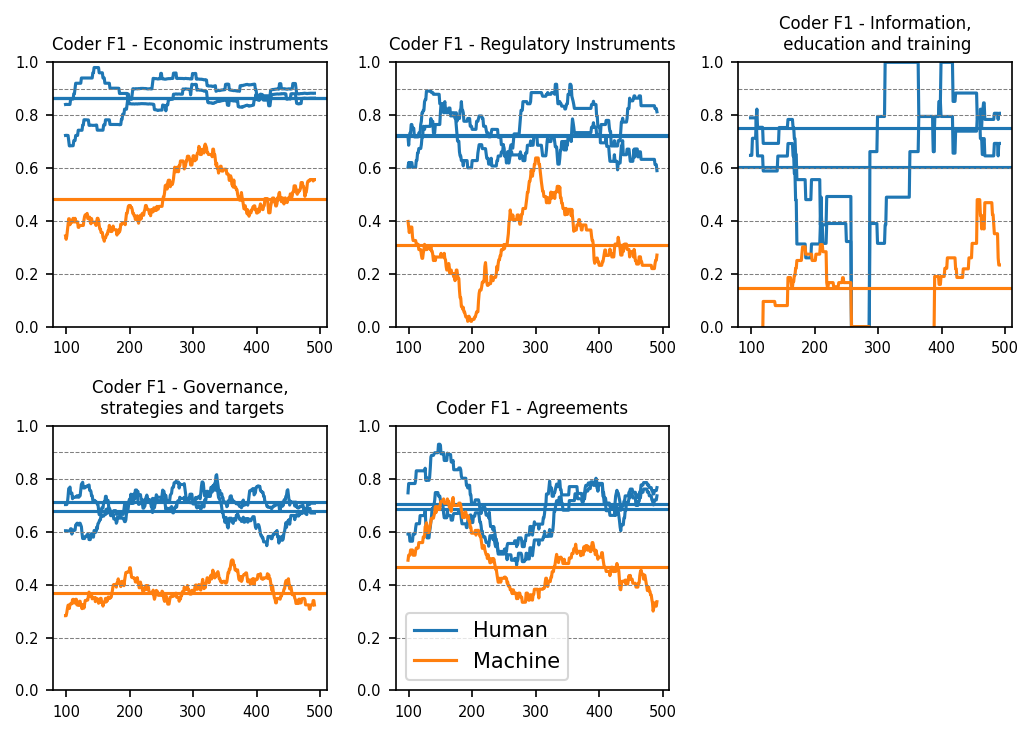

In [20]:
from sklearn.metrics import f1_score


window = 100

fig = plt.figure(figsize=(7,5), dpi=150)

def total_f1(ax, df, master_df, c):
    ct = c + " - prediction"
    f1func = lambda a1, a2: f1_score(a2,a1)
    df['coder'] = df.groupby(['doc__id','Category Name'])['value'].cumcount()
    pdf = df[df['Category Name']==c]
    pdf = (
        pdf[(pdf['coder']<2)]
        .pivot(index="doc__id",columns="coder",values="value").reset_index()
        .merge(order_df,left_on="doc__id",right_on="doc_id")
        .sort_values('order')
        .merge(master_df[['id',c,ct]],left_on='doc__id',right_on="id")
        .dropna()
    )
    for coder in [0,1]:
        if coder==0:
            label = "Human"
        else:
            label = None
        f1r = rolling_apply_ext(ckfunc, window, pdf[c].astype(int).values, pdf[coder].astype(int).values)
        f1 = cohen_kappa_score(pdf[c].astype(int).values, pdf[coder].astype(int).values)
        ax.plot(f1r, color="C0", label=label)
        ax.axhline(f1, color="C0")
    f1r = rolling_apply_ext(ckfunc, window, pdf[c].astype(int).values, round(pdf[ct]).astype(int).values)
    f1 = cohen_kappa_score(pdf[c].astype(int).values, round(pdf[ct]).astype(int).values)
    ax.plot(f1r, color="C1", label="Machine")
    ax.axhline(f1, color="C1")
    ax.xaxis.set_tick_params(labelsize=7)
    ax.yaxis.set_tick_params(labelsize=7)
    
    ax.set_ylim(0,1)
    for t,ag in [(0,"None"),(0.2,"Minimal"),(0.4,"Weak"),(0.6,"Moderate"),(0.8,"Strong"),(0.9,"Almost Perfect")]:
        ax.axhline(t,color="grey",ls="--",lw=0.5)
        
    c = re.sub("[^a-zA-Z ,]","",c).strip().replace(',',',\n')
    
    ax.set_title(f"Coder F1 - {c}", fontsize=8)


for i,c in enumerate(c1_cats):
    ax = fig.add_subplot(2,3,i+1)
    total_f1(ax, df, master_df, c)
    
ax.legend()
    
fig.tight_layout()

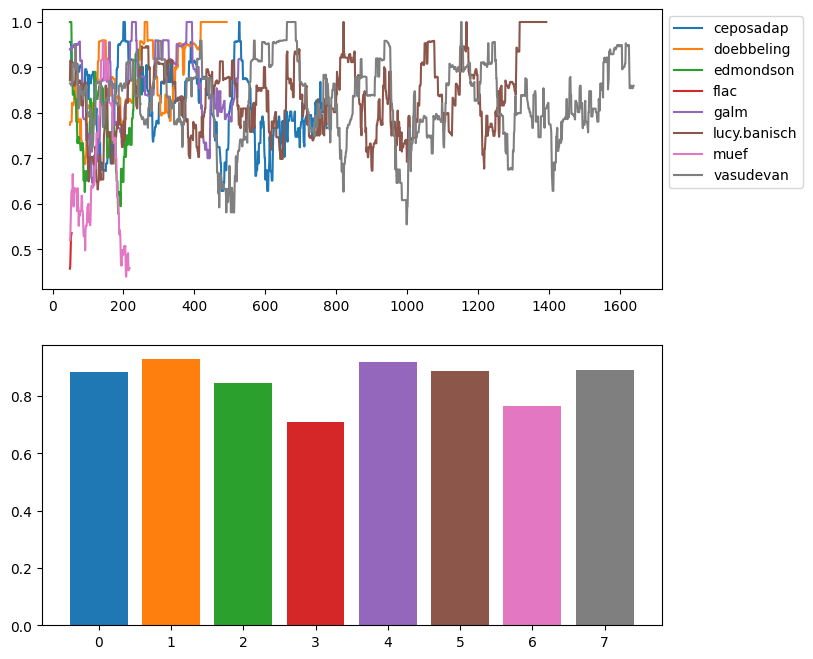

In [21]:
c = "INCLUDE"

fig, axs = plt.subplots(2,figsize=(8,8))

from sklearn.metrics import f1_score

f1func = lambda a1, a2: f1_score(a2,a1)

window = 50

f1s = []
i = 0
for name, group in df[df['Category Name']==c].groupby('user__username'):
    pdf = group.merge(master_df[['id',c]],left_on='doc__id',right_on="id").dropna()
    if pdf.shape[0]<window:
        continue
    else:
        ckr = rolling_apply_ext(ckfunc, window, pdf['value'].astype(int).values, pdf[c].astype(int).values)
        axs[0].plot(ckr,label=f"{name.split('@')[0]}")
        f1 = f1_score(pdf[c].astype(int).values,pdf['value'].astype(int).values)
        axs[1].bar(i,f1,label=f"{name.split('@')[0]}")
        f1s.append(f1)
        i+=1
    

axs[0].legend(bbox_to_anchor=(1,1))
plt.show()

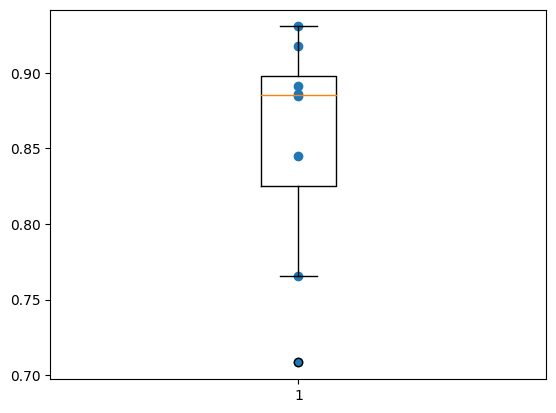

In [22]:
fig, ax = plt.subplots()

ax.boxplot(f1s)
ax.scatter([1]*len(f1s),f1s)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


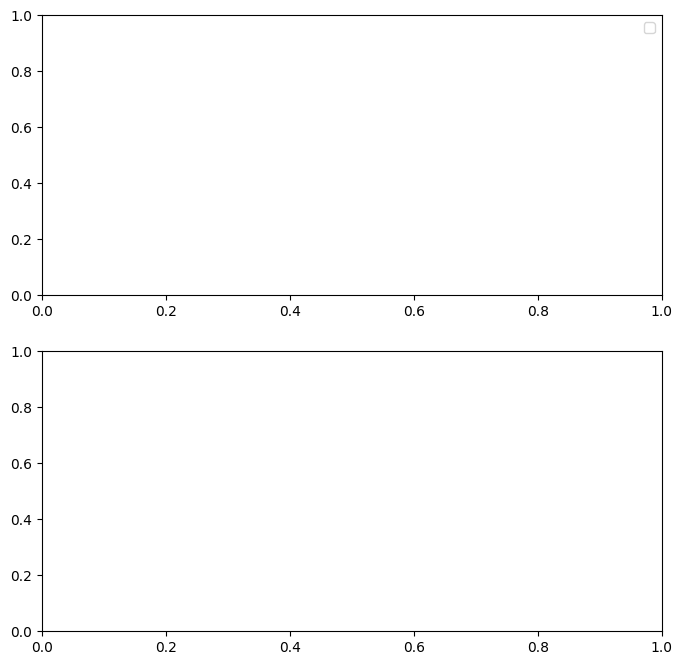

In [23]:
import itertools
pairs = list(itertools.combinations(dodf['user__username'].unique(),2))
pairs

c = "4 - 1. Economic instruments"

from sklearn.metrics import cohen_kappa_score
from numpy_ext import rolling_apply as rolling_apply_ext
ckfunc = lambda a1, a2: cohen_kappa_score(a1,a2)

fig, axs = plt.subplots(2,figsize=(8,8))

i = 0

for p in pairs:
    sub_df = df[df['Category Name']==c].dropna()
    d1 = sub_df[(sub_df['user__username']==p[0]) & (sub_df['Category Name']==c)].rename(columns={"value":p[0]}).drop(columns="user__username")
    d2 = sub_df[(sub_df['user__username']==p[1]) & (sub_df['Category Name']==c)].rename(columns={"value":p[1]}).drop(columns="user__username")
    
    pdf = (d1.merge(d2,how="inner")
           .merge(order_df,left_on="doc__id",right_on="doc_id")
           .sort_values('order')
           .reset_index(drop=True)
           .fillna(1)
          )

    if pdf.shape[0]<100:
        continue
    else:
        ckr = rolling_apply_ext(ckfunc, 100, pdf[p[0]].astype(int).values, pdf[p[1]].astype(int).values)
        axs[0].plot(ckr,label=f"{p[0].split('@')[0]}-{p[1].split('@')[0]}")
        ck = cohen_kappa_score(pdf[p[0]],pdf[p[1]])
        axs[1].bar(i,ck,label=f"{p[0].split('@')[0]}-{p[1].split('@')[0]}")
        i+=1
        
        
axs[0].legend(bbox_to_anchor=(1,1))
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


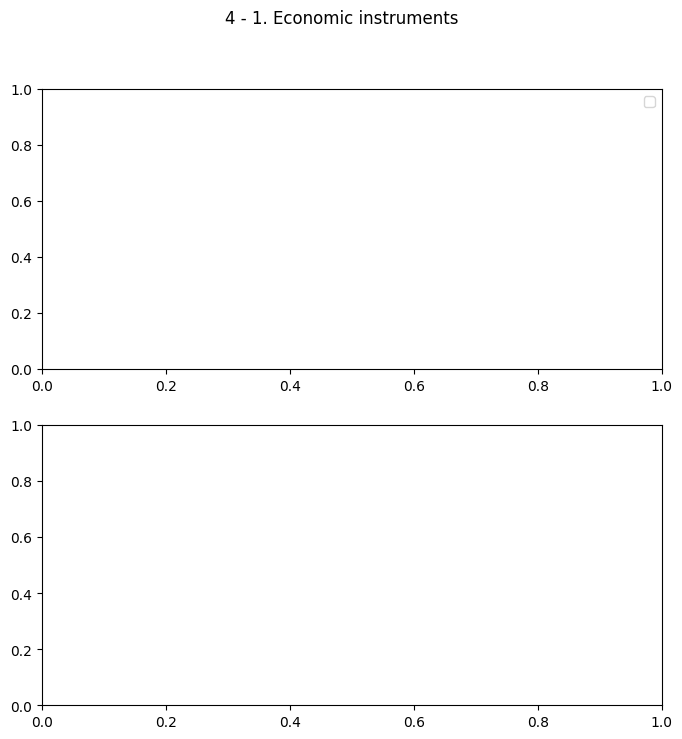

In [24]:
c = "4 - 1. Economic instruments"


sub_df = df[df['Category Name']==c].dropna()

fig, axs = plt.subplots(2,figsize=(8,8)) 

for p in pairs:

    d1 = sub_df[(sub_df['user__username']==p[0]) & (sub_df['Category Name']==c)].rename(columns={"value":p[0]}).drop(columns="user__username")
    d2 = sub_df[(sub_df['user__username']==p[1]) & (sub_df['Category Name']==c)].rename(columns={"value":p[1]}).drop(columns="user__username")

    pdf = (d1.merge(d2,how="inner")
           .merge(order_df,left_on="doc__id",right_on="doc_id")
           .sort_values('order')
           .reset_index(drop=True)
           #.fillna(1)
          )


    if pdf.shape[0]<50:
        continue
    else:

        ckr = rolling_apply_ext(ckfunc, 50, pdf[p[0]].astype(int).values, pdf[p[1]].astype(int).values)
        axs[0].plot(ckr,label=f"{p[0].split('@')[0]}-{p[1].split('@')[0]}")
        ck = cohen_kappa_score(pdf[p[0]].astype(int).values,pdf[p[1]].astype(int).values)
        axs[1].bar(i,ck,label=f"{p[0].split('@')[0]}-{p[1].split('@')[0]}")
        i+=1
        axs[0].set_ylim(-1,1)

        for ax in axs:
            ax.set_ylim(0,1)
            for t,ag in [(0,"None"),(0.2,"Minimal"),(0.4,"Weak"),(0.6,"Moderate"),(0.8,"Strong"),(0.9,"Almost Perfect")]:
                ax.axhline(t,color="grey",ls="--",lw=0.5)


axs[0].legend(bbox_to_anchor=(1,1))
plt.suptitle(c)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


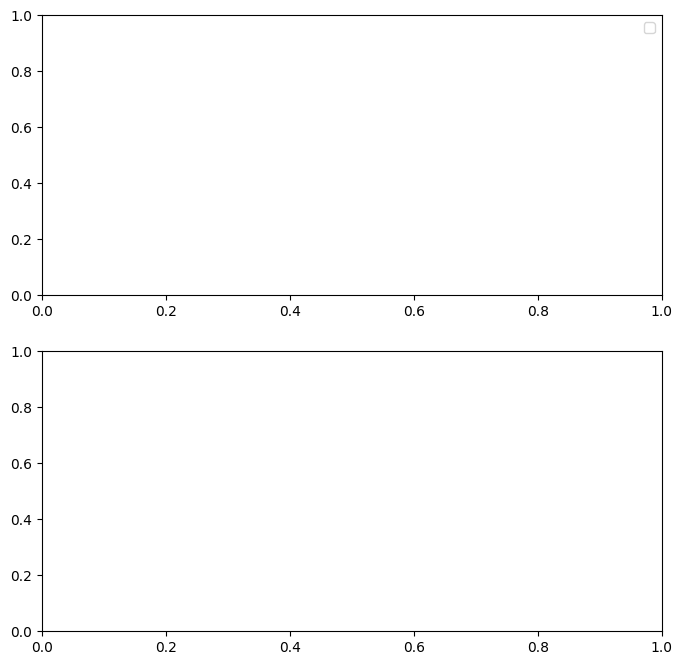

In [25]:
import itertools
pairs = list(itertools.combinations(dodf['user__username'].unique(),2))
pairs

c = "5 - 1.02. Carbon pricing"

from sklearn.metrics import cohen_kappa_score
from numpy_ext import rolling_apply as rolling_apply_ext
ckfunc = lambda a1, a2: cohen_kappa_score(a1,a2)

fig, axs = plt.subplots(2,figsize=(8,8))

i = 0

for p in pairs:
    sub_df = df
    d1 = sub_df[(sub_df['user__username']==p[0]) & (sub_df['Category Name']==c)].rename(columns={"value":p[0]}).drop(columns="user__username")
    d2 = sub_df[(sub_df['user__username']==p[1]) & (sub_df['Category Name']==c)].rename(columns={"value":p[1]}).drop(columns="user__username")
    
    pdf = (d1.merge(d2,how="inner")
           .merge(order_df,left_on="doc__id",right_on="doc_id")
           .sort_values('order')
           .reset_index(drop=True)
           .fillna(1)
          )

    if pdf.shape[0]<100:
        continue
    else:
        ckr = rolling_apply_ext(ckfunc, 100, pdf[p[0]].astype(int).values, pdf[p[1]].astype(int).values)
        axs[0].plot(ckr,label=f"{p[0].split('@')[0]}-{p[1].split('@')[0]}")
        ck = cohen_kappa_score(pdf[p[0]],pdf[p[1]])
        axs[1].bar(i,ck,label=f"{p[0].split('@')[0]}-{p[1].split('@')[0]}")
        i+=1
        
        
axs[0].legend(bbox_to_anchor=(1,1))
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


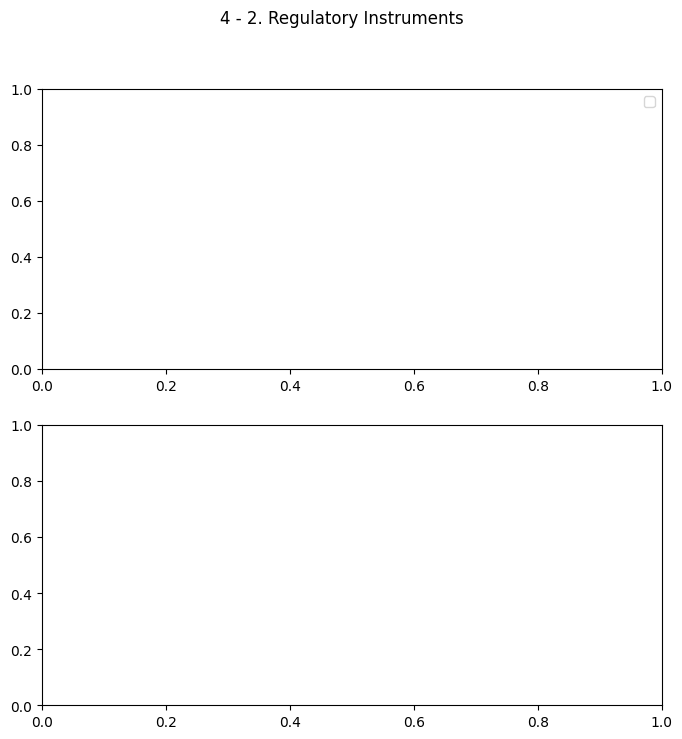

In [26]:
import itertools
pairs = list(itertools.combinations(dodf['user__username'].unique(),2))
pairs

c = "4 - 2. Regulatory Instruments"

from sklearn.metrics import cohen_kappa_score
from numpy_ext import rolling_apply as rolling_apply_ext
ckfunc = lambda a1, a2: cohen_kappa_score(a1,a2)

fig, axs = plt.subplots(2,figsize=(8,8))

i = 0

for p in pairs:
    sub_df = df
    d1 = sub_df[(sub_df['user__username']==p[0]) & (sub_df['Category Name']==c)].rename(columns={"value":p[0]}).drop(columns="user__username")
    d2 = sub_df[(sub_df['user__username']==p[1]) & (sub_df['Category Name']==c)].rename(columns={"value":p[1]}).drop(columns="user__username")
    
    pdf = (d1.merge(d2,how="inner")
           .merge(order_df,left_on="doc__id",right_on="doc_id")
           .sort_values('order')
           .reset_index(drop=True)
           .fillna(1)
          )

    if pdf.shape[0]<100:
        continue
    else:
        ckr = rolling_apply_ext(ckfunc, 100, pdf[p[0]].astype(int).values, pdf[p[1]].astype(int).values)
        axs[0].plot(ckr,label=f"{p[0].split('@')[0]}-{p[1].split('@')[0]}")
        ck = cohen_kappa_score(pdf[p[0]],pdf[p[1]])
        axs[1].bar(i,ck,label=f"{p[0].split('@')[0]}-{p[1].split('@')[0]}")
        i+=1
        axs[0].set_ylim(-1,1)
        
        for ax in axs:
            ax.set_ylim(0,1)
            for t,ag in [(0,"None"),(0.2,"Minimal"),(0.4,"Weak"),(0.6,"Moderate"),(0.8,"Strong"),(0.9,"Almost Perfect")]:
                ax.axhline(t,color="grey",ls="--",lw=0.5)
        
        
axs[0].legend(bbox_to_anchor=(1,1))
plt.suptitle(c)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


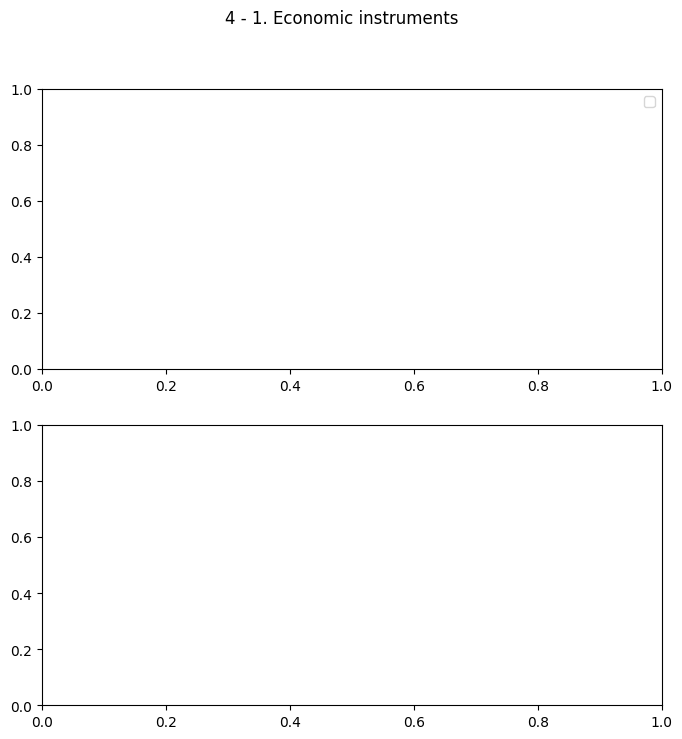

In [27]:
c = "4 - 1. Economic instruments"


sub_df = df[df['Category Name']==c].dropna()



fig, axs = plt.subplots(2,figsize=(8,8)) 

for p in pairs:

    d1 = sub_df[(sub_df['user__username']==p[0]) & (sub_df['Category Name']==c)].rename(columns={"value":p[0]}).drop(columns="user__username")
    d2 = sub_df[(sub_df['user__username']==p[1]) & (sub_df['Category Name']==c)].rename(columns={"value":p[1]}).drop(columns="user__username")

    pdf = (d1.merge(d2,how="inner")
           .merge(order_df,left_on="doc__id",right_on="doc_id")
           .sort_values('order')
           .reset_index(drop=True)
           #.fillna(1)
          )


    if pdf.shape[0]<50:
        continue
    else:

        ckr = rolling_apply_ext(ckfunc, 50, pdf[p[0]].astype(int).values, pdf[p[1]].astype(int).values)
        axs[0].plot(ckr,label=f"{p[0].split('@')[0]}-{p[1].split('@')[0]}")
        ck = cohen_kappa_score(pdf[p[0]].astype(int).values,pdf[p[1]].astype(int).values)
        axs[1].bar(i,ck,label=f"{p[0].split('@')[0]}-{p[1].split('@')[0]}")
        i+=1
        axs[0].set_ylim(-1,1)

        for ax in axs:
            ax.set_ylim(0,1)
            for t,ag in [(0,"None"),(0.2,"Minimal"),(0.4,"Weak"),(0.6,"Moderate"),(0.8,"Strong"),(0.9,"Almost Perfect")]:
                ax.axhline(t,color="grey",ls="--",lw=0.5)


axs[0].legend(bbox_to_anchor=(1,1))
plt.suptitle(c)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


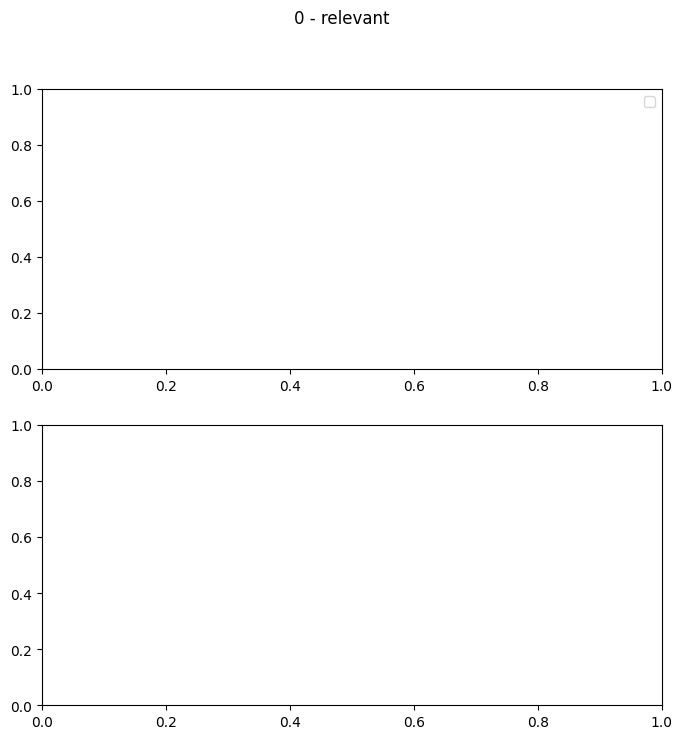

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


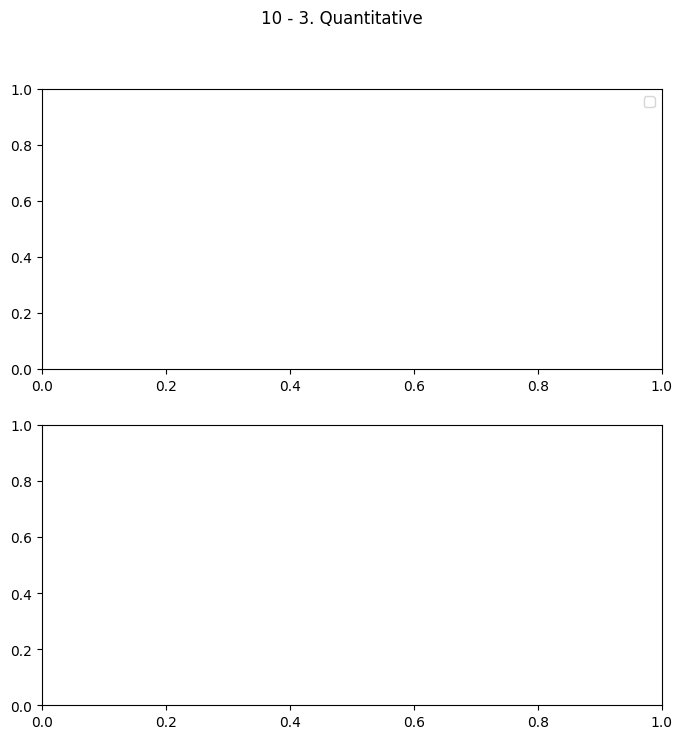

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


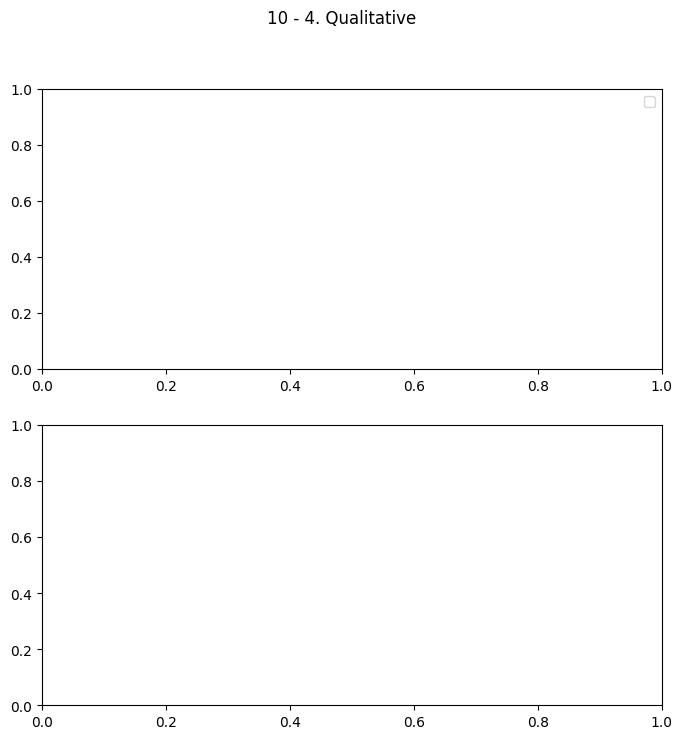

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


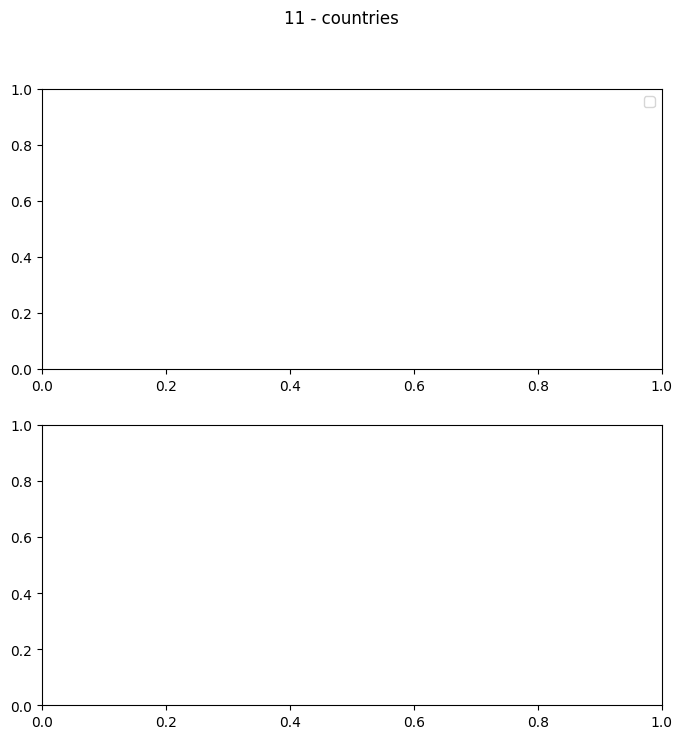

12 - policy name


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


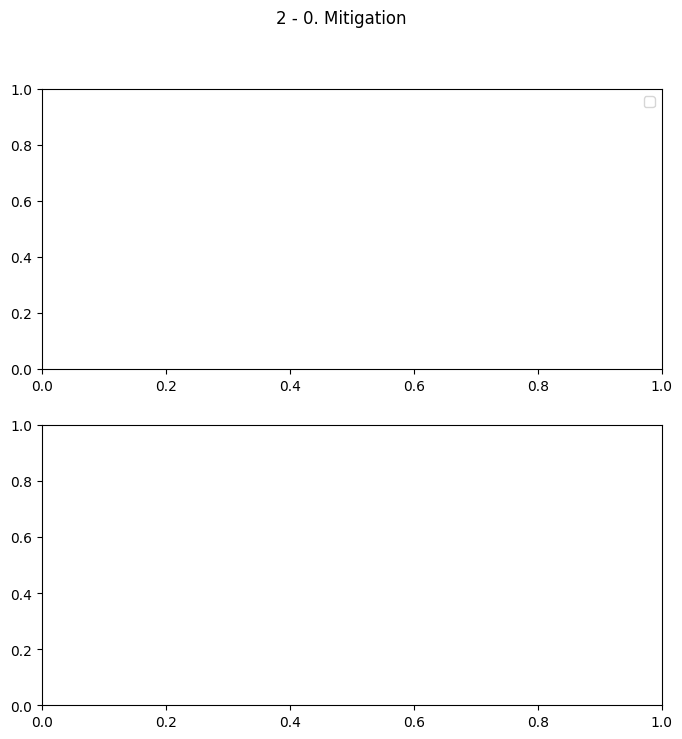

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


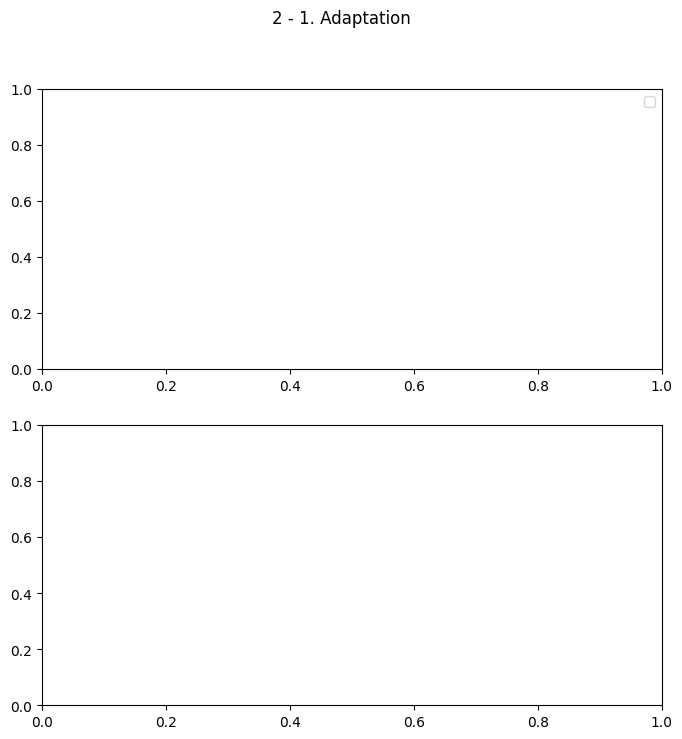

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


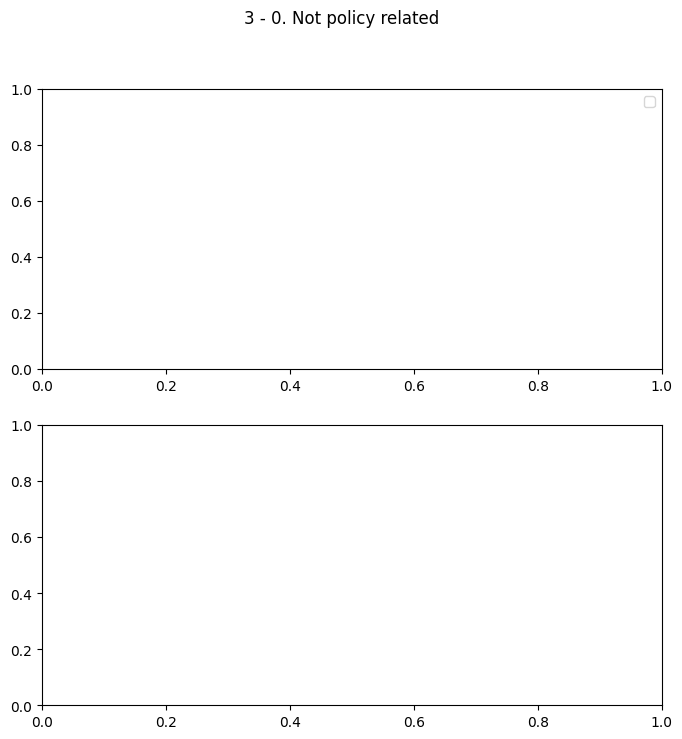

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


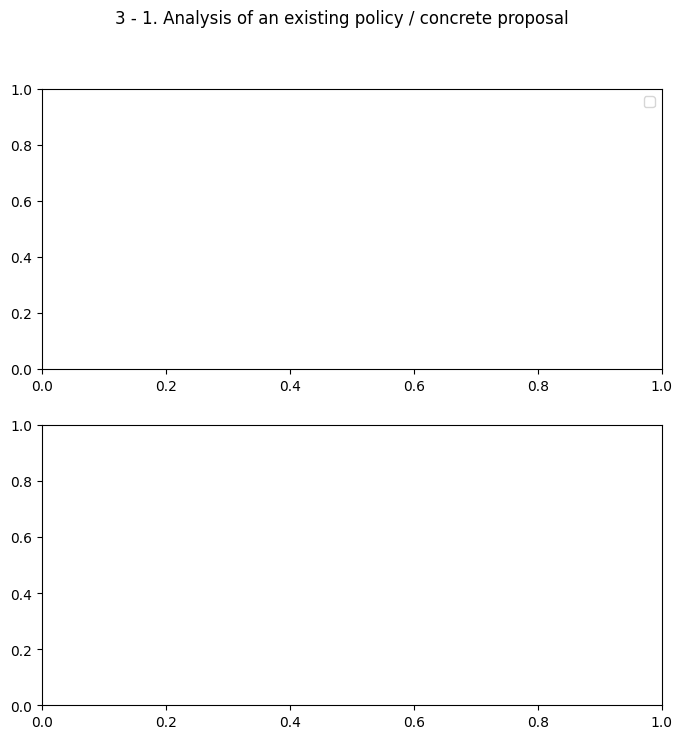

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


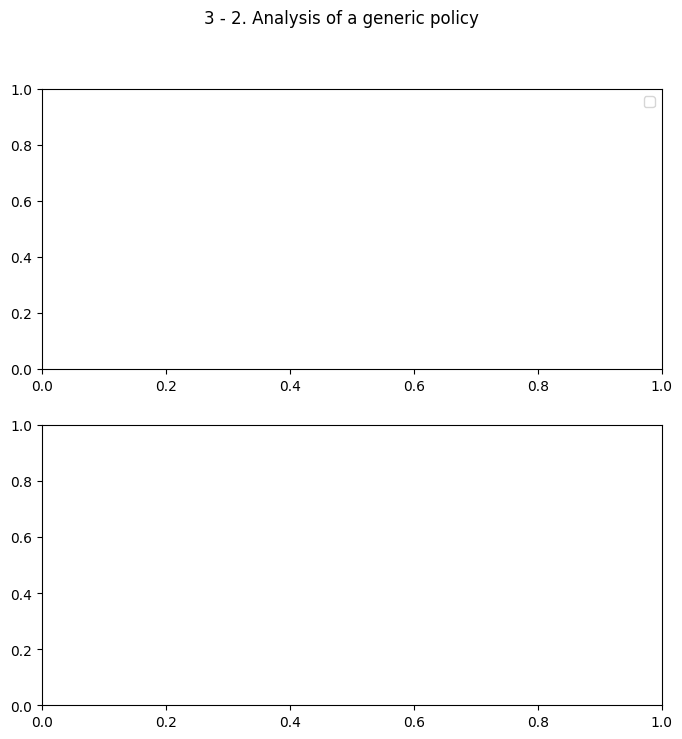

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


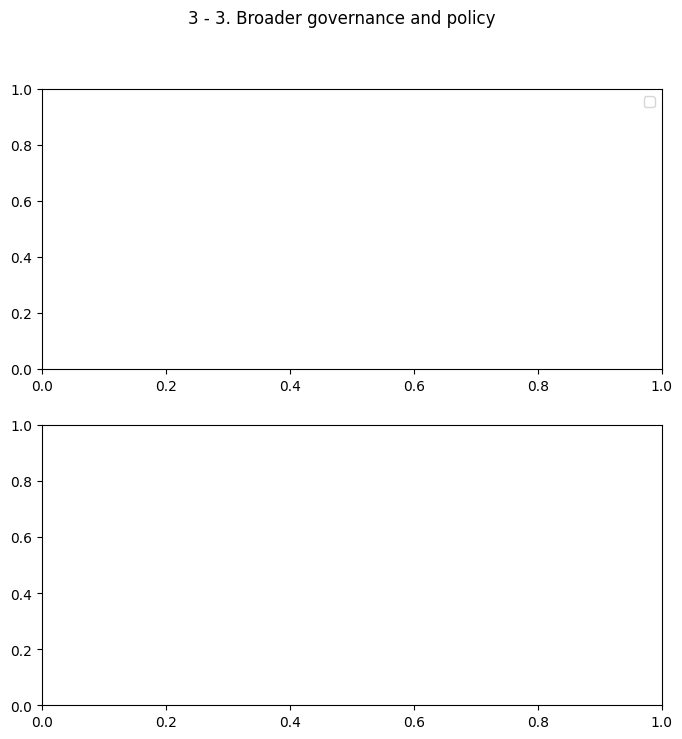

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


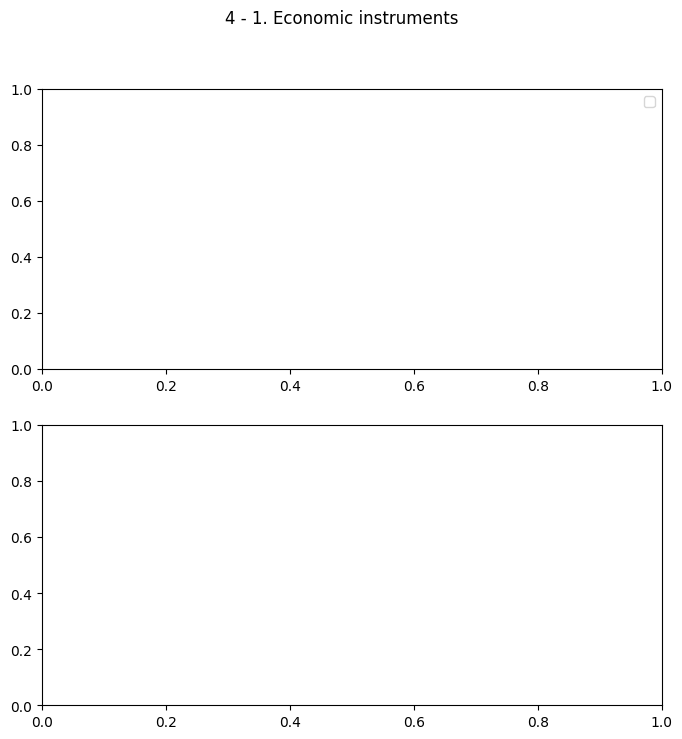

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


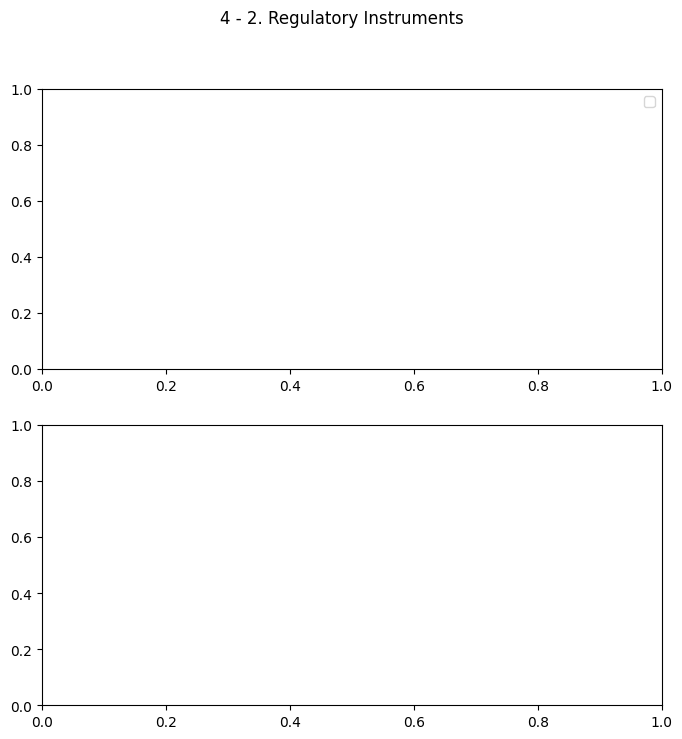

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


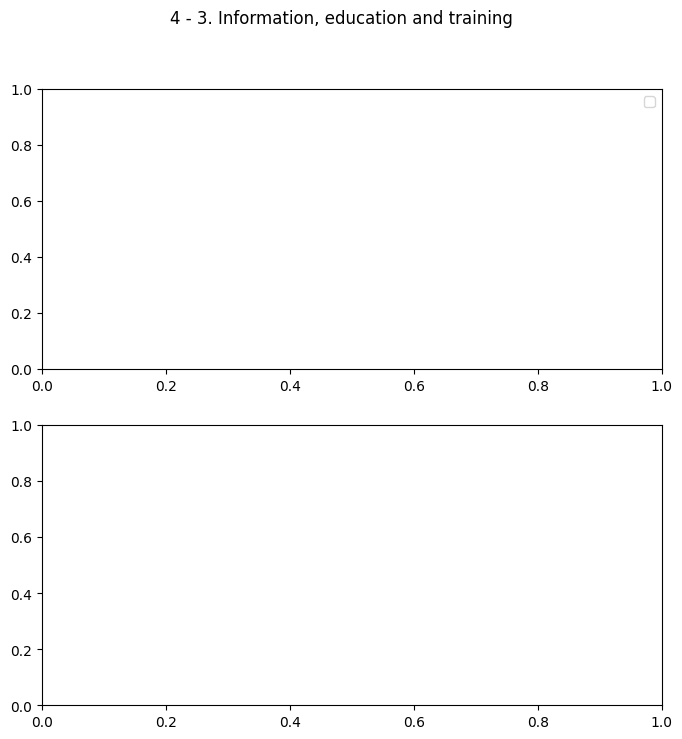

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


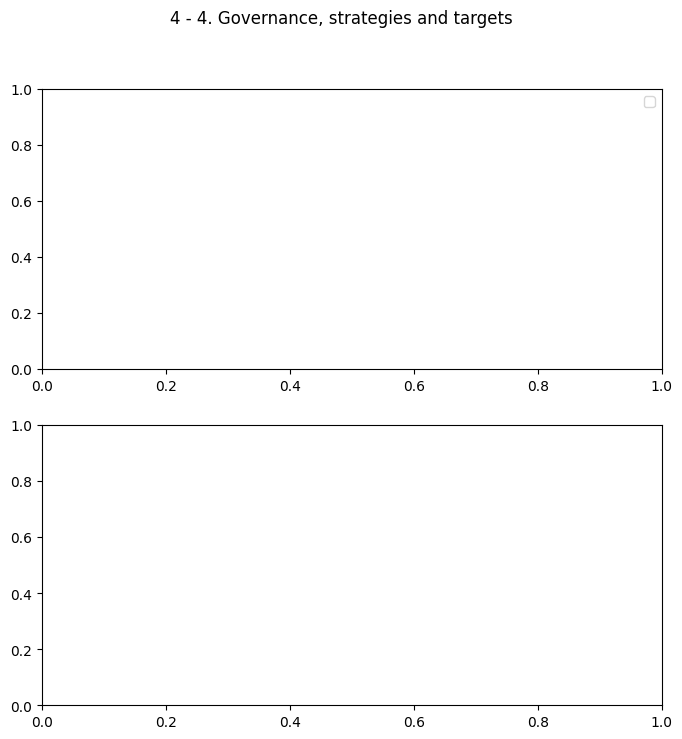

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


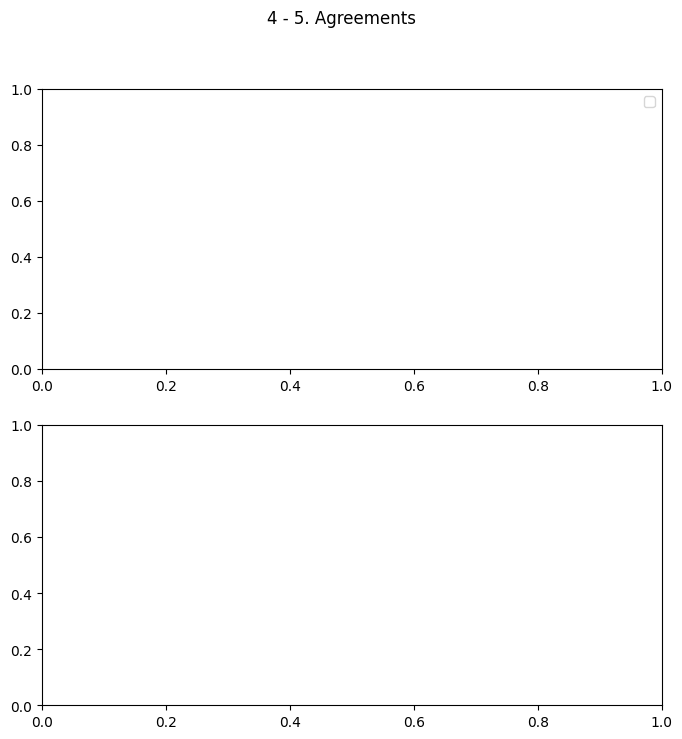

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


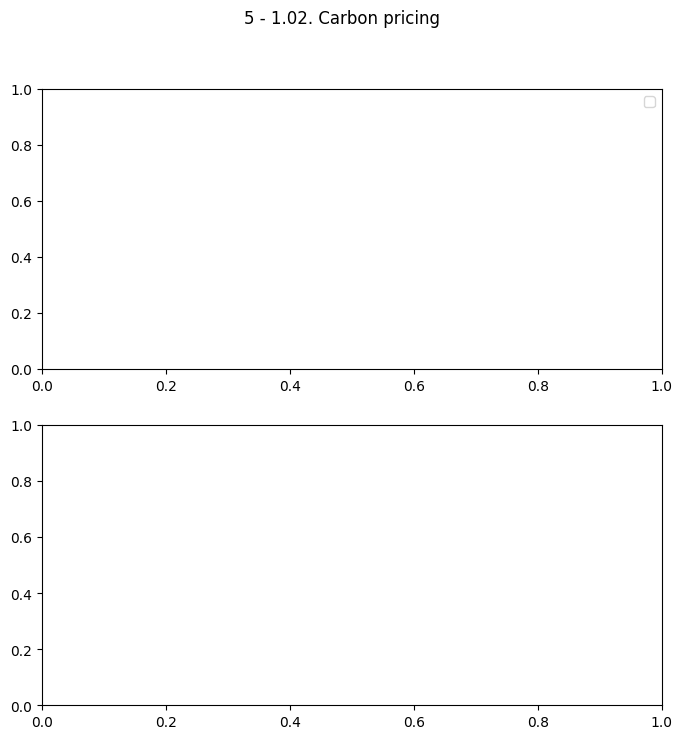

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


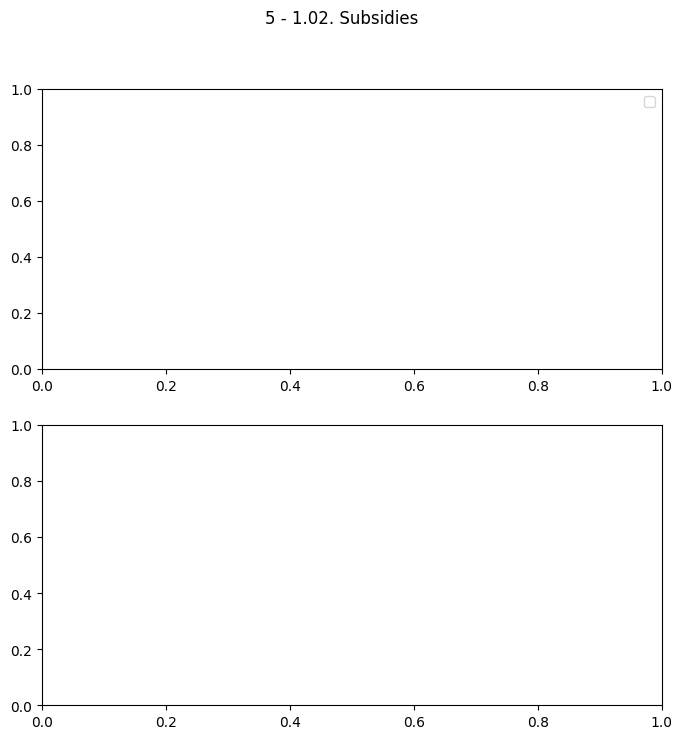

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


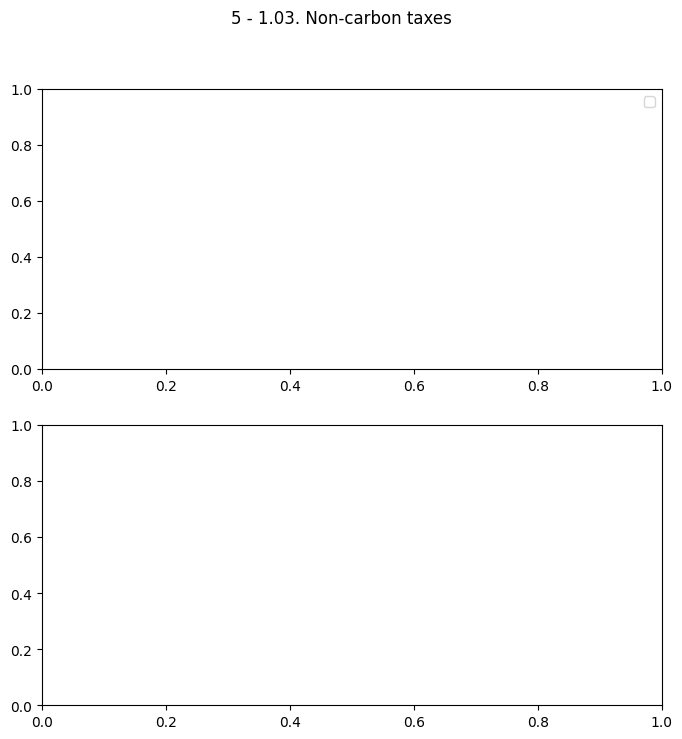

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


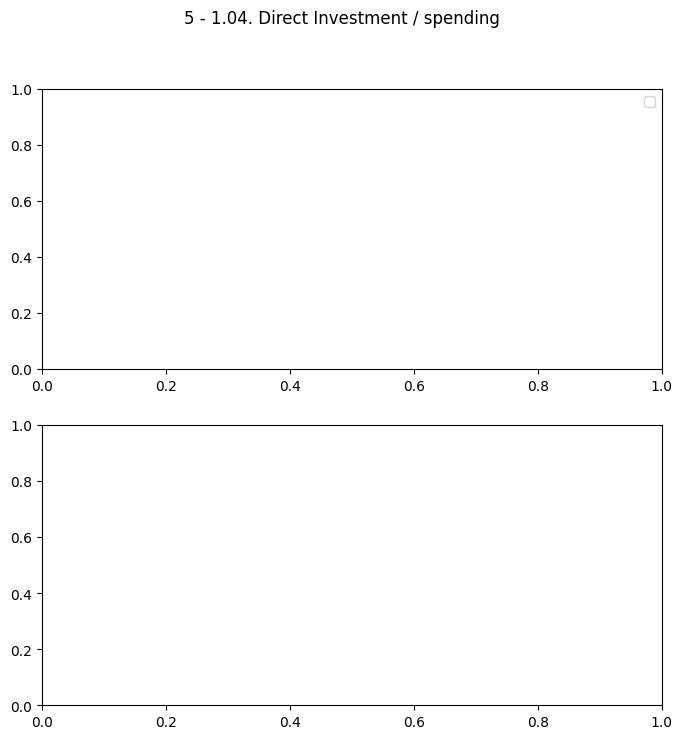

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


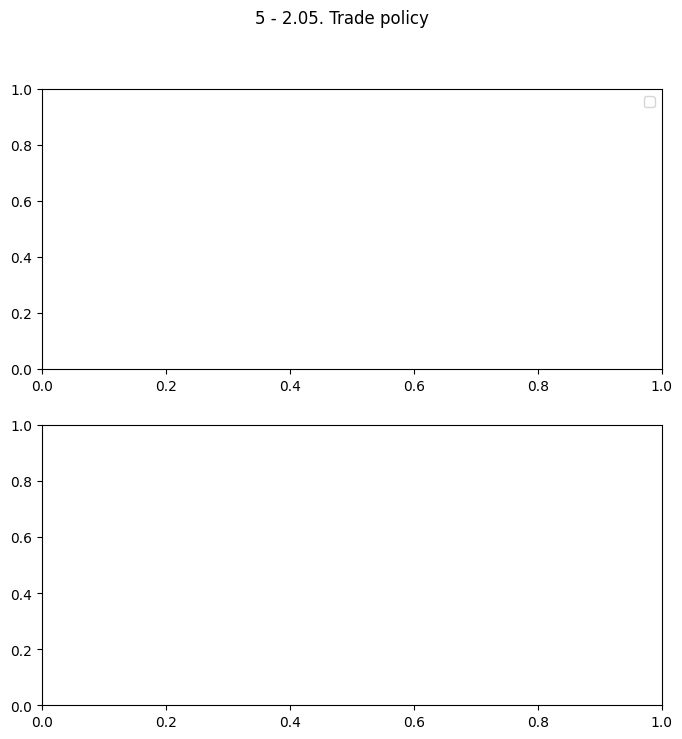

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


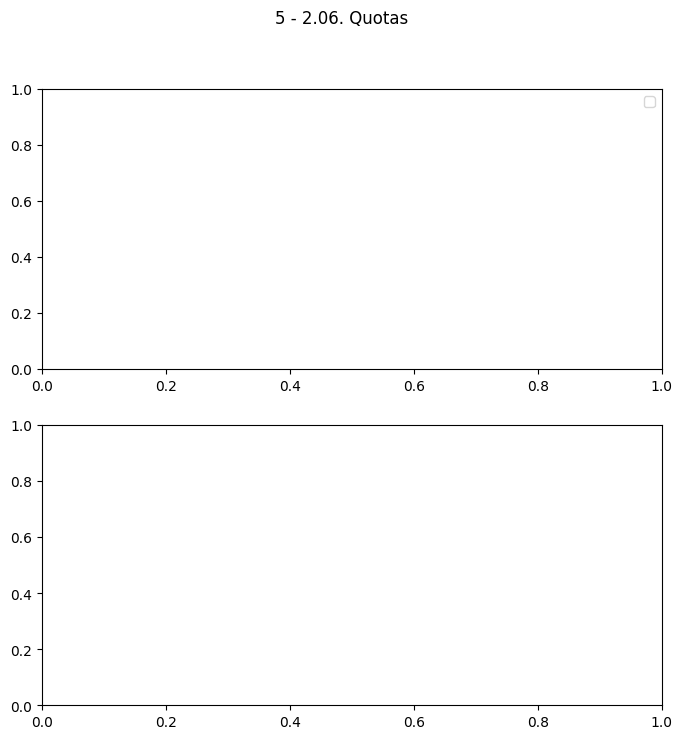

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


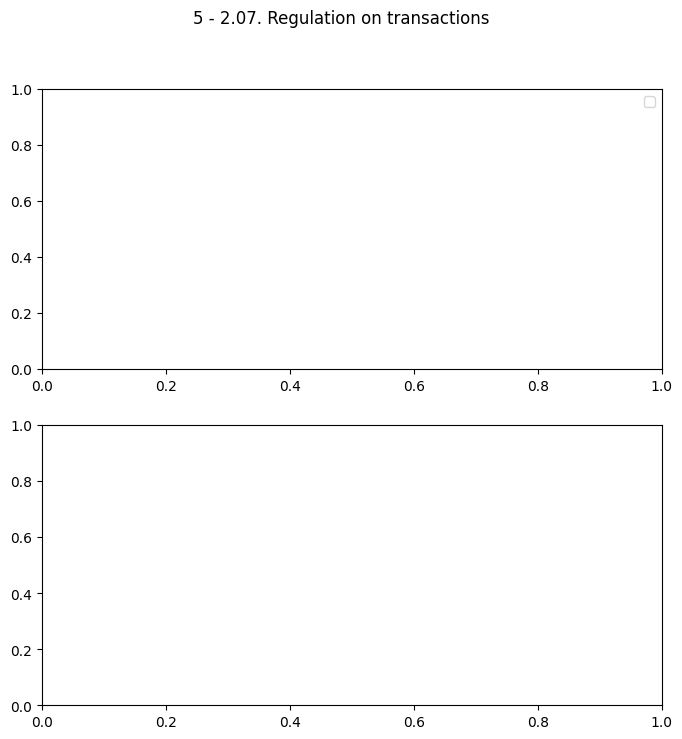

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


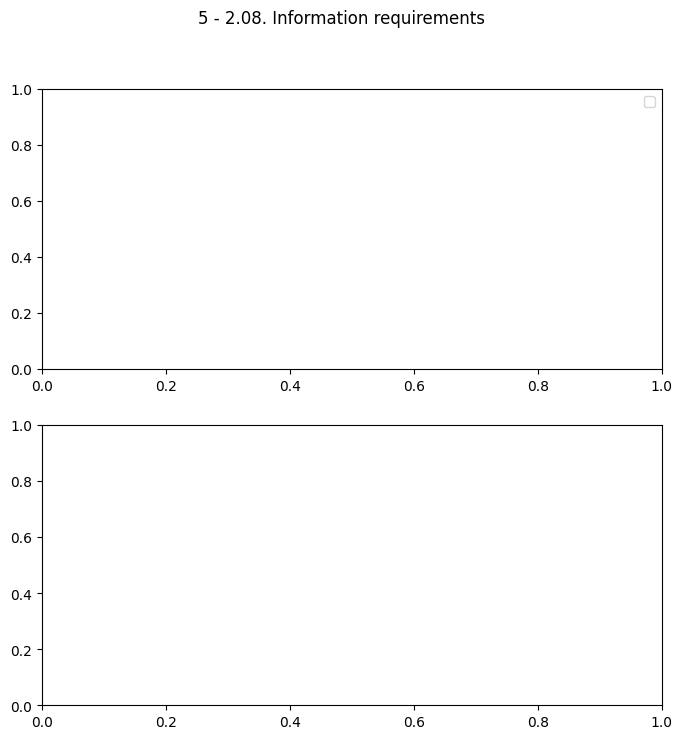

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


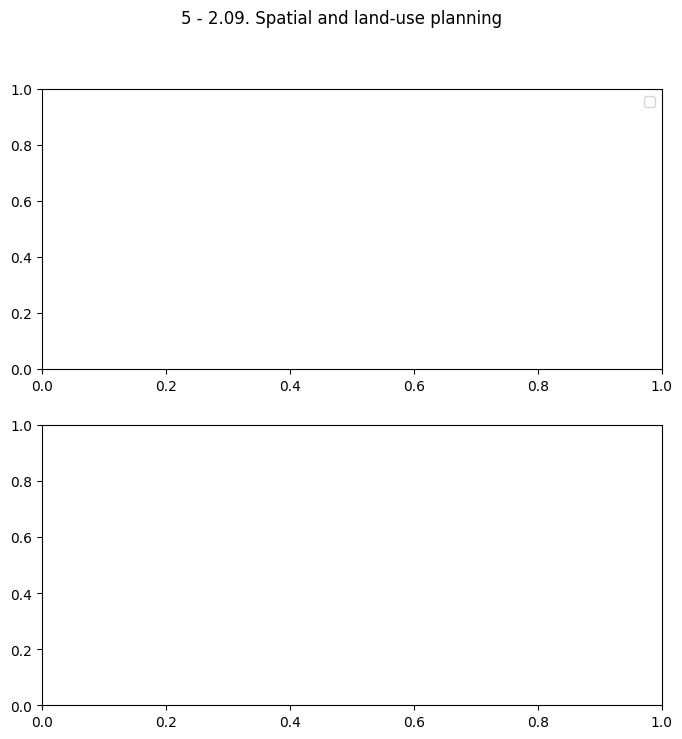

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


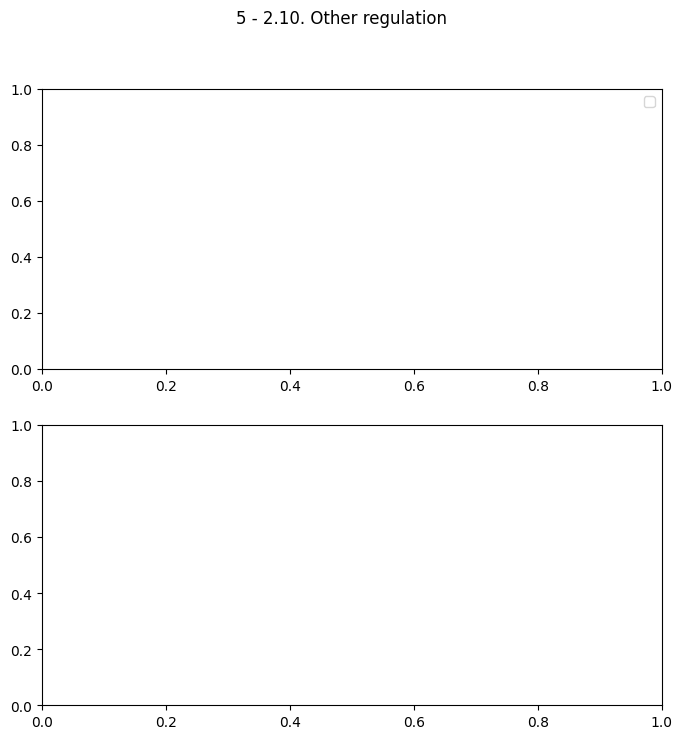

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


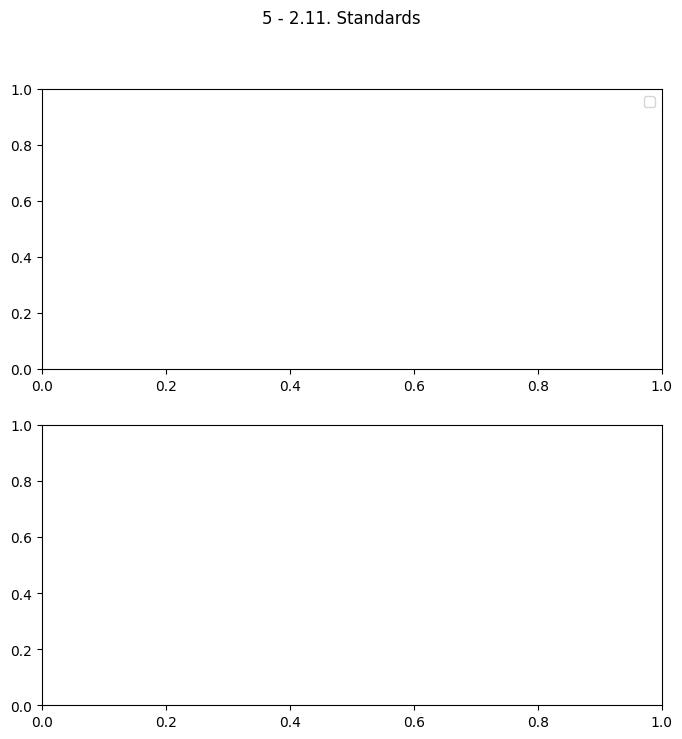

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


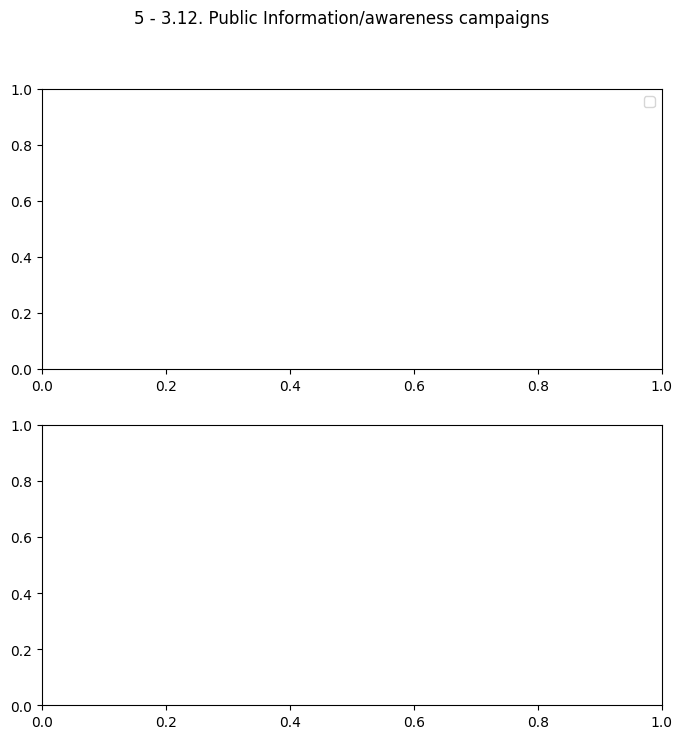

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


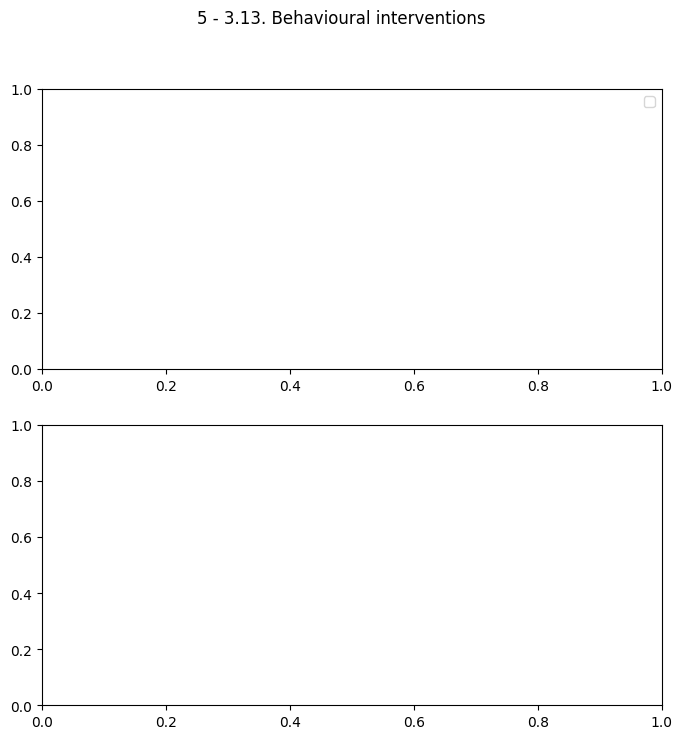

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


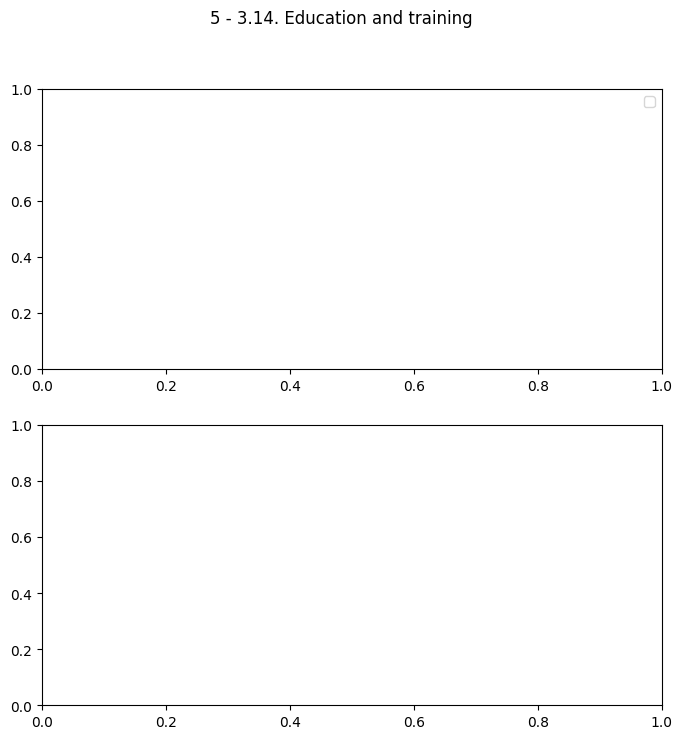

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


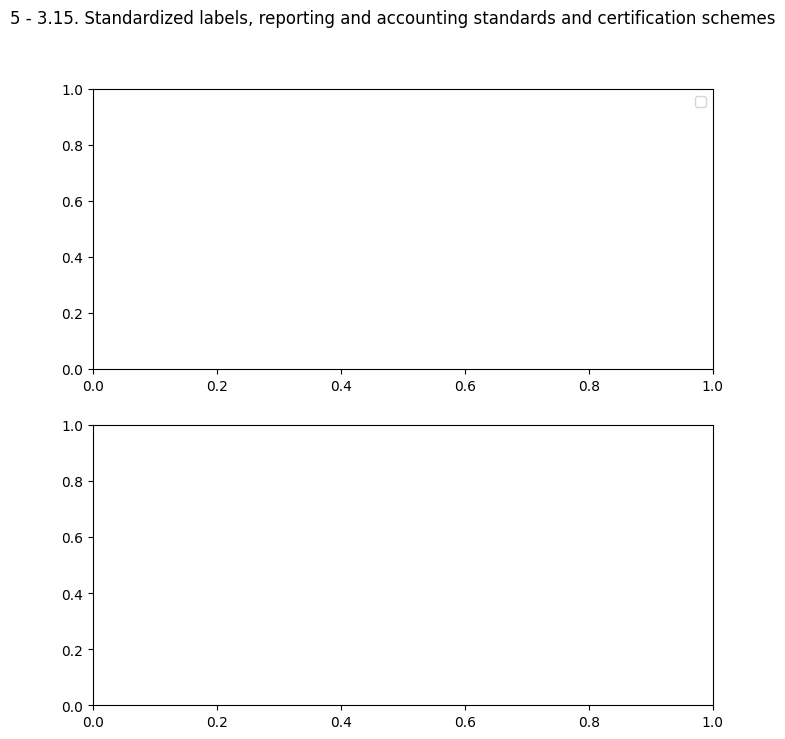

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


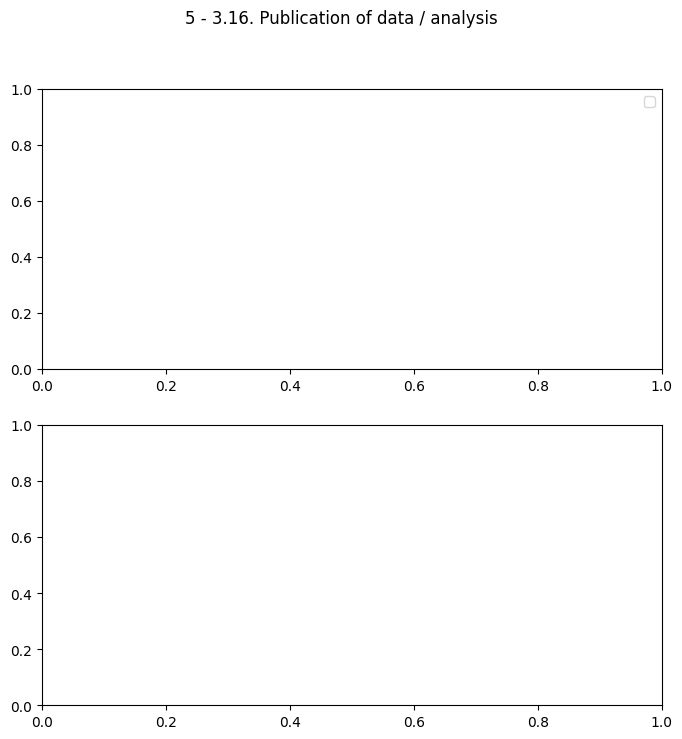

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


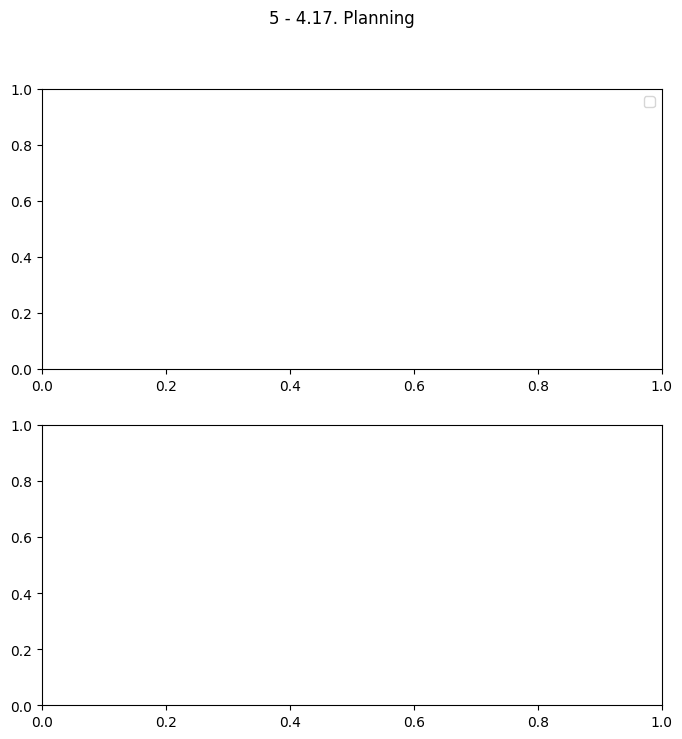

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


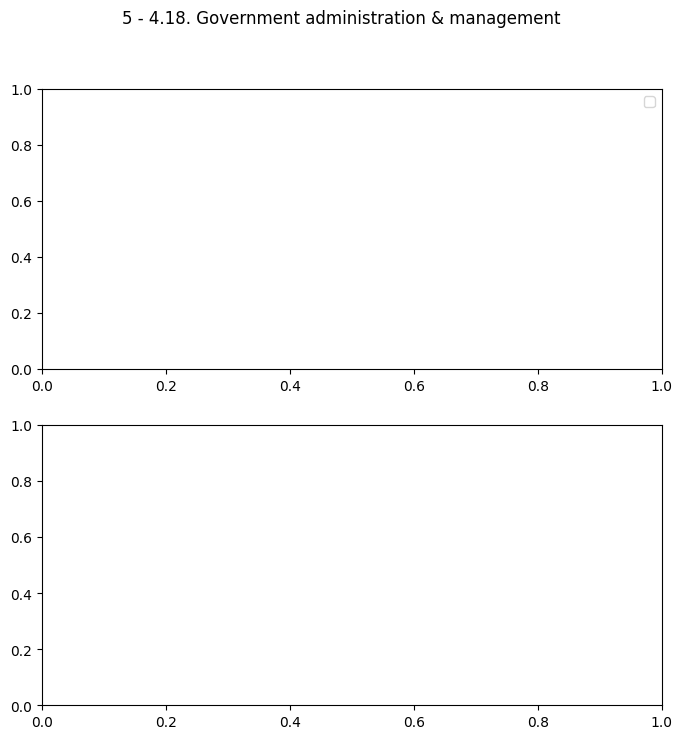

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


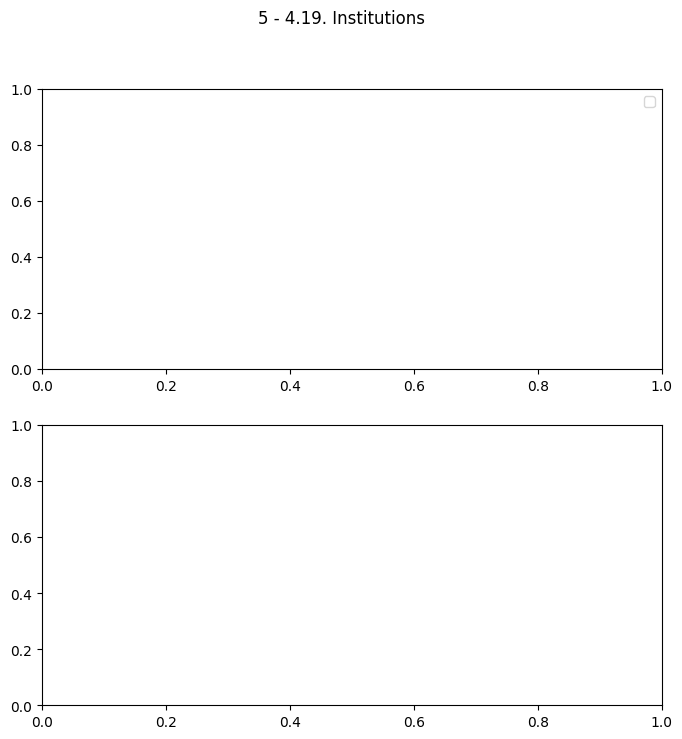

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


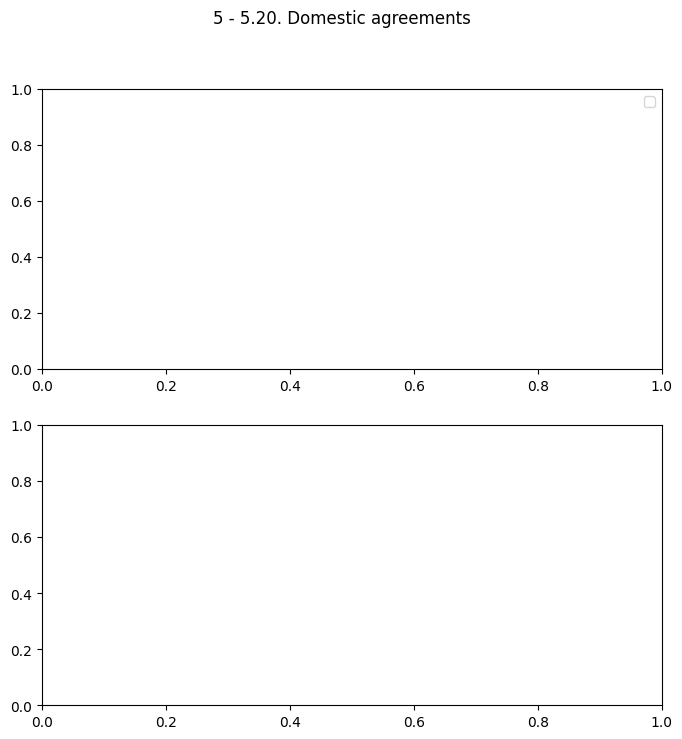

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


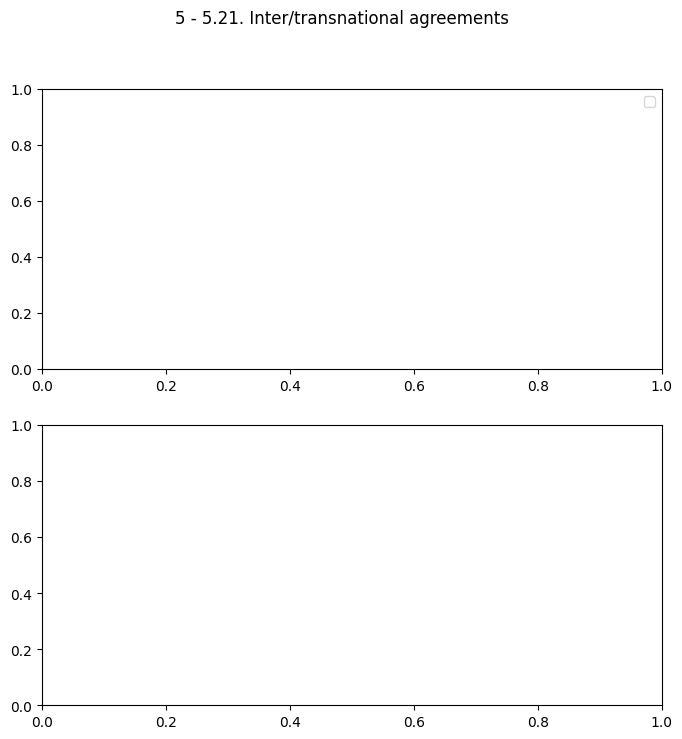

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


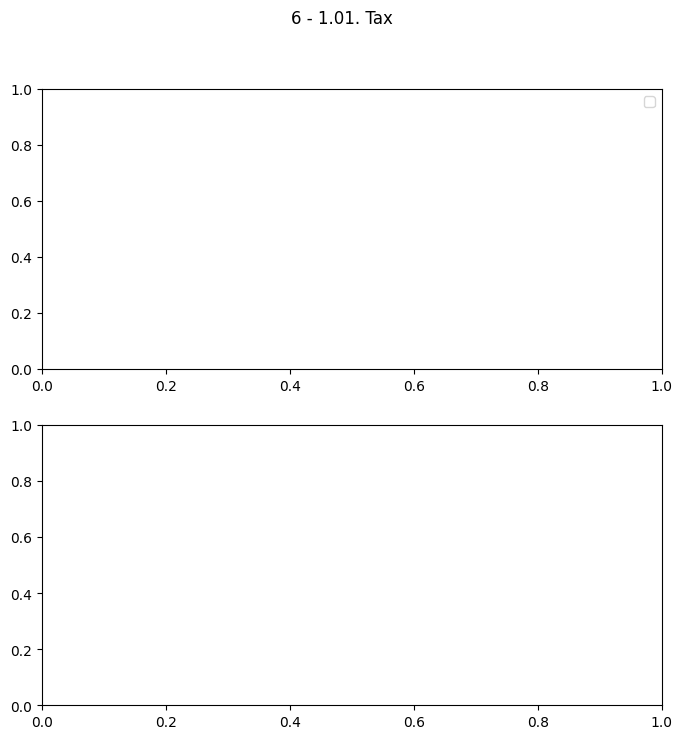

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


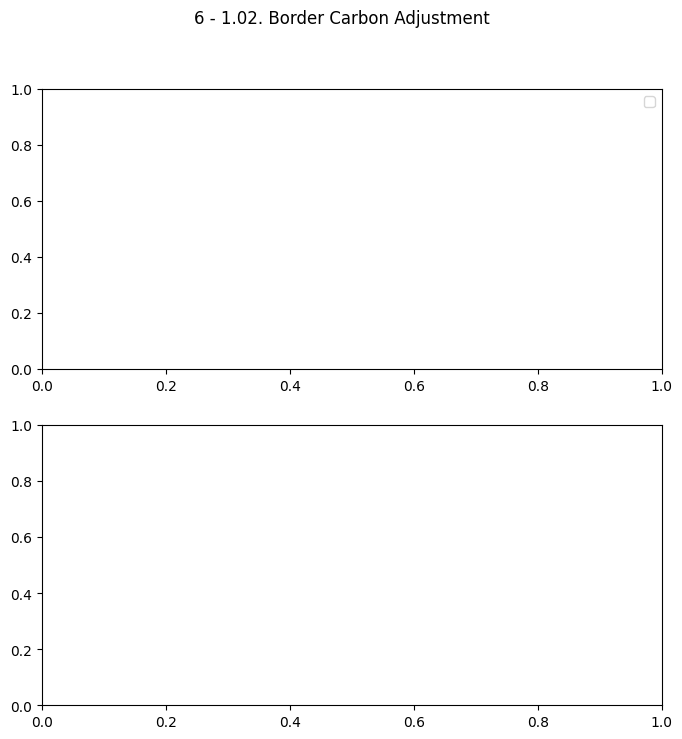

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


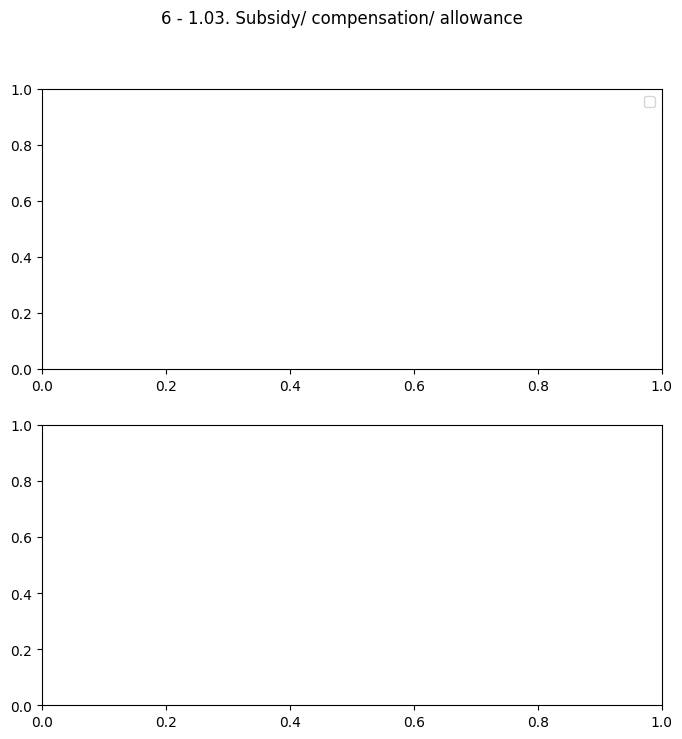

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


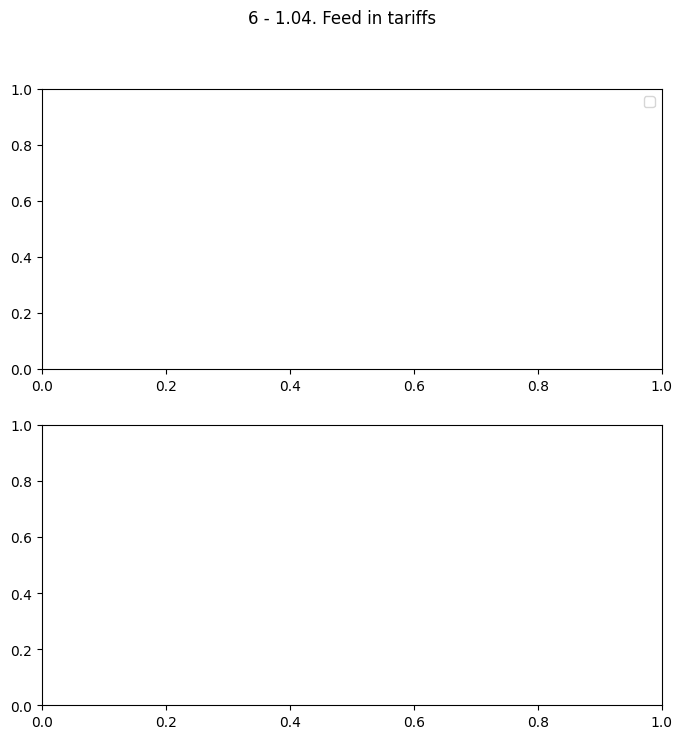

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


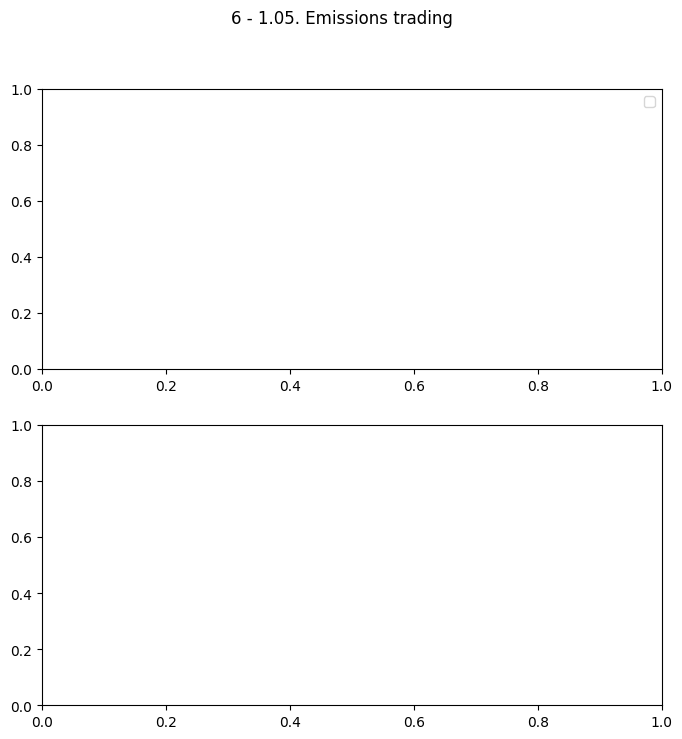

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


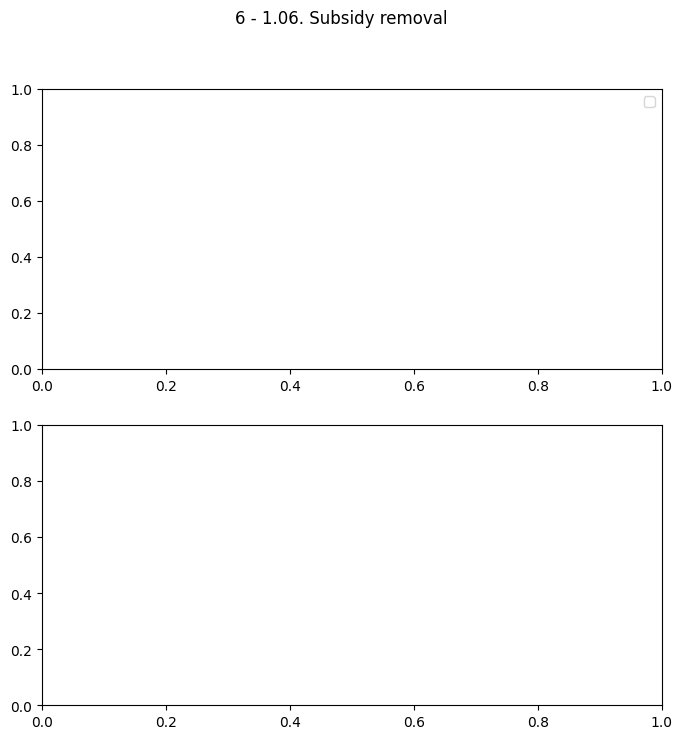

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


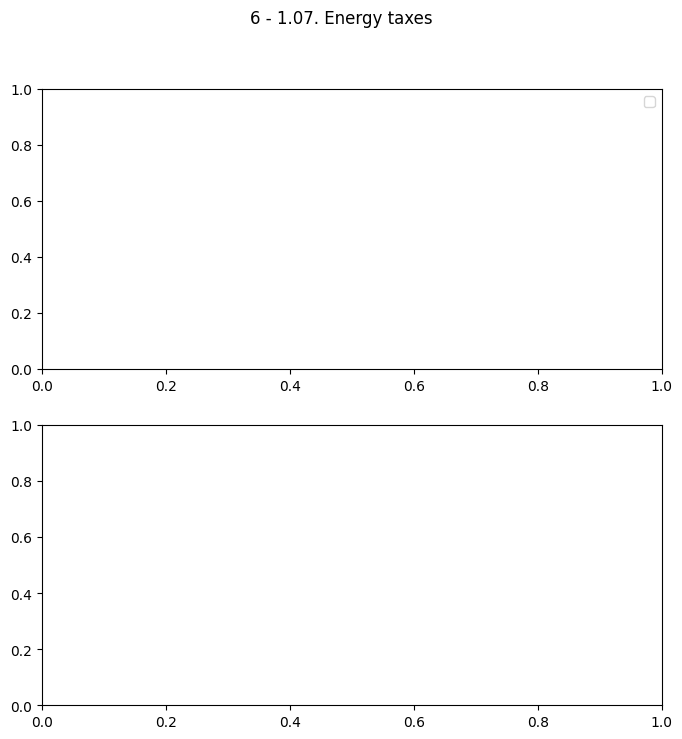

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


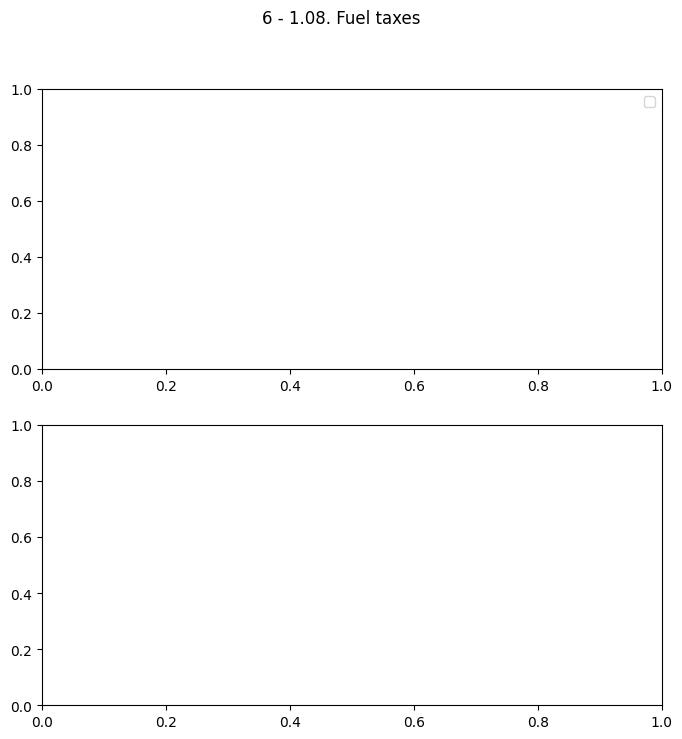

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


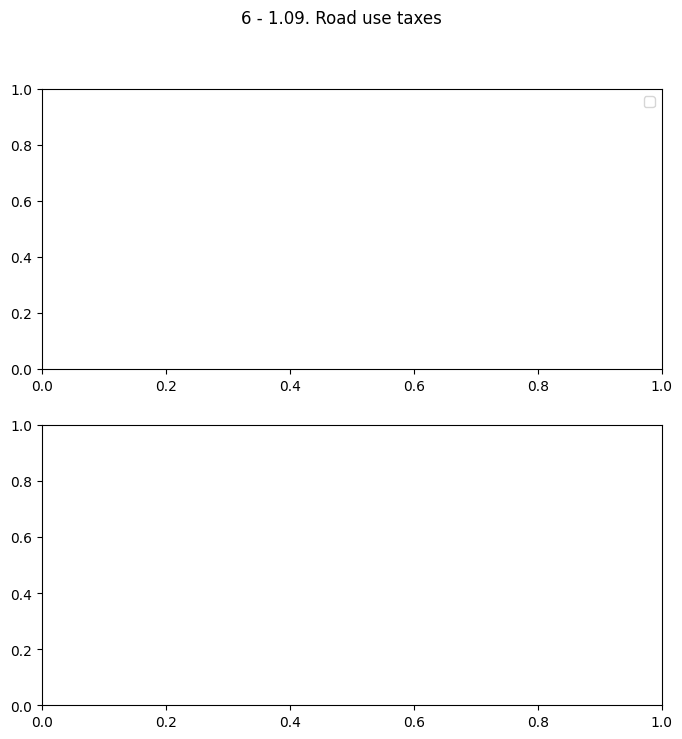

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


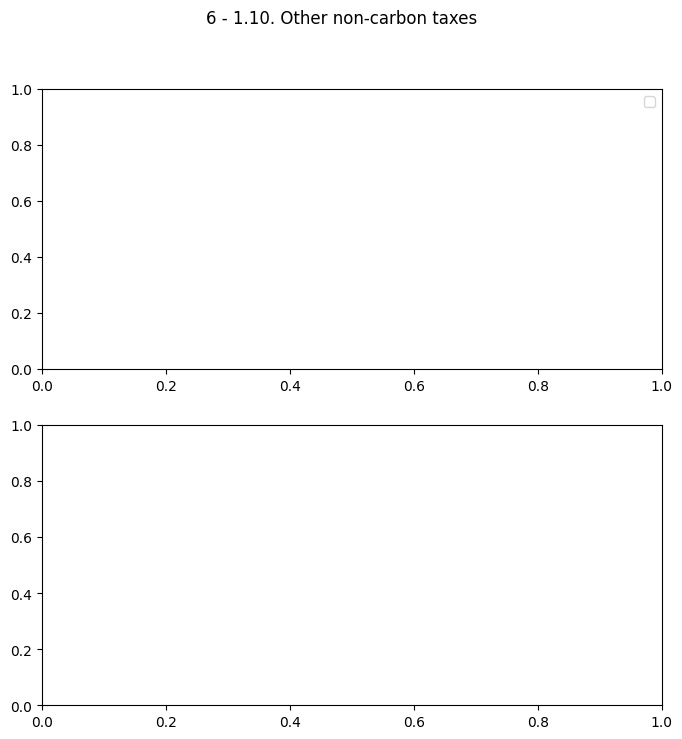

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


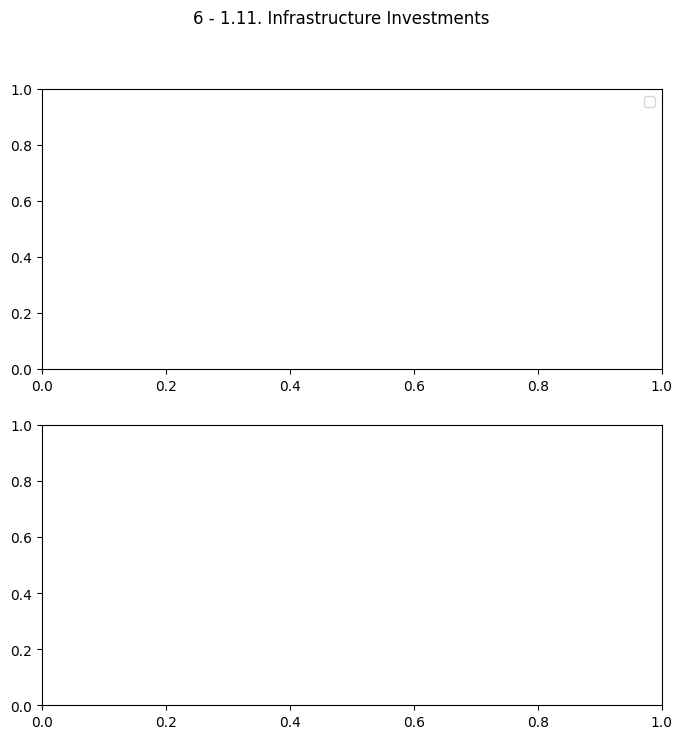

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


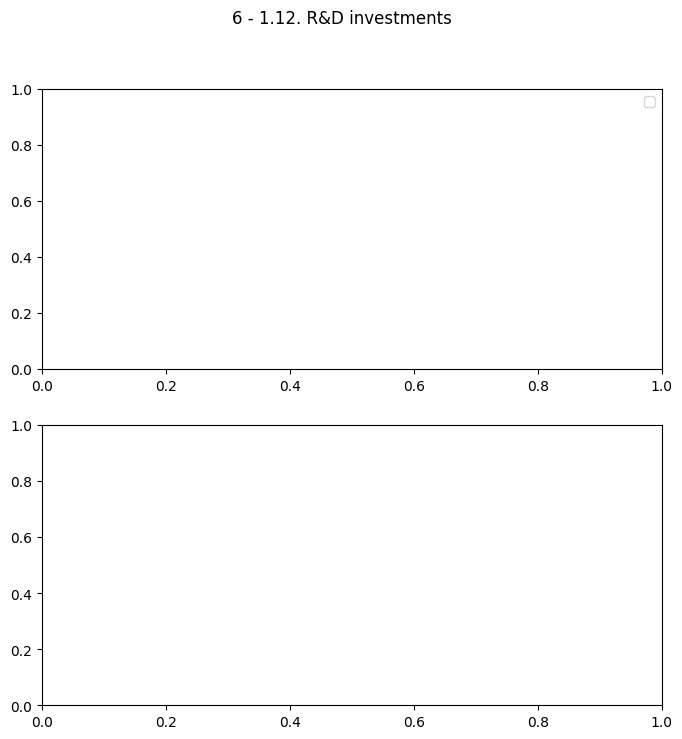

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


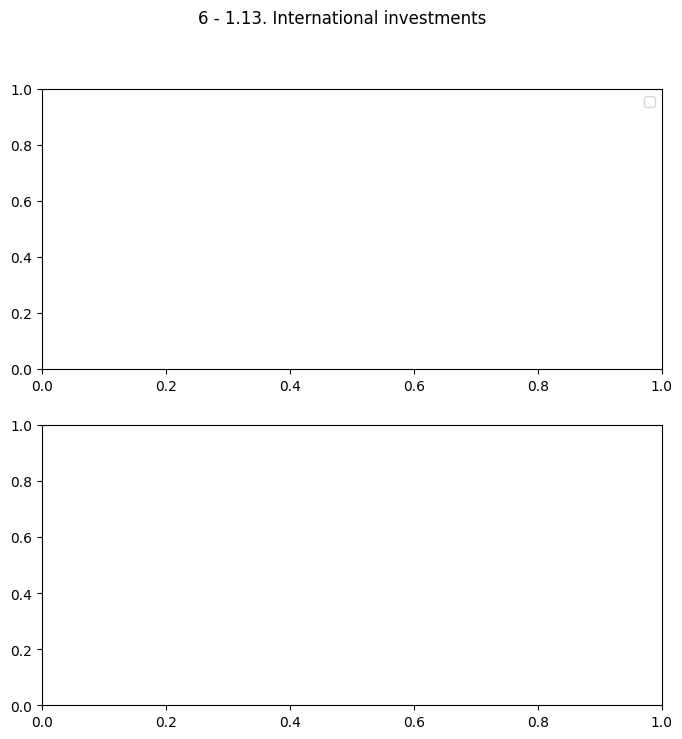

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


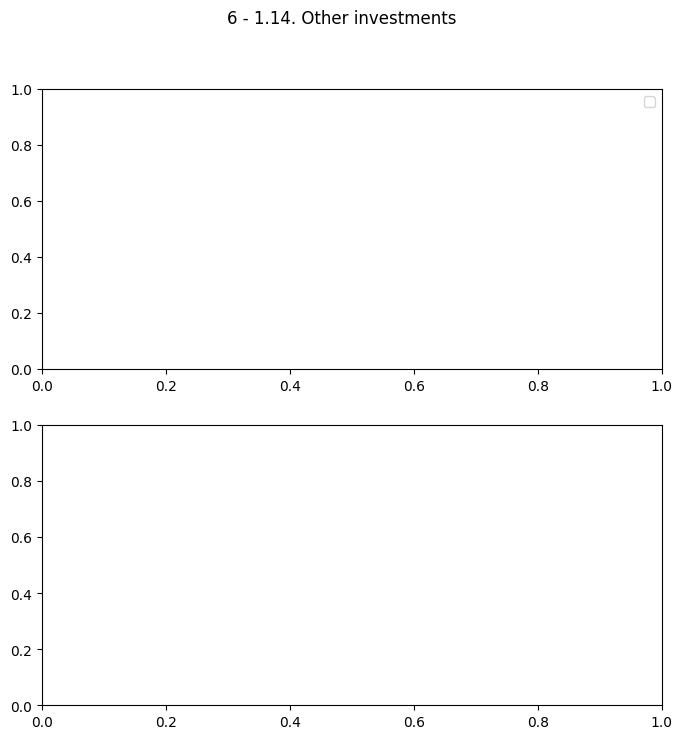

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


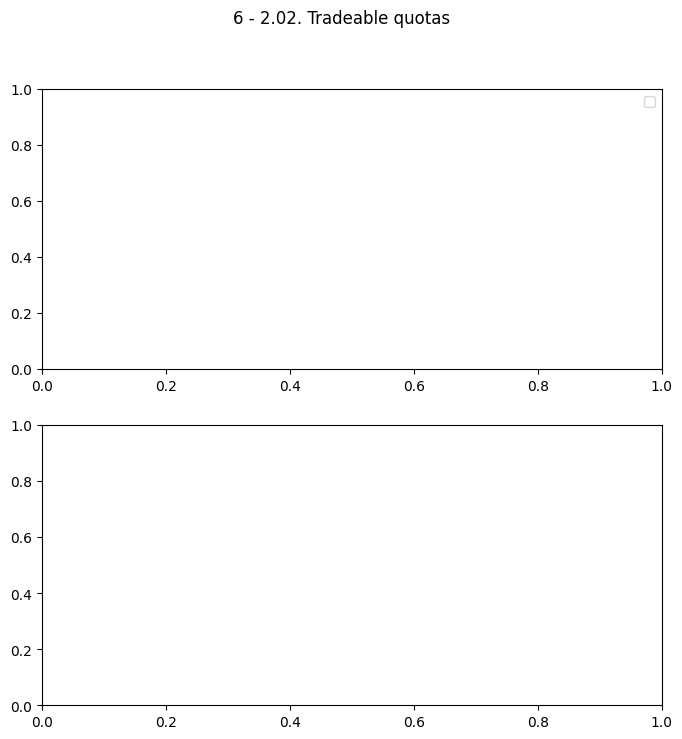

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


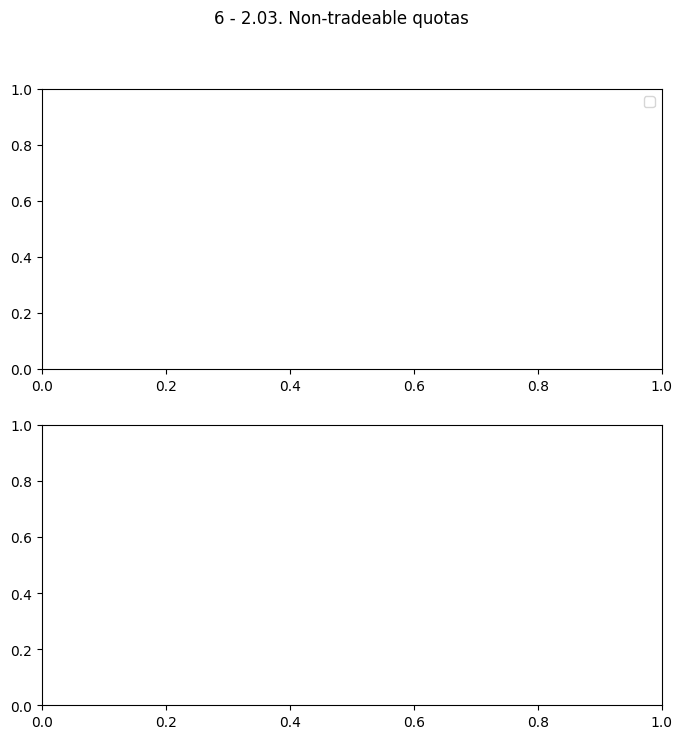

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


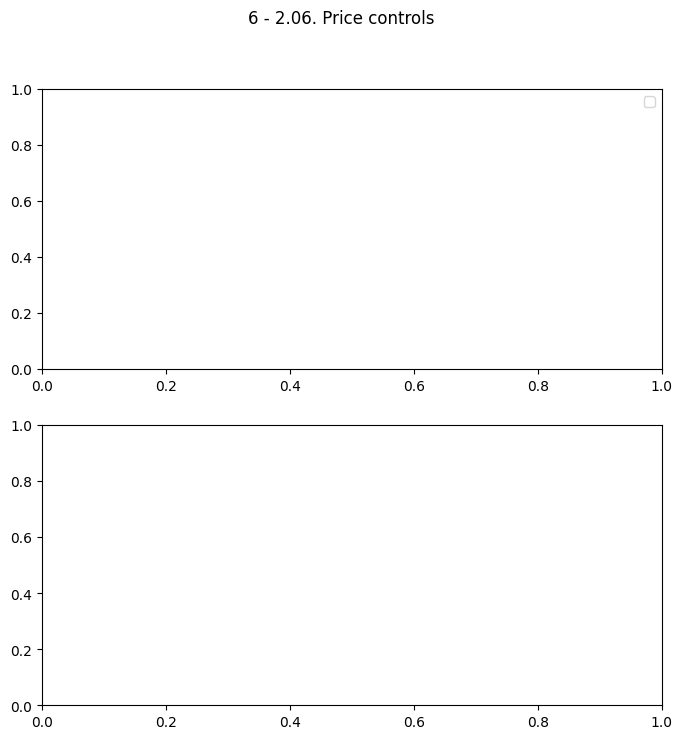

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


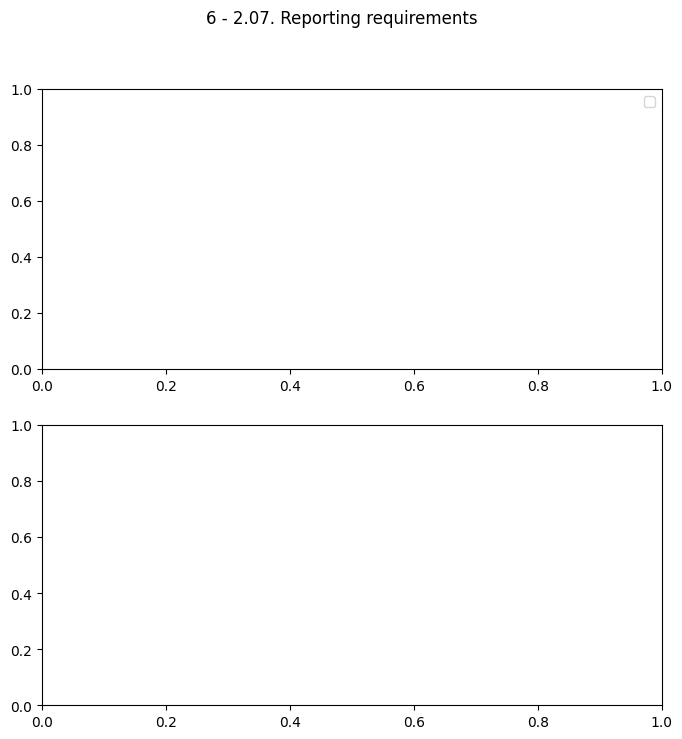

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


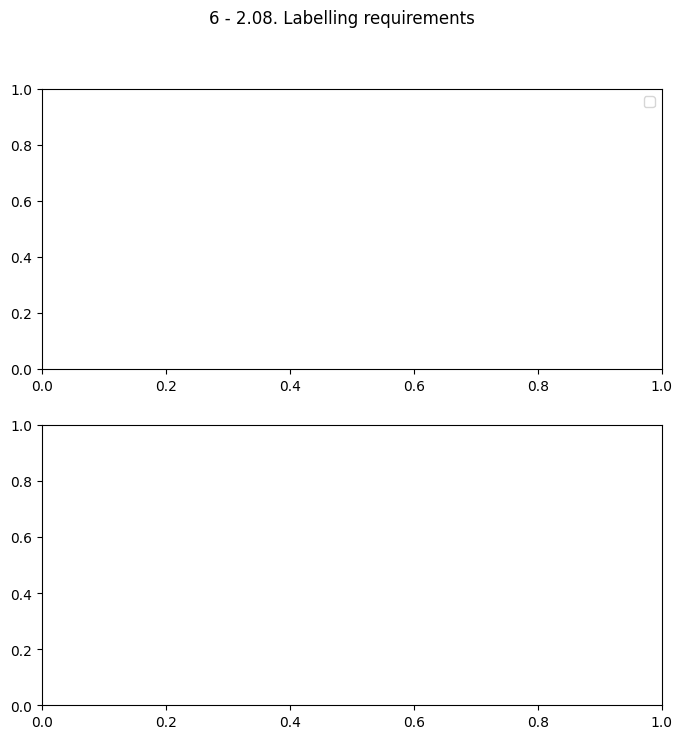

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


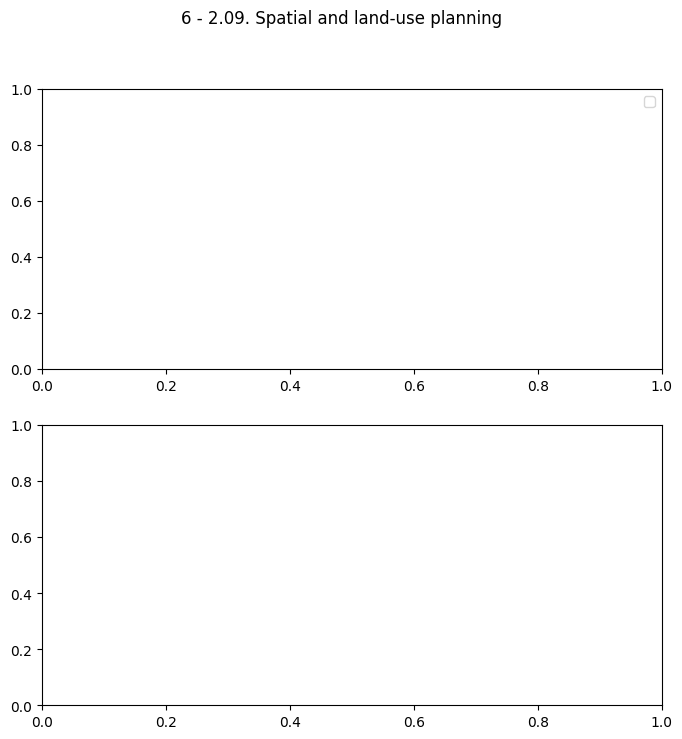

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


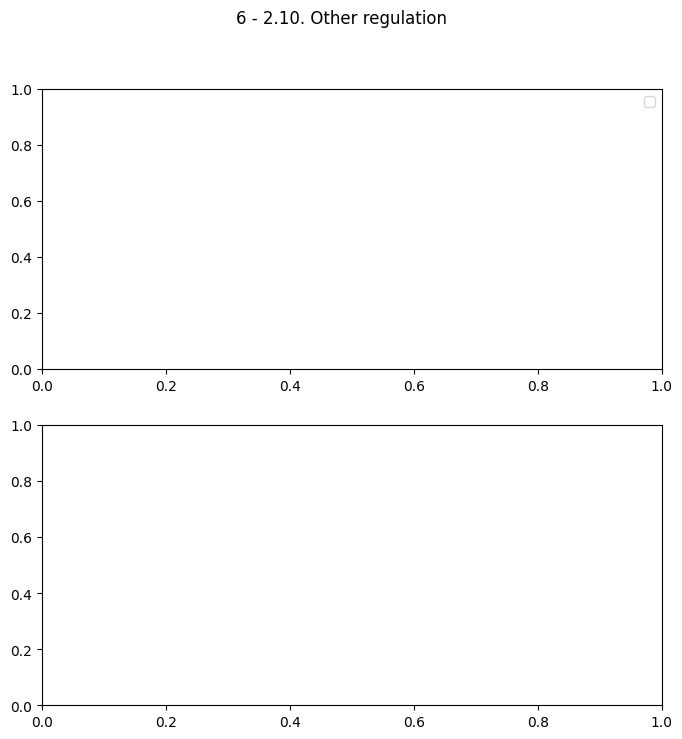

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


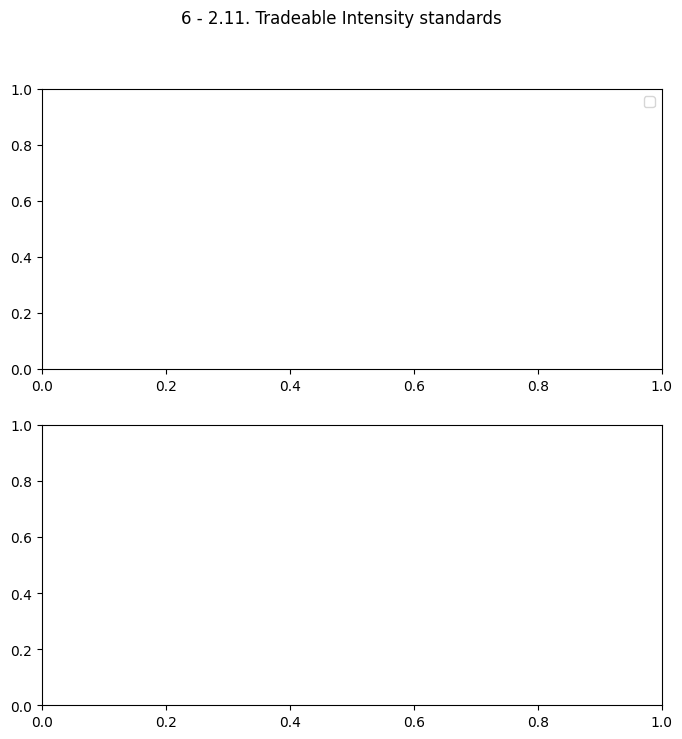

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


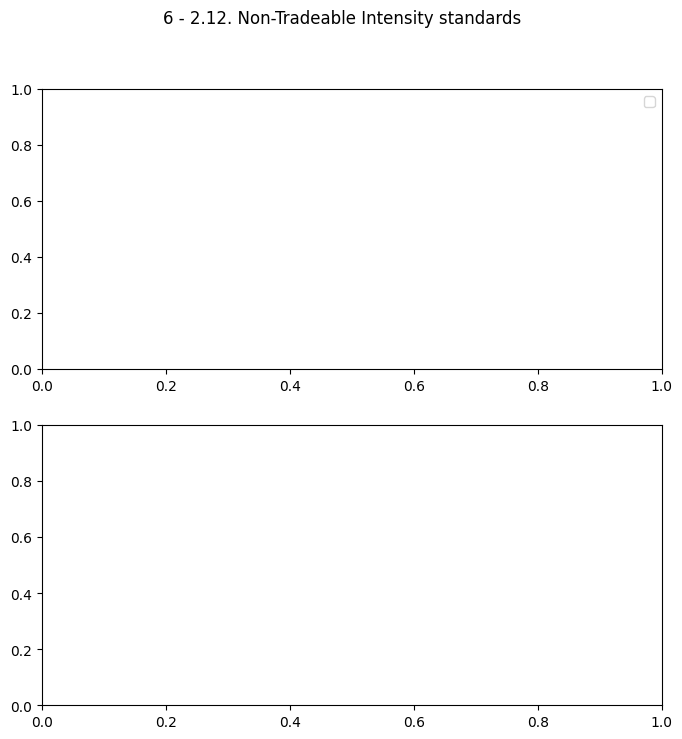

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


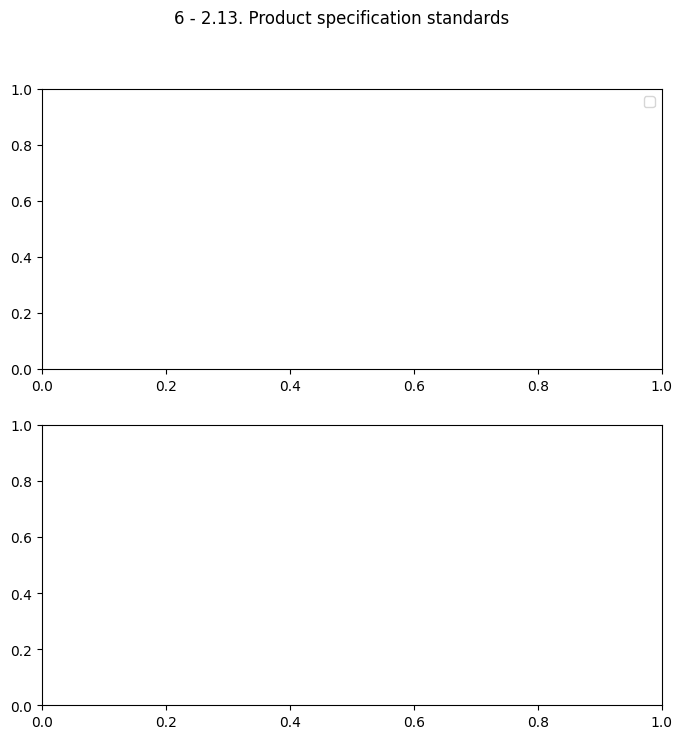

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


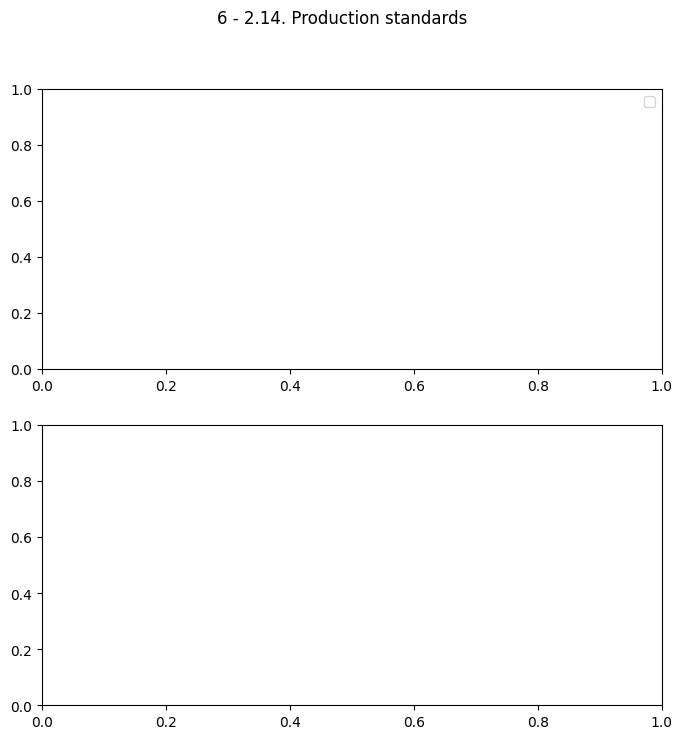

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


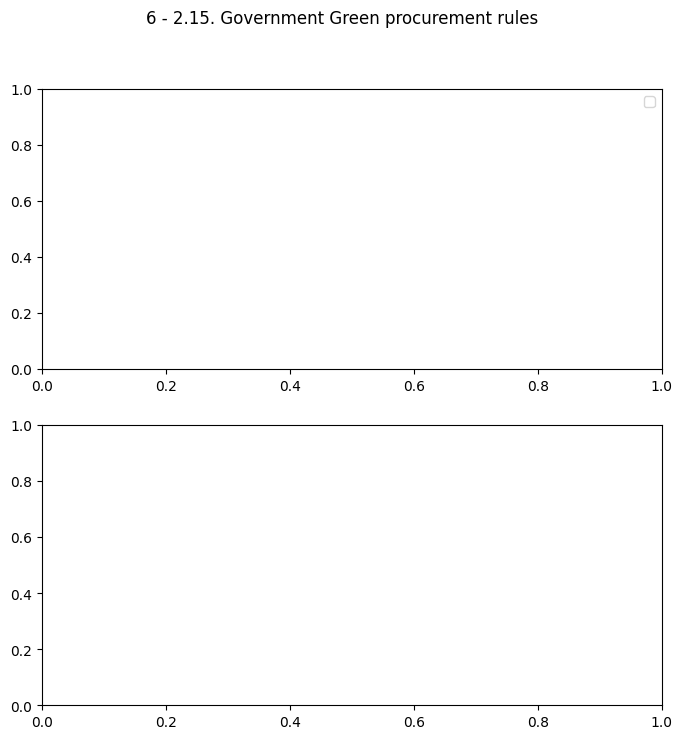

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


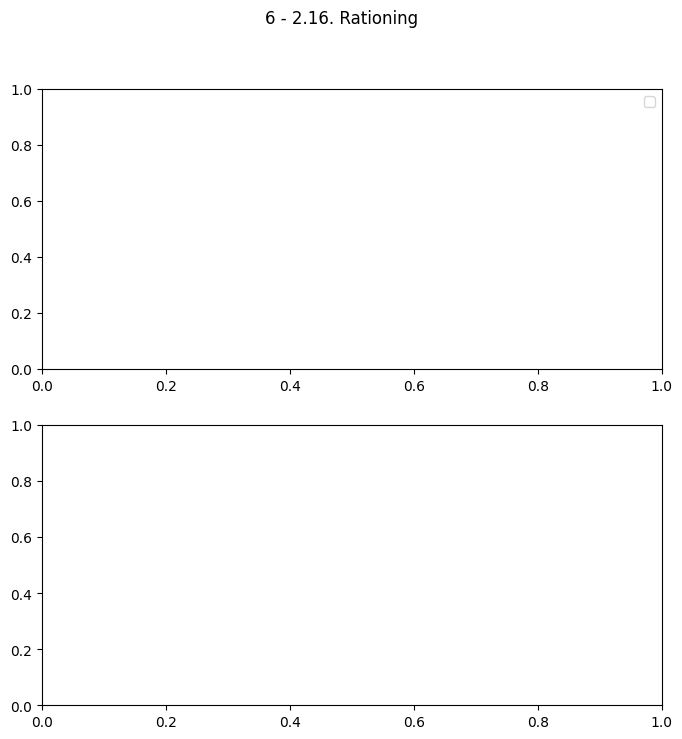

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


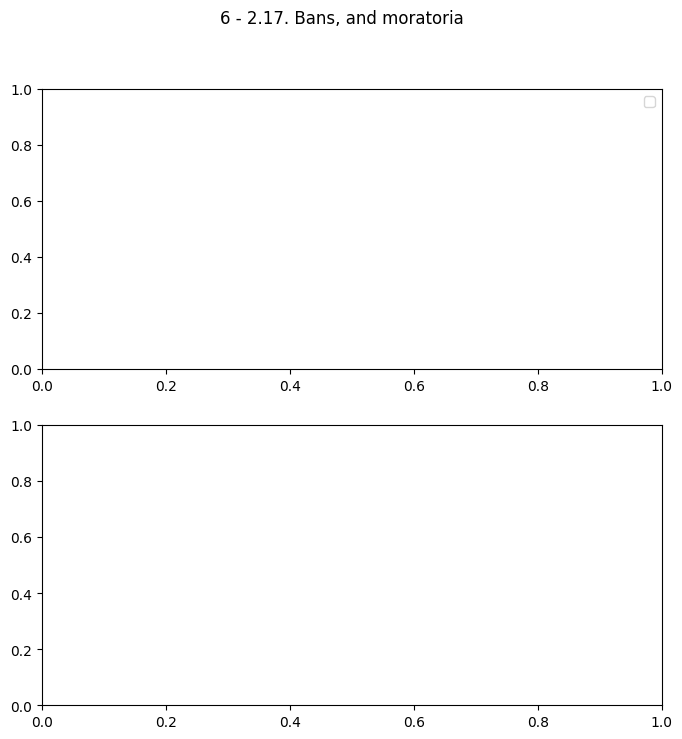

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


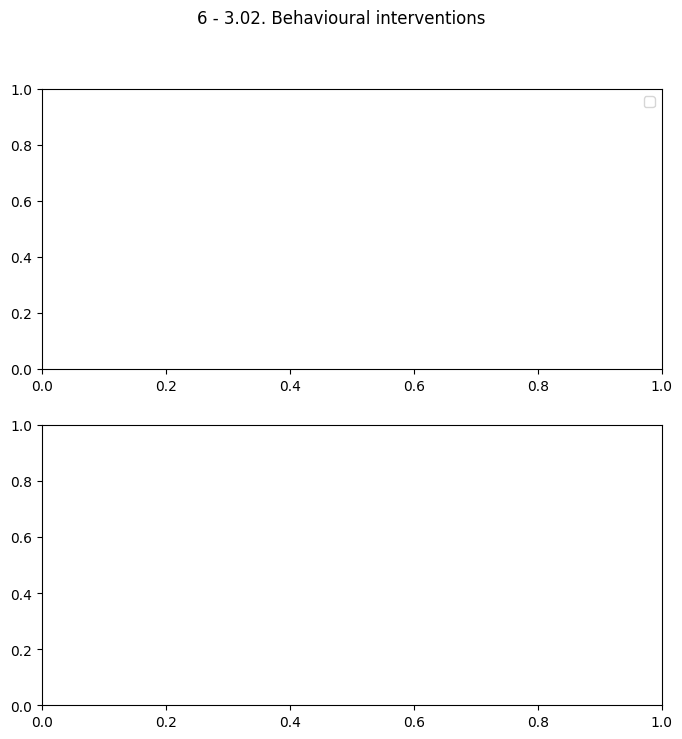

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


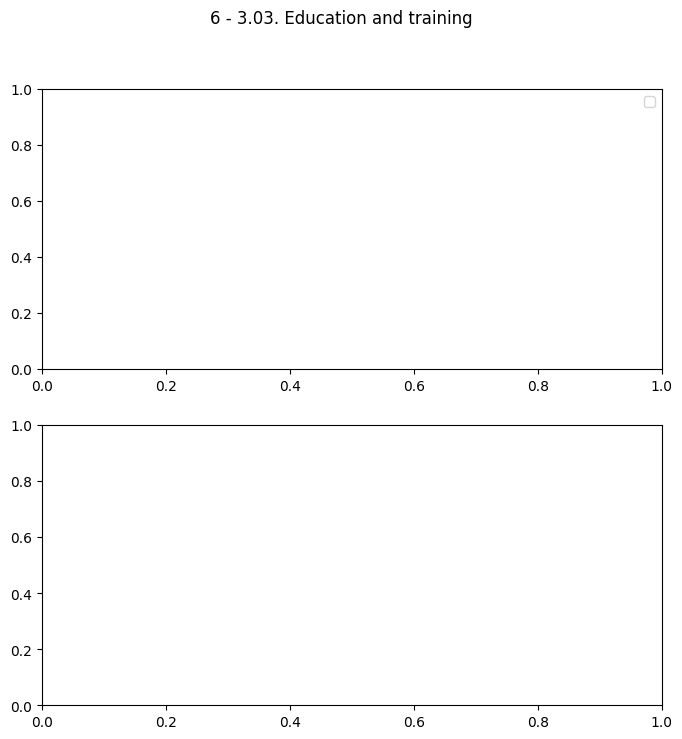

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


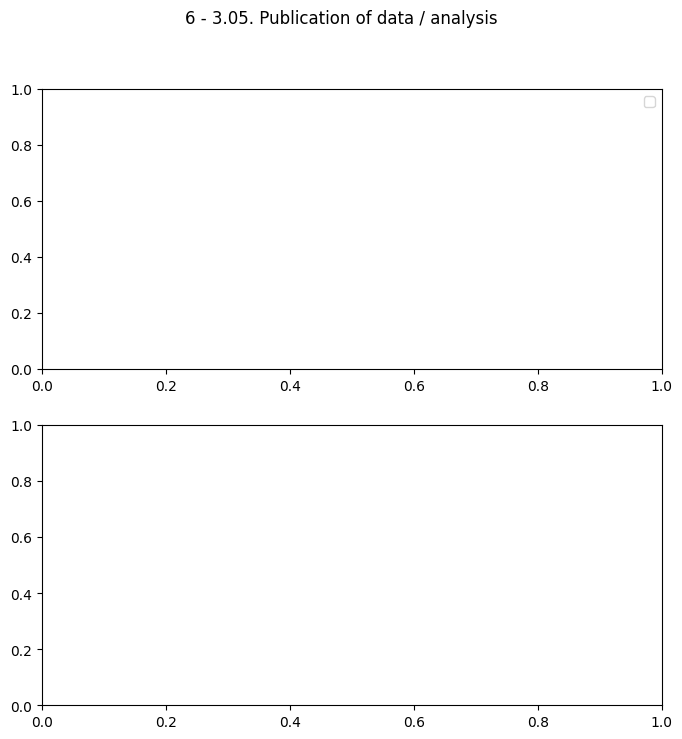

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


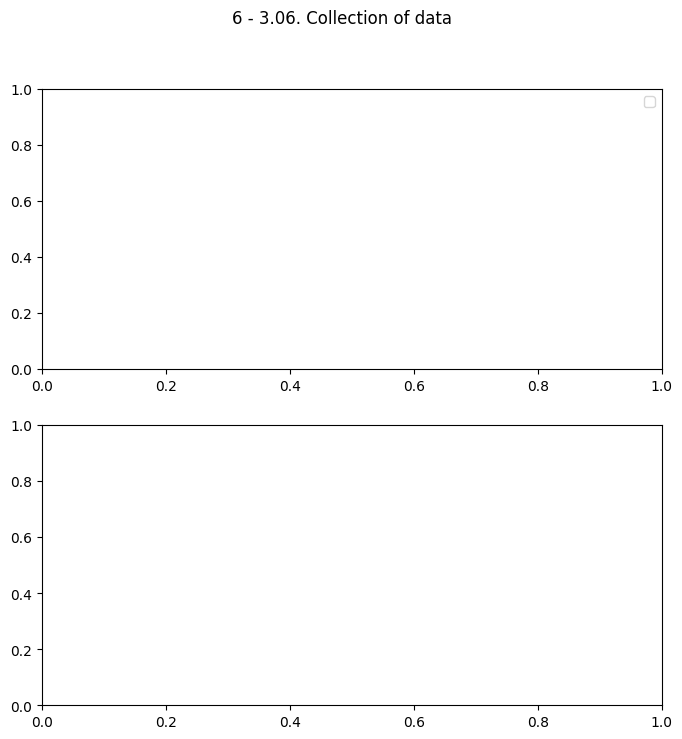

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


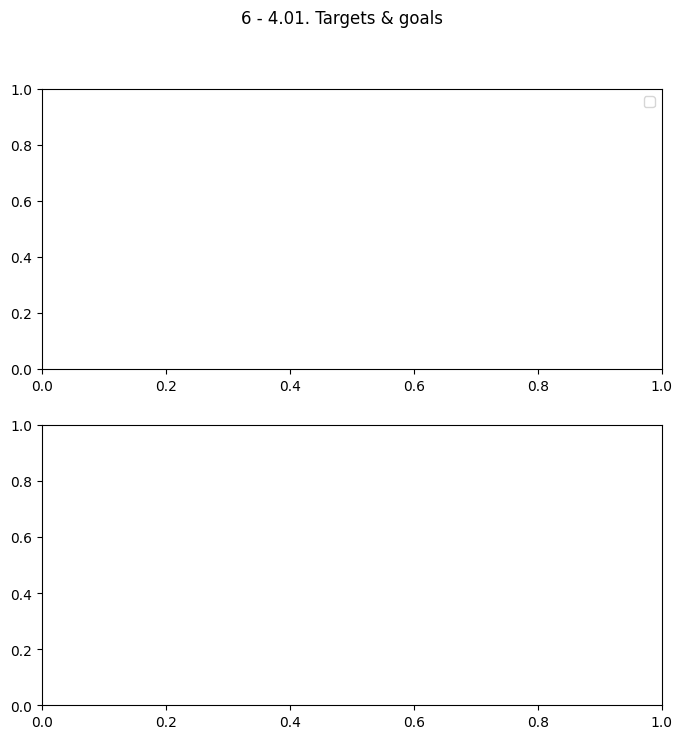

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


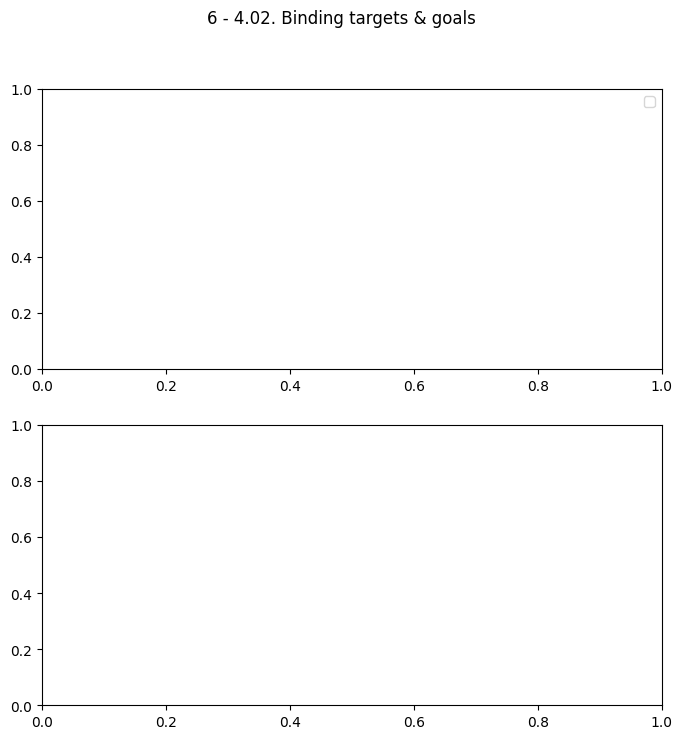

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


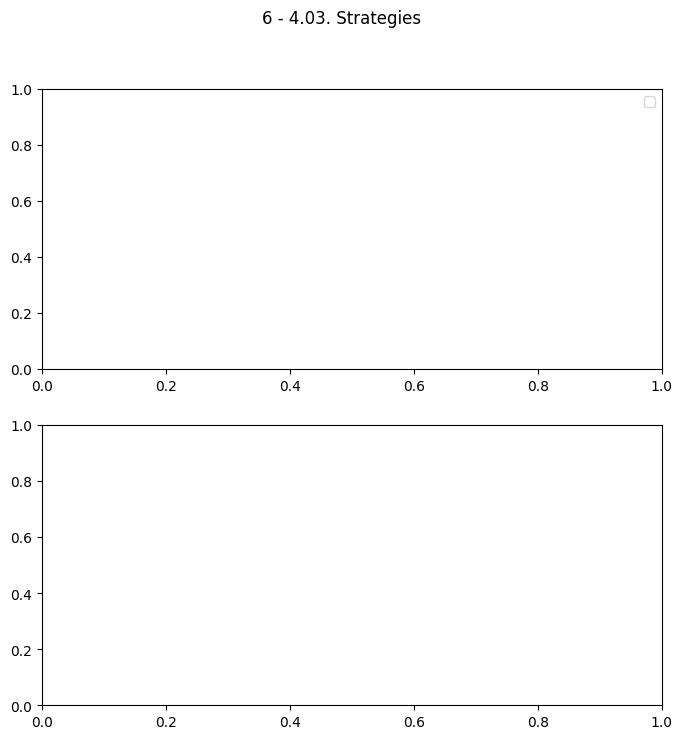

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


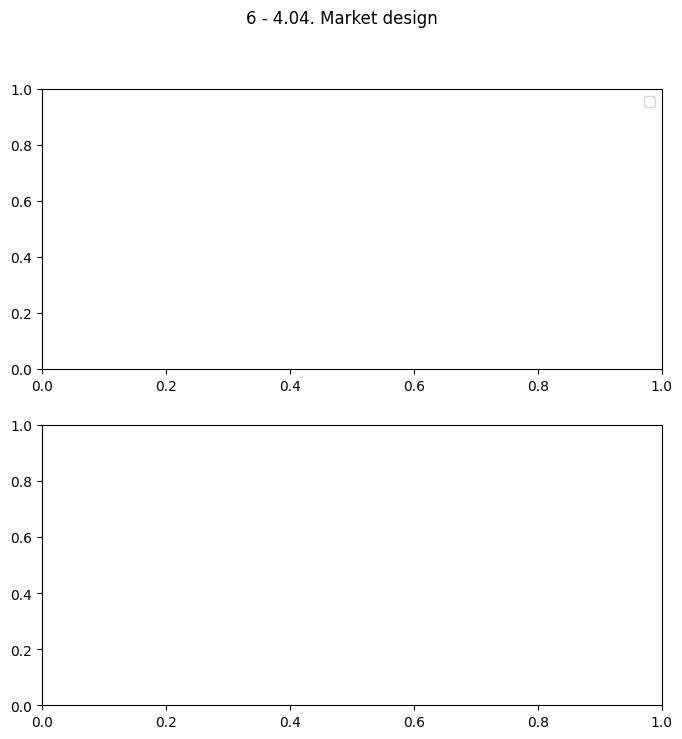

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


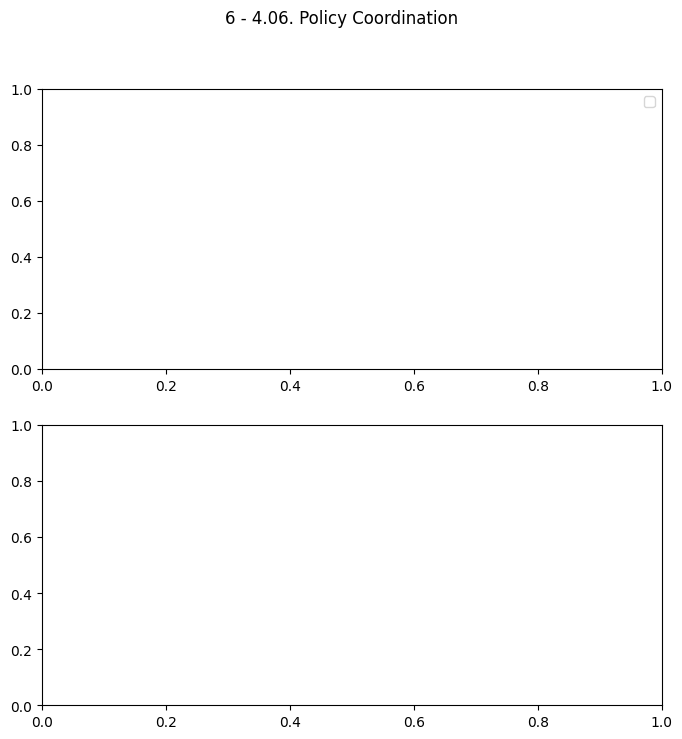

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


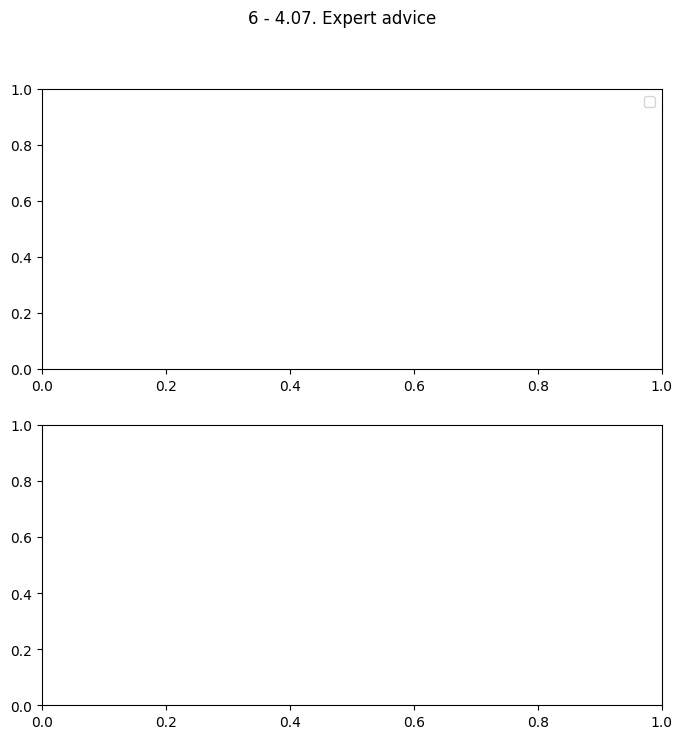

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


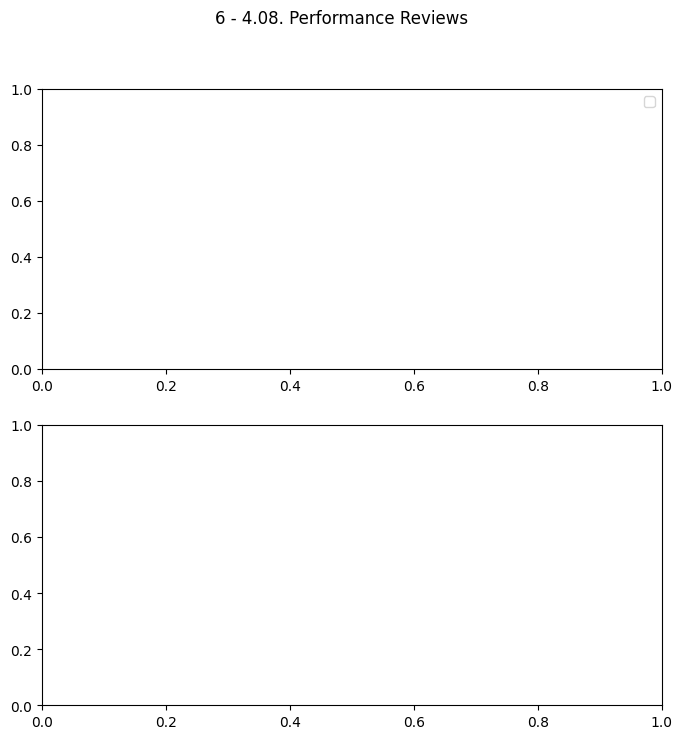

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


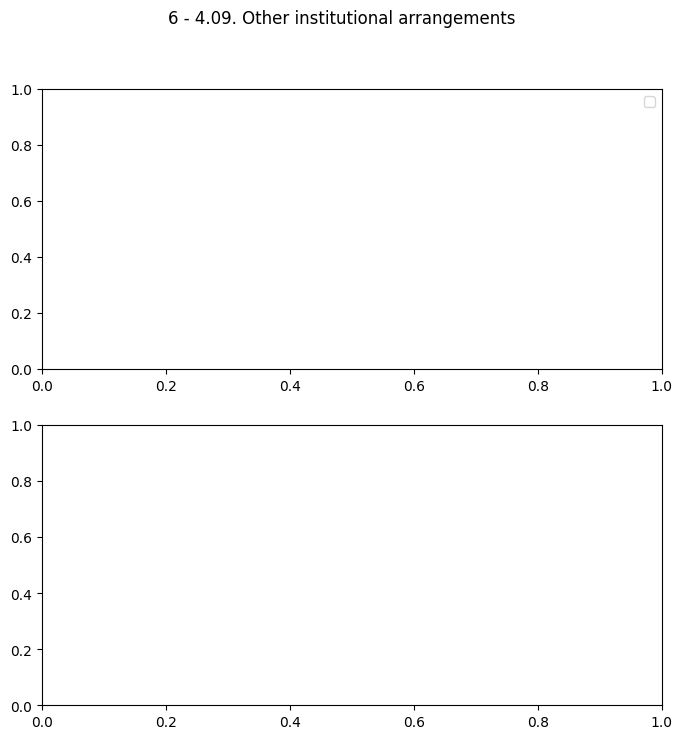

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


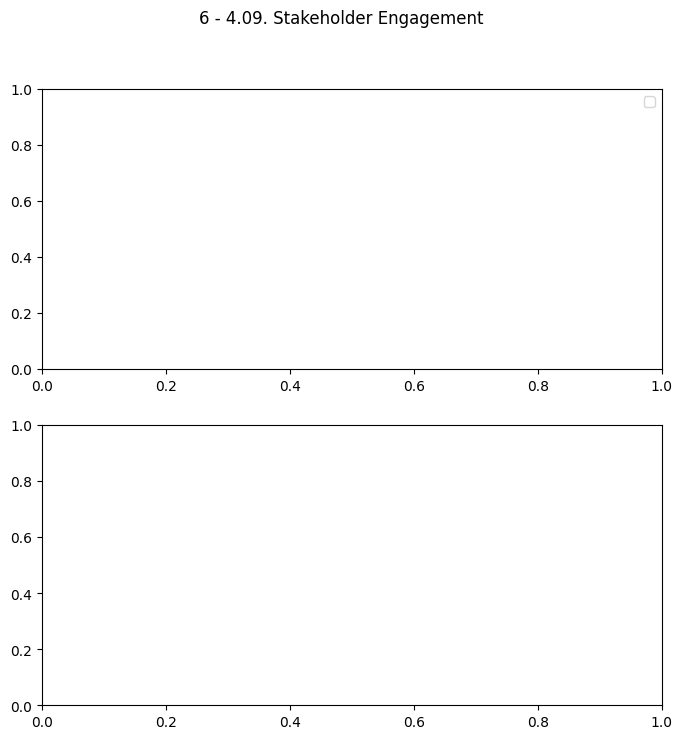

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


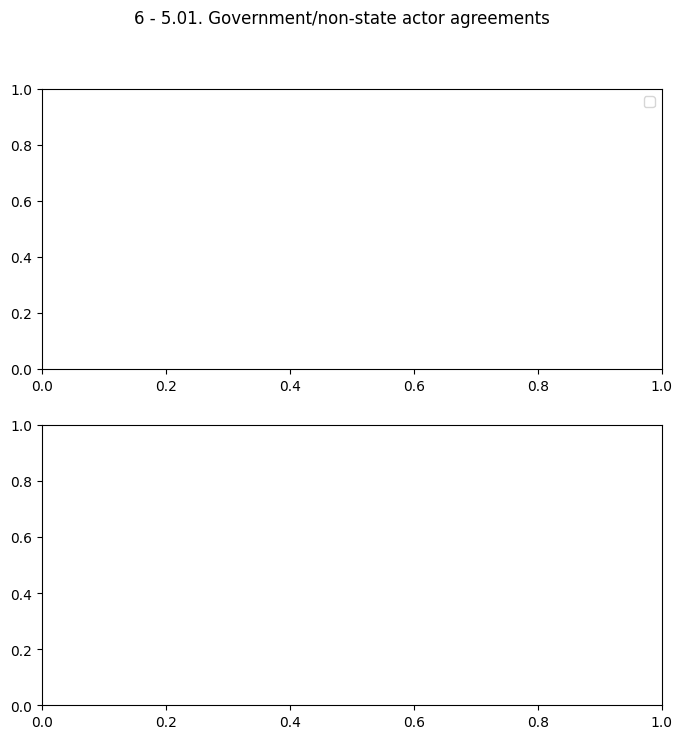

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


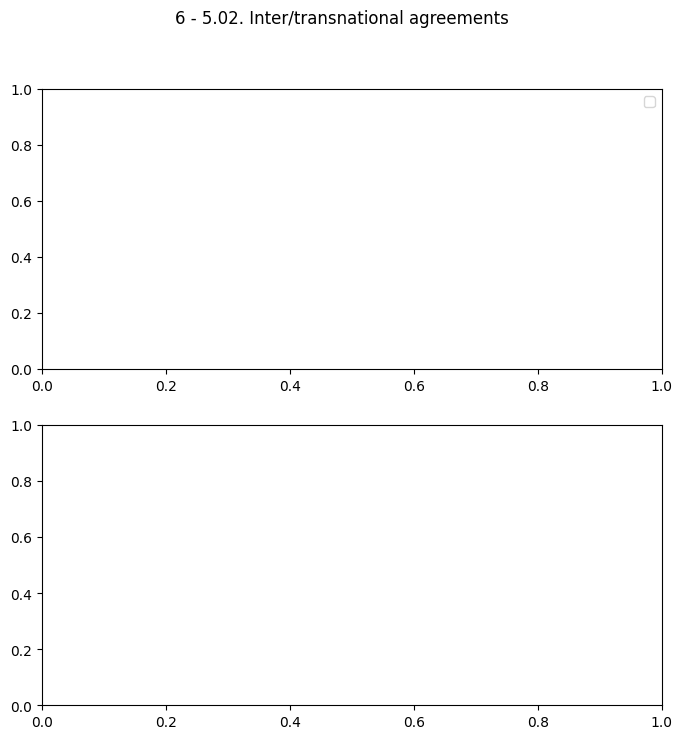

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


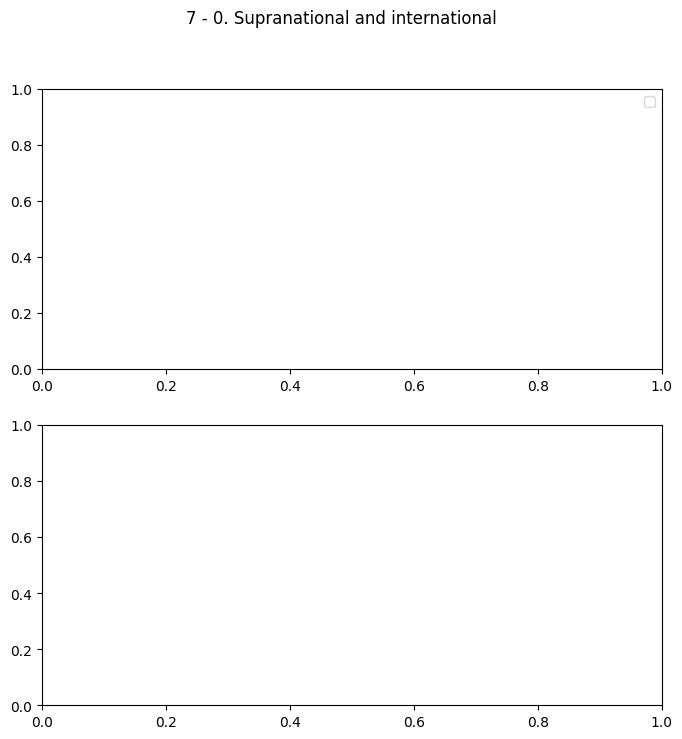

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


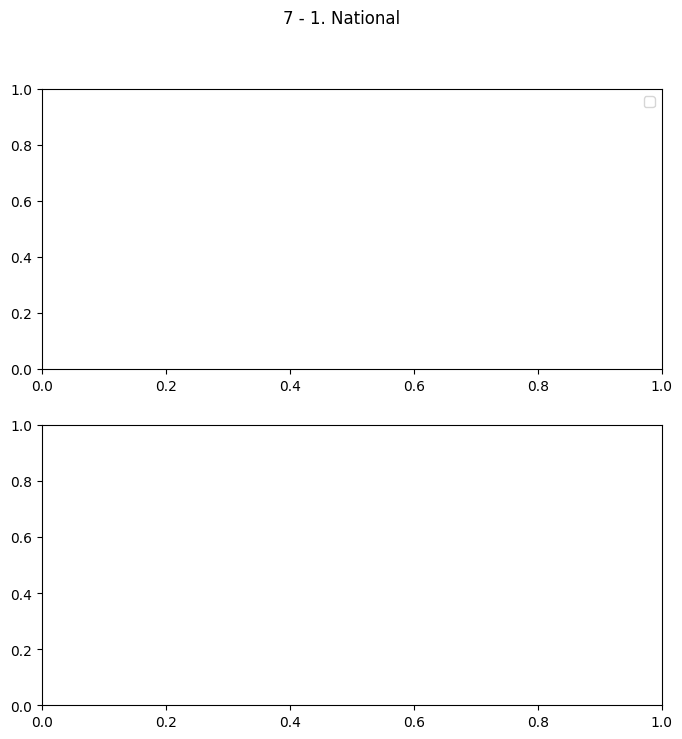

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


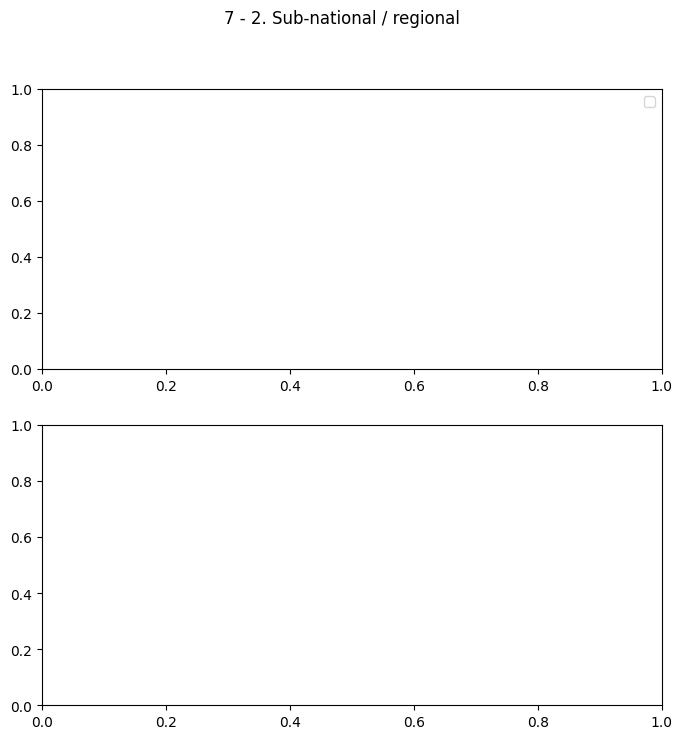

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


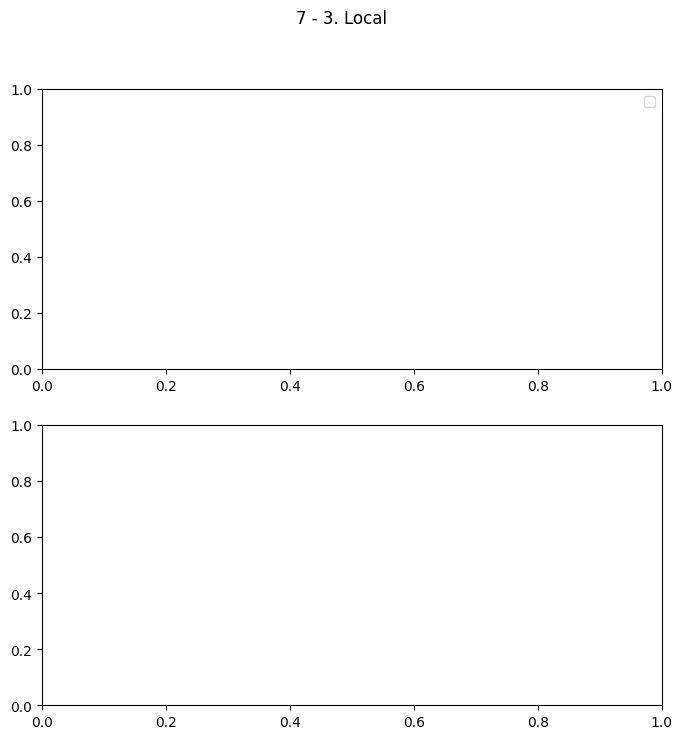

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


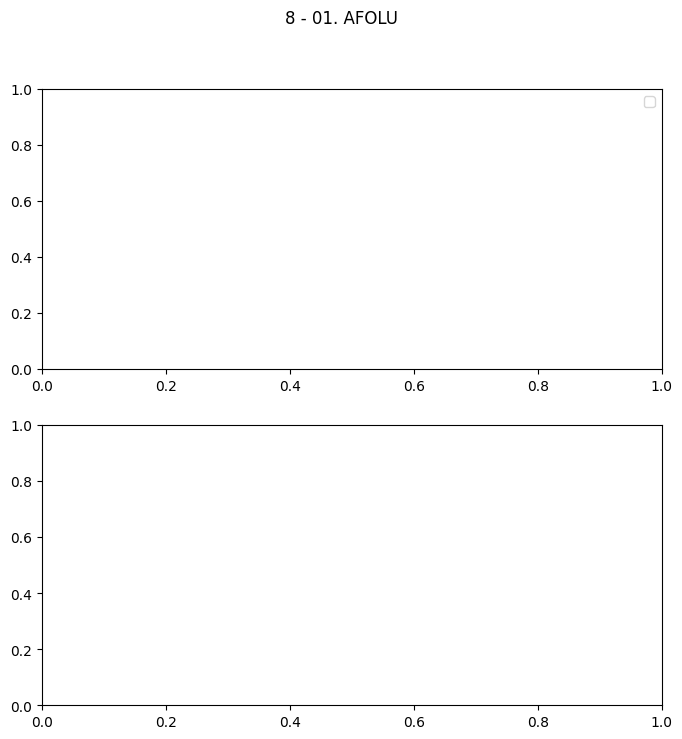

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


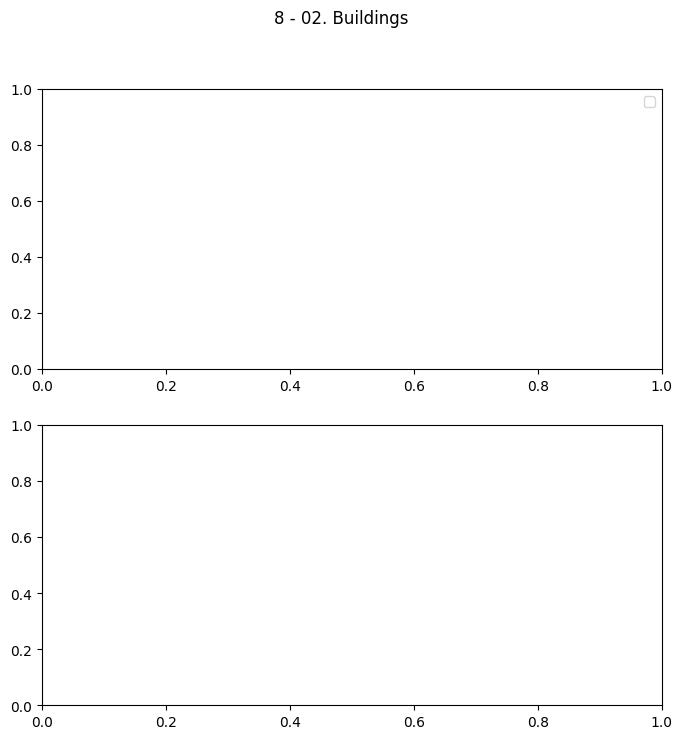

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


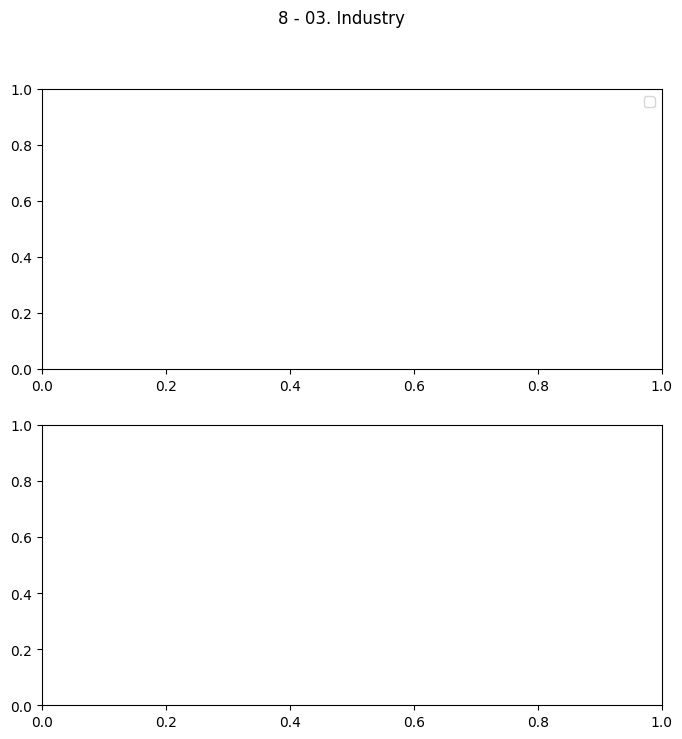

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


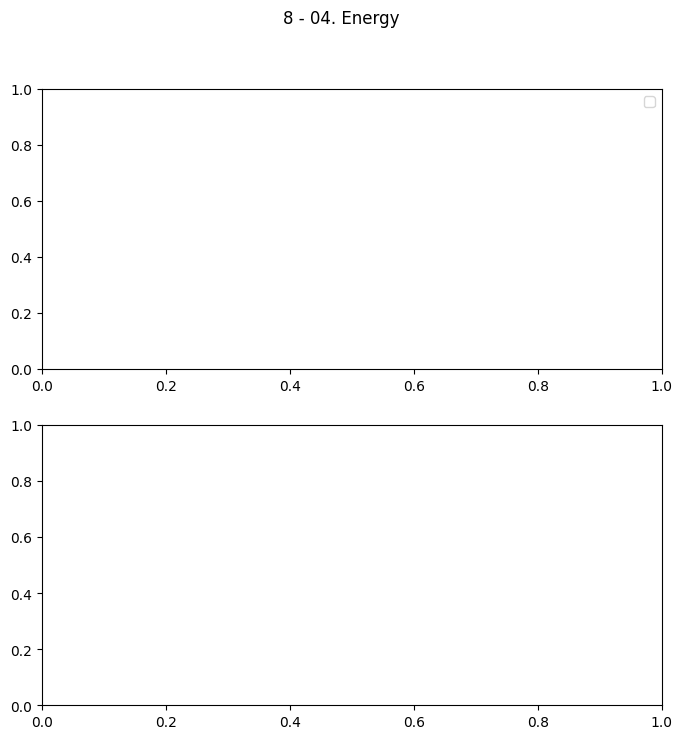

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


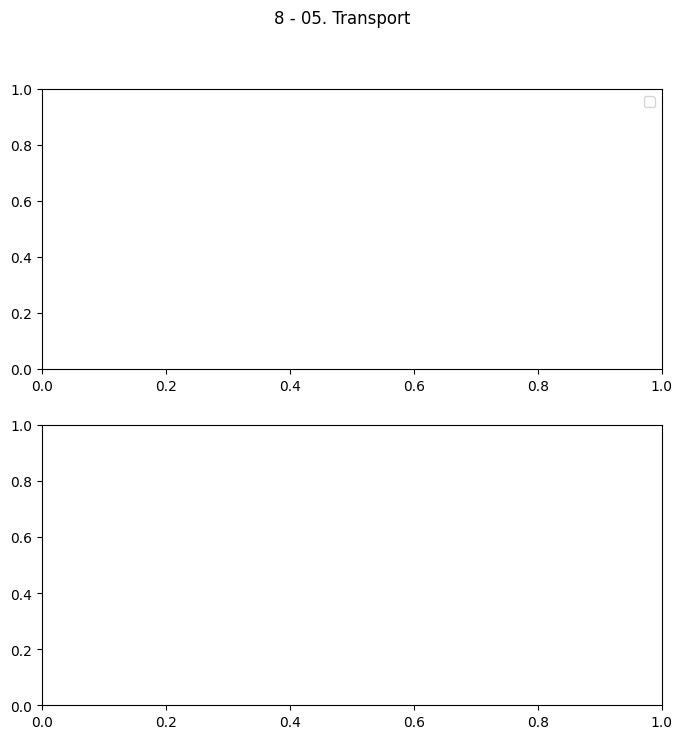

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


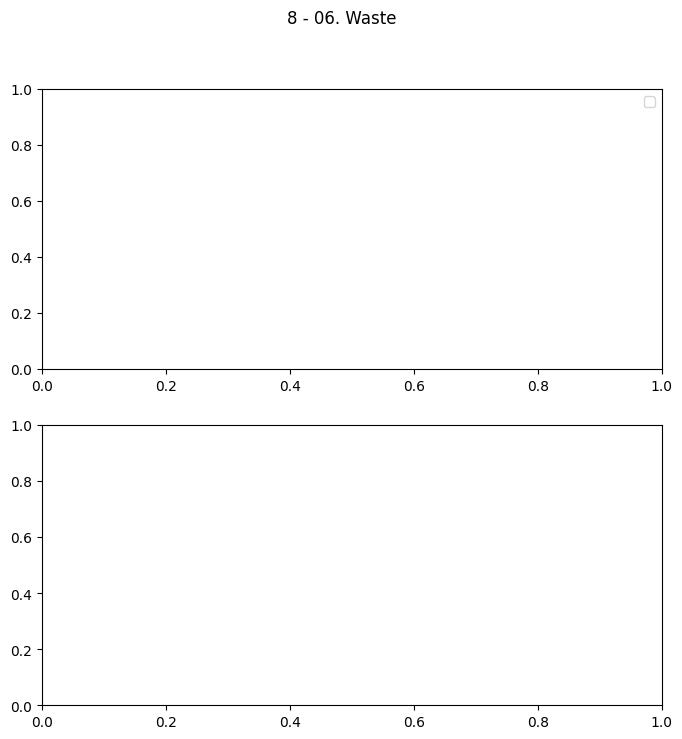

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


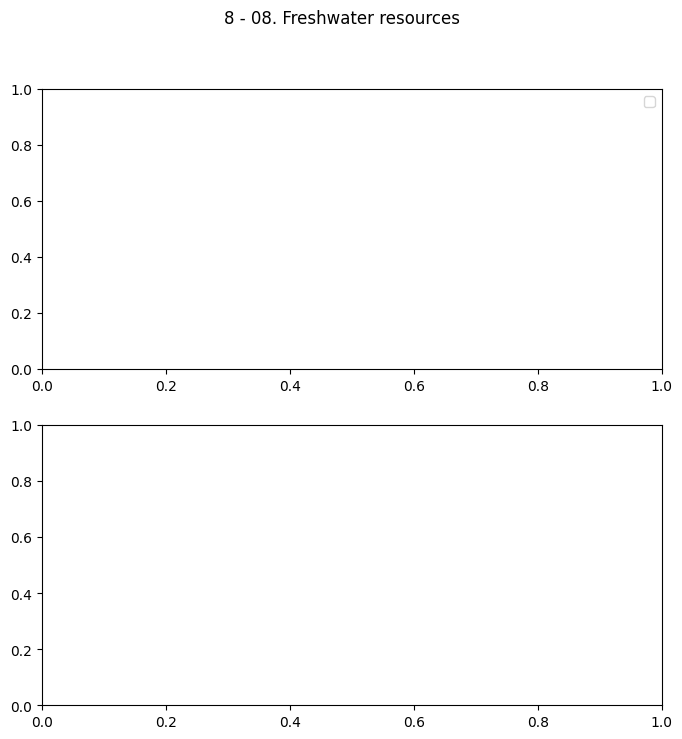

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


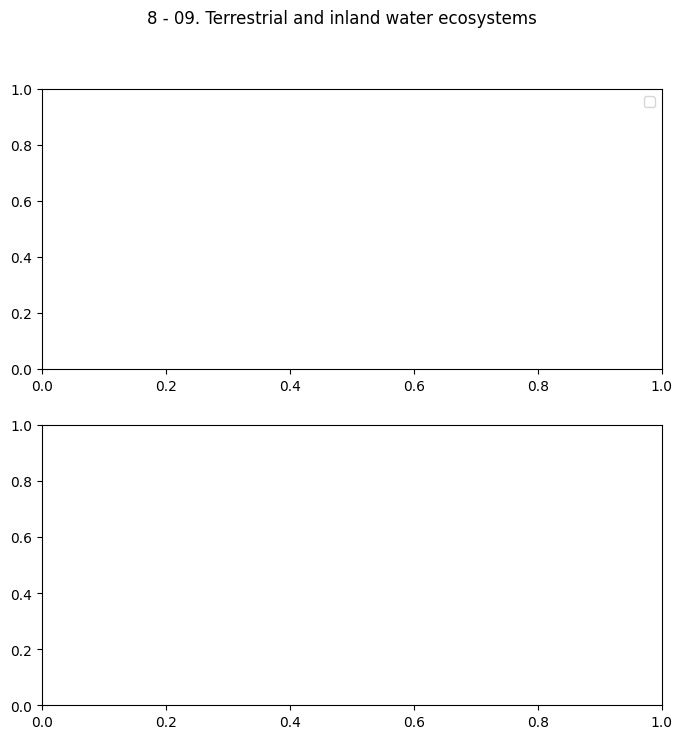

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


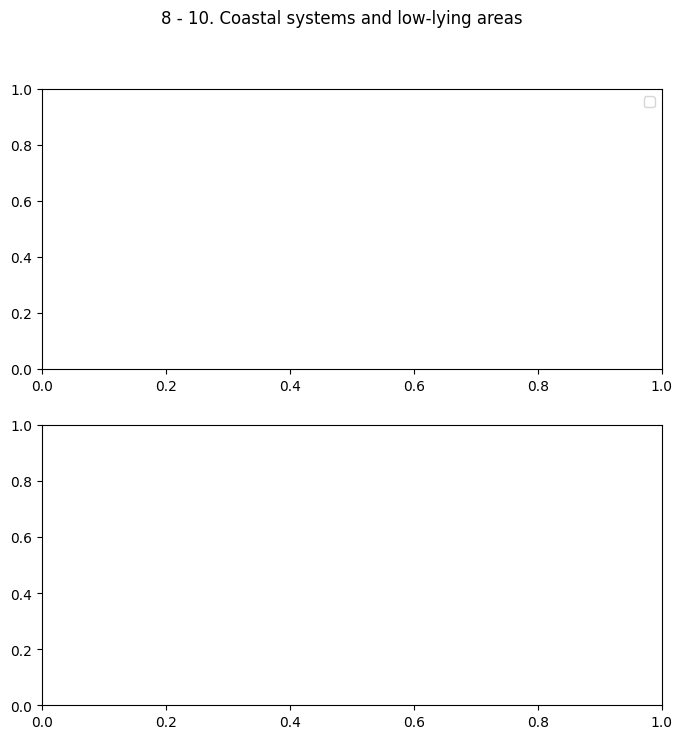

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


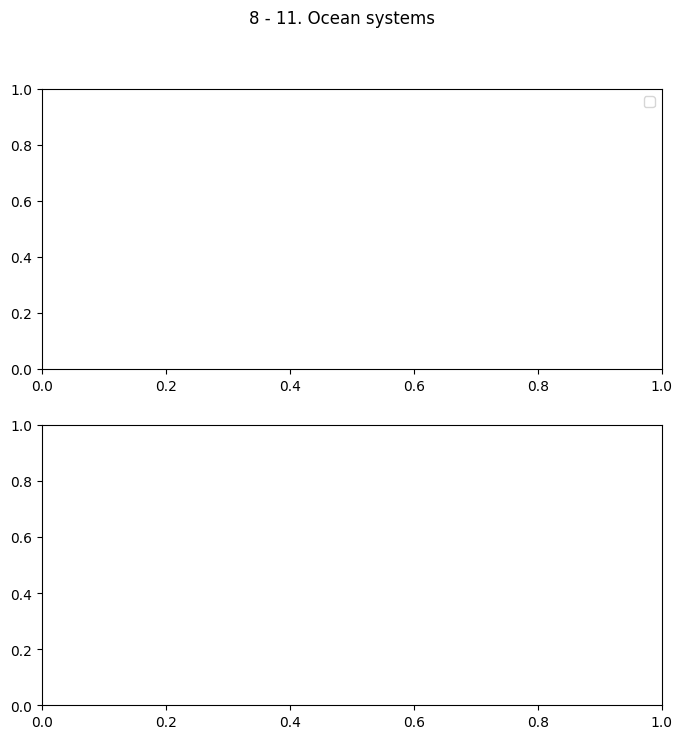

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


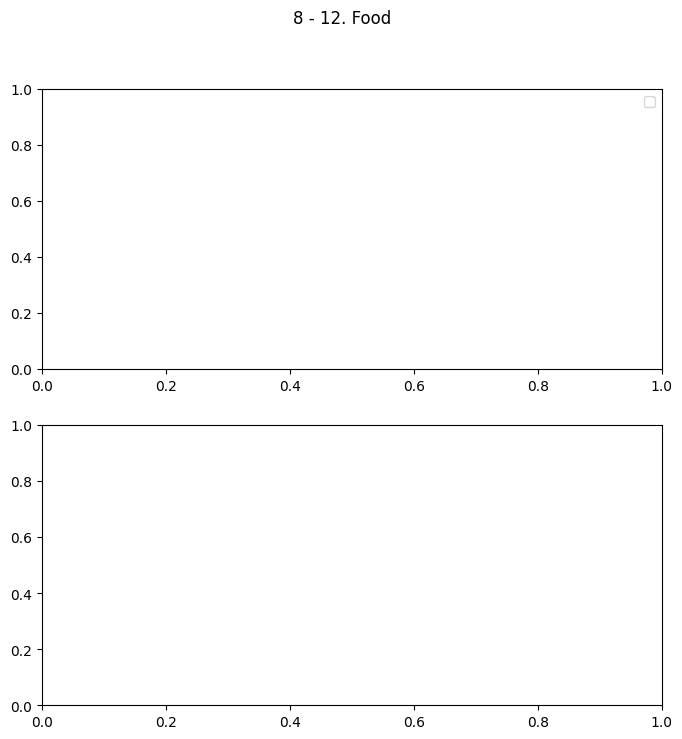

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


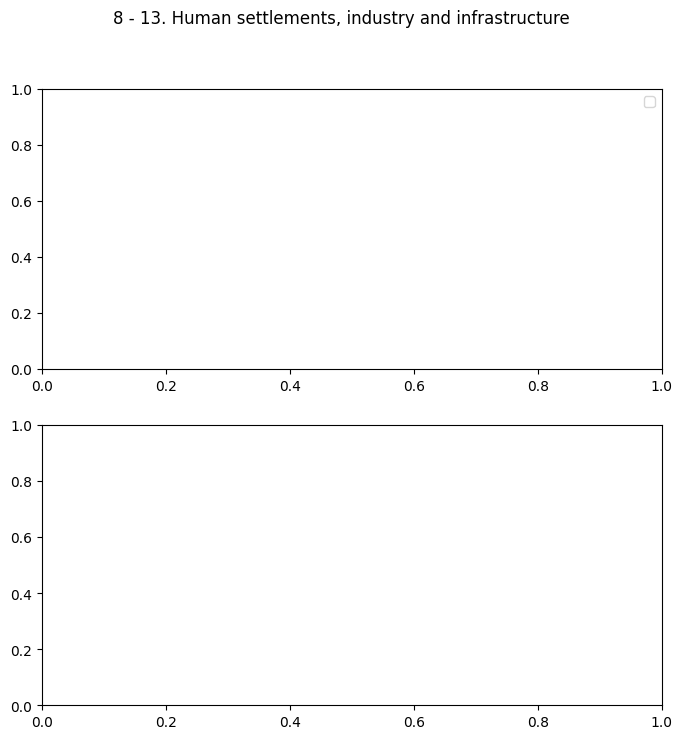

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


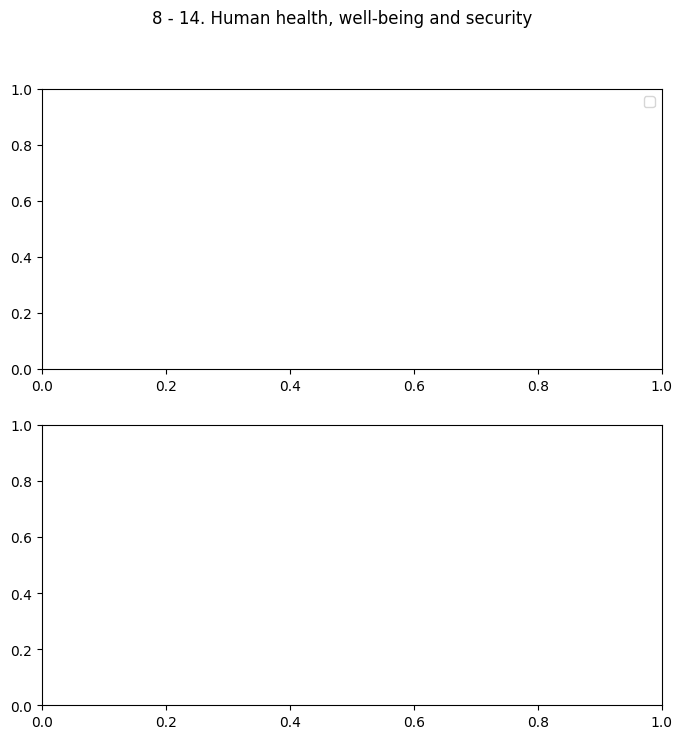

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


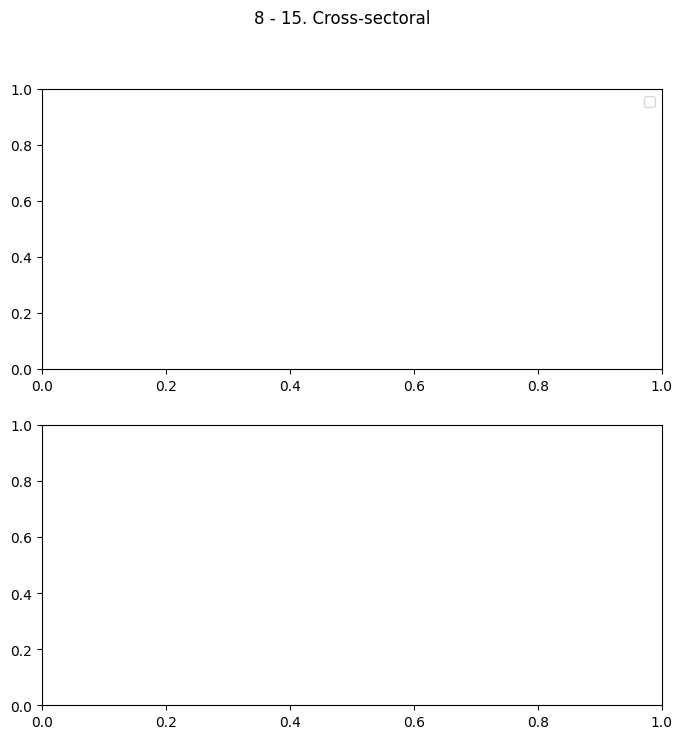

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


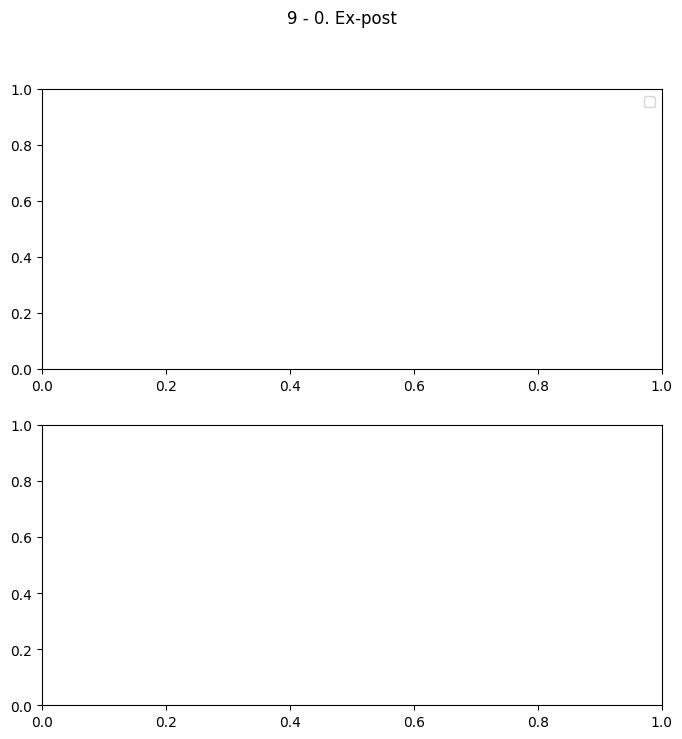

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


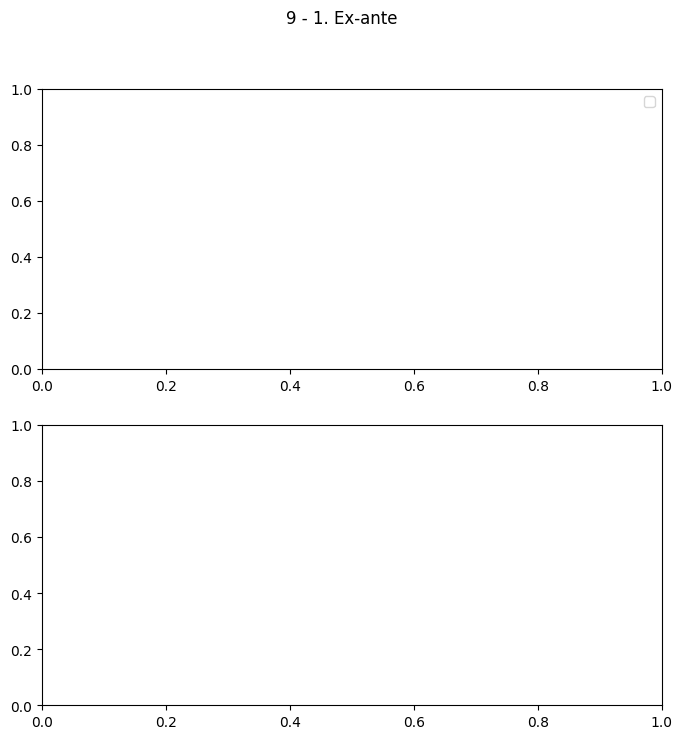

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


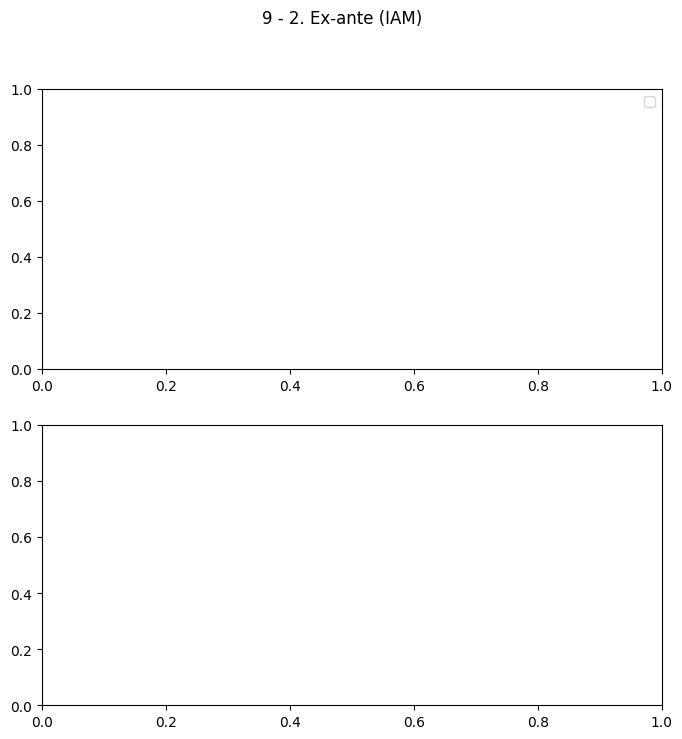

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


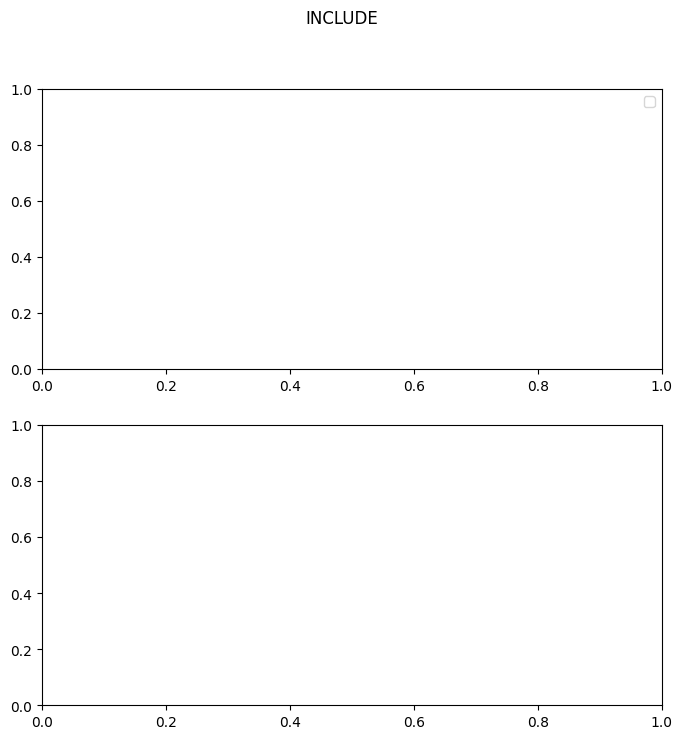

In [28]:
import itertools
pairs = list(itertools.combinations(dodf['user__username'].unique(),2))
pairs
from sklearn.metrics import cohen_kappa_score
from numpy_ext import rolling_apply as rolling_apply_ext
ckfunc = lambda a1, a2: cohen_kappa_score(a1,a2)

for c in list(df['Category Name'].unique()):
    
    sub_df = df[df['Category Name']==c].dropna(subset=["value"])
    sub_df.loc[sub_df["value"]==2,"value"]=1
    
    try:
        sub_df["value"].astype(int)
    except:
        print(c)
        continue
        
    fig, axs = plt.subplots(2,figsize=(8,8)) 

    i = 0

    for p in pairs:
        
        d1 = sub_df[(sub_df['user__username']==p[0]) & (sub_df['Category Name']==c)].rename(columns={"value":p[0]}).drop(columns="user__username")
        d2 = sub_df[(sub_df['user__username']==p[1]) & (sub_df['Category Name']==c)].rename(columns={"value":p[1]}).drop(columns="user__username")

        pdf = (d1.merge(d2,how="inner")
               .merge(order_df,left_on="doc__id",right_on="doc_id")
               .sort_values('order')
               .reset_index(drop=True)
               .fillna(1)
              )


        if pdf.shape[0]<50:
            continue
        else:
            
            ckr = rolling_apply_ext(ckfunc, 50, pdf[p[0]].astype(int).values, pdf[p[1]].astype(int).values)
            axs[0].plot(ckr,label=f"{p[0].split('@')[0]}-{p[1].split('@')[0]}")
            ck = cohen_kappa_score(pdf[p[0]],pdf[p[1]])
            axs[1].bar(i,ck,label=f"{p[0].split('@')[0]}-{p[1].split('@')[0]}")
            i+=1
            axs[0].set_ylim(-1,1)

            for ax in axs:
                ax.set_ylim(0,1)
                for t,ag in [(0,"None"),(0.2,"Minimal"),(0.4,"Weak"),(0.6,"Moderate"),(0.8,"Strong"),(0.9,"Almost Perfect")]:
                    ax.axhline(t,color="grey",ls="--",lw=0.5)


    axs[0].legend(bbox_to_anchor=(1,1))
    plt.suptitle(c)
    plt.show()